In [1]:
# Need to scale problem better
# Need to include the cost function

In [2]:
%reset # clears variables in workspace

# import libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

# import EOM
import dill
dill.load_session('simplified_biped.db')

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] + [LL] +\
           [masses[base] for base in bases] +\
           [masses[link,leg] for leg in legs for link in links] +\
           [lengths[base] for base in bases] +\
           [lengths[link,leg] for leg in legs for link in links] +\
           [inertias[base] for base in bases] +\
           [inertias[link,leg] for leg in legs for link in links] +\
           [x_body]+[y_body]+[th_body] + [th[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [dx_body]+[dy_body]+[dth_body] + [dth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [ddx_body]+[ddy_body]+[ddth_body] + [ddth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [tau['left',leg] for leg in legs] + [tau['right',leg] for leg in legs] +\
           [lamda['x',leg] for leg in legs] + [lamda['y',leg] for leg in legs] +\
           [GRF['x',leg] for leg in legs] + [GRF['y',leg] for leg in legs]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body'] +['theta_body']

for leg in legs:
    for link in links:
        if 'foot' not in link:
            DOFs = DOFs + ['theta_{0}'.format(link+leg)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})

    
# PARAMETERS:
masses_ = {'body': 5756.78/1000,
           'ullA': 153.81/1000,
           'lllA': 346.45/1000,
           'urlA': 153.81/1000,
           'lrlA': 346.45/1000,
           'ullB': 153.81/1000,
           'lllB': 346.45/1000,
           'urlB': 153.81/1000,
           'lrlB': 346.45/1000}

lengths_ = {'body': 24/100,
            'ullA': 17.5/100,
            'lllA': 30.0/100,
            'urlA': 17.5/100,
            'lrlA': 30.0/100,
            'ullB': 17.5/100,
            'lllB': 30.0/100,
            'urlB': 17.5/100,
            'lrlB': 30.0/100}

''' ****** '''
inertias_ = {'body': 32124078.52*1e-9, # body rotate about its center 
            'ullA': 600933.68*1e-9, # rotates as pendulumn 
            'urlA': 600933.68*1e-9,
            'lllA': 4659658.63*1e-9,
            'lrlA': 4659658.63*1e-9,
            'ullB': 600933.68*1e-9, # rotates as pendulumn 
            'urlB': 600933.68*1e-9,
            'lllB': 4659658.63*1e-9,
            'lrlB': 4659658.63*1e-9}

total_mass = 0.0
for mass in masses_:
    total_mass += masses_[mass]
total_mass

WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
legs = ['A','B']
links = ['ull','lll','url','lrl']
bases = ['body']
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'ull' ,'right': 'url'}
all_links = []
for leg in legs:
    for link in links:
        all_links.append(link+leg)
        
[all_links.append(base) for base in bases]

def get_var_list_zeros(m,n):
    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    connection_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
    
    for leg in legs:
        
        [tau_value.update({(side,leg): BW*(m.tau_torque[n,side,leg])}) for side in sides]
        #[connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,'+ve',wdof,leg]-m.connect_force[n,'-ve',wdof,leg])}) for wdof in WDOFs]
        #[connection_force_value.update({(wdof,leg):0.0})for wdof in WDOFs]
        [connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,wdof,leg])}) for wdof in WDOFs]
        GRF_X_value.update({(leg):BW*(m.GRF_x[n,'+ve',leg]-m.GRF_x[n,'-ve',leg])})
        GRF_Y_value.update({(leg):BW*(m.GRF_y[n,leg])})

    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left',leg] for leg in legs] + [tau_value['right',leg] for leg in legs] +\
               [connection_force_value['X',leg] for leg in legs] + [connection_force_value['Y',leg] for leg in legs] +\
               [GRF_X_value[leg] for leg in legs] + [GRF_Y_value[leg] for leg in legs]
    return var_list



Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details


--------------
Stall torque =  140.4238410596027
Max speed =  55.8
--------------


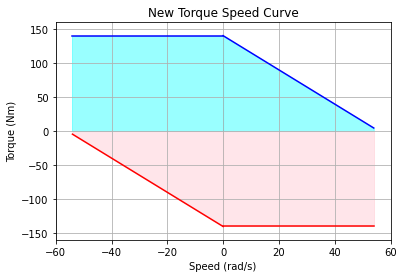

In [3]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
no_load_speed = 55.8
# from graph
max_torque = 38.0
speed_max_torque = 40.7

m_grad = (max_torque-0.0)/(speed_max_torque-no_load_speed)

stall_torque = 0.0 - m_grad*no_load_speed

y_p = m_grad*x_p+stall_torque
y_n = m_grad*x_n-stall_torque

stall_torque_p = []
stall_torque_n = []
rated_torque_p = []
rated_torque_n = []

for ii in range(len(x_p)):
    stall_torque_p.append(stall_torque)
    stall_torque_n.append(-stall_torque)
    rated_torque_p.append(max_torque)
    rated_torque_n.append(-max_torque)

plt.grid()
plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('--------------')

print('Stall torque = ',stall_torque)
print('Max speed = ',no_load_speed)

print('--------------')

In [4]:
FOR_LOOP_RUN = False

<a id='Select_Test'></a>

In [5]:
tests = {0:"High_Drop_Test",1:"Low_Drop_Test", 2:"Hop_Test", 3:"Drop_Hop_Test",\
         4:"Standing_Test", 5:"Tax_Day_Sprint",6:"Missing_the_Boat",\
         7:"Periodic_Hop",8:"Periodic_Run",9:"Stop_Periodic_Run_Flight",10:"Start_Periodic_Run",\
         11:"High_Drop_Move_Leg", 12:"Forward_Hop"}

if FOR_LOOP_RUN == False:

    test = tests[8]
    V_avg = 8.0
    mu_value = 0.5
    h_lower_bound = 0.5
    h_higher_bound = 1.5

    if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test":
        N = 50
        TT = 0.2
    elif test == "High_Drop_Move_Leg":
        N = 50
        TT = 0.4
    elif test == "Forward_Hop":
        N = 50
        TT = 0.7
        x_final = 2.0 # for display
    elif test == "Hop_Test" or test == "Drop_Hop_Test":
        N = 50
        TT = 1.0
    elif test == "Tax_Day_Sprint":
        N = 50
        TT = 1.5
        x_final = 5.0
    elif test == "Missing_the_Boat":
        N = 50
        TT = 1.0
        x_final = 5.0
    elif test == "Periodic_Hop":
        N = 50
        TT = 1.0 # 2Hz but only half a gait due to symmetry
        dy_periodic = 0.5
    elif test == "Periodic_Run":
        # u 0.5 [N = 100 and TT = 0.15 0.5<h<1.5]
        # u 1.0 [N = 100 and TT = 0.3 0.8<h<1.2]
        N = 100 #100
        TT = 0.15 #0.5 #0.3 # 2Hz but only half a gait due to symmetry
        V_flight = 0.75*sqrt(9.81*(0.18+0.35)) # from paper
        x_final = 3.0 # for display

    elif test == "Stop_Periodic_Run_Flight" or test == "Start_Periodic_Run":

        import csv
        file = open(str(round(V_avg))+'.csv')
        csvreader = csv.reader(file)

        rows = []
        for row in csvreader:
            rows.append(row)

        stored_values = {}
        headers = rows[0]

        for item in rows:
            if item[0] == 'node': # remove headers
                pass
            else: 
                for header_loc in range(len(headers)):
                    if header_loc == 0: # don't want 'node' as header - only its value
                        pass 
                    else:
                        stored_values.update({(headers[header_loc],int(item[0])):float(item[header_loc])})

            #initial_conditions[item[0]] = float(item[1])
        x_final = 5.0 # for display 

        if test == "Stop_Periodic_Run_Flight":
            # done [100,1.5 and ]
            N = 100 #50
            TT = 1.2 # 1.0 2Hz but only half a gait due to symmetry
        elif test == "Start_Periodic_Run":
            N = 50
            TT = 1.0
        else: pass   

    else:
        pass
    
###################################################################################
else:
    
    test = tests[9]
    V_avg = 8.0

    h_lower_bound = 0.5
    h_higher_bound = 1.0

    if test == "Stop_Periodic_Run_Flight" or test == "Start_Periodic_Run":

        import csv
        file = open(str(round(V_avg))+'_u{0}.csv'.format(str(mu_value)))
        csvreader = csv.reader(file)

        rows = []
        for row in csvreader:
            rows.append(row)

        stored_values = {}
        headers = rows[0]

        for item in rows:
            if item[0] == 'node': # remove headers
                pass
            else: 
                for header_loc in range(len(headers)):
                    if header_loc == 0: # don't want 'node' as header - only its value
                        pass 
                    else:
                        stored_values.update({(headers[header_loc],int(item[0])):float(item[header_loc])})

            #initial_conditions[item[0]] = float(item[1])
        x_final = 7.0 # for display  

    else:
        pass



In [6]:
print("test = ",test)
print("total mass = " ,total_mass)
print("mu = ",mu_value)
print("V_avg = ",V_avg)
print("N = ",N)
print("TT = ",TT)

if TT/N < 0.01 or TT/N>0.02:
    print('Exceeded hm: ',TT/N)
else:
    print('Passed hm: ',TT/N)
    


test =  Periodic_Run
total mass =  7.75782
mu =  0.5
V_avg =  8.0
N =  100
TT =  0.15
Exceeded hm:  0.0015


In [7]:
m = ConcreteModel('Biped')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.legs = Set(initialize = legs)
m.links = Set(initialize = links)
m.bases = Set(initialize = bases)
m.all_links = Set(initialize = all_links)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)


#Params--------------------------
m.g = Param(initialize = 9.81)
m.LL = Param(initialize = 7.5/100)

# m.masses = Param(m.links, initialize = masses)
m.masses = Param(m.all_links, initialize = masses_)
m.lengths = Param(m.all_links, initialize = lengths_)
m.inertias = Param(m.all_links, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

In [8]:
''' CONSTRAINTS  - Integration'''
# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (h_lower_bound,h_higher_bound)) #m.h = Var(m.N, bounds = (0.5,1.5))

def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

In [9]:
''' CONSTRAINTS  - CONNECTION POINT'''
m.connect_position = Var(m.N, m.WDOFs, m.sides, m.legs) # connection point
m.connect_force = Var(m.N, m.WDOFs, m.legs,bounds = (-10*total_mass*9.81,10*total_mass*9.81)) # connection force

# Lamdify
lamb_connect_position = {} # (WDOFs,sides,leg)
[lamb_connect_position.update({(wdof,side,leg): sym.lambdify(sym_list,connect_foot_position[side,leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for side in sides for wdof in WDOFs]

# Equate the connection equations from the previous script to the model m
def def_connect_position_equation(m,n,wdof,side,leg):
    var_list = get_var_list_zeros(m,n)    
    return m.connect_position[n,wdof,side,leg] == lamb_connect_position[wdof,side,leg](*var_list)
m.connect_position_equation = Constraint(m.N, m.WDOFs, m.sides, m.legs, rule = def_connect_position_equation)

# Ensure that there is no distance between the X (and Y) of link connection points
def def_connect_position(m,n,wdof,leg):
    return  m.connect_position[n,wdof,'right',leg] - m.connect_position[n,wdof,'left',leg] == 0.0
m.connect_position_constraint = Constraint(m.N, m.WDOFs, m.legs, rule= def_connect_position)

In [10]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.legs)
for n in range(1,N+1):
    for leg in legs:
        m.foot_position[n,'Y',leg].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,leg): sym.lambdify(sym_list,connect_foot_position['right',leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for wdof in WDOFs]

def def_foot_position(m,n,wdof,leg):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,leg] == lamb_foot_position[wdof,leg](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_position)

m.mu = Param(initialize = mu_value,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.legs, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.legs, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces

'''******'''
m.ground_penalty = Var(m.N, m.ground_constraints, m.legs, bounds = (0.0,10.0)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(leg): sym.lambdify(sym_list,(connect_foot_position['right',leg].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for leg in legs]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,leg):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',leg]-m.foot_velocity[n,'X','-ve',leg] == lamb_foot_velocity_x[leg](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_velocity)

def def_friction_cone(m,n,leg):
    return m.friction_cone[n,leg] == m.mu*m.GRF_y[n,leg] - (m.GRF_x[n,'+ve',leg] + m.GRF_x[n,'-ve',leg])
m.friction_cone_constraint = Constraint(m.N, m.legs, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,leg):
    if n < N:
        return m.foot_position[n+1,'Y',leg]*m.GRF_y[n,leg] <= m.ground_penalty[n,'contact',leg]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.legs, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,leg):
    return (m.foot_velocity[n,'X','+ve',leg]+m.foot_velocity[n,'X','-ve',leg])*m.friction_cone[n,leg] <= m.ground_penalty[n,'friction',leg]
m.ground_friction_constraint = Constraint(m.N, m.legs, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,leg):
    return m.foot_velocity[n,'X','+ve',leg]*m.GRF_x[n,'+ve',leg] <= m.ground_penalty[n,'slip_+ve',leg]
m.ground_slip_positive_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,leg):
    return m.foot_velocity[n,'X','-ve',leg]*m.GRF_x[n,'-ve',leg] <= m.ground_penalty[n,'slip_-ve',leg]
m.ground_slip_negative_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_negative)

#bound contact forces at last node
for leg in legs:
    m.GRF_y[N,leg].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,leg].fix(0.0)


In [11]:
'''Torque Speed - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.sides, m.legs, bounds = (-max_torque,max_torque))
m.tau_velocity = Var(m.N, m.sides, m.legs, bounds = (-no_load_speed,no_load_speed))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side,leg): sym.lambdify(sym_list,w_links[motor_w_angle[side],leg],modules = [func_map])}) for leg in legs for side in sides]

def def_angular_velocity(m,n,side,leg):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,side,leg] == lamb_tau_velocity[side,leg](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides, m.legs, rule = def_angular_velocity)

# assume straight line
def def_constant_power_right(m,n,side,leg):
    return m.tau_torque[n,side,leg] <= m.tau_velocity[n,side,leg]*m_grad + stall_torque
m.constant_power_right_constraint = Constraint(m.N, m.sides, m.legs, rule = def_constant_power_right)

def def_constant_power_left(m,n,side,leg):
    return m.tau_torque[n,side,leg] >= m.tau_velocity[n,side,leg]*m_grad - stall_torque
m.constant_power_left_constraint = Constraint(m.N, m.sides, m.legs, rule = def_constant_power_left)

In [12]:
# Set the angles for the knees - only use this when actuated 
# This ensures links does not cross
m.knee_angle = Var(m.N, m.sides, m.legs, bounds = (0.0,170*(np.pi)/180))

def def_knee_angle(m,n,side,leg):
    if side == 'left':
        return m.knee_angle[n,side,leg] == 2*np.pi - m.q[n,'theta_lll'+leg]
    else:
        return m.knee_angle[n,side,leg] == m.q[n,'theta_lrl'+leg]   
m.knee_angle_constraint = Constraint(m.N, m.sides, m.legs, rule = def_knee_angle)

In [13]:
# Get the foot position in WDOF
if test == "Periodic_Run" or test == "Periodic_Hop":
    
    lamb_body_position_x = sym.lambdify(sym_list,(r_bases['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        var_list = get_var_list_zeros(m,n)
        if wdof == 'X':
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    
    if test == "Periodic_Run":
        
        # Average velocities
        def def_body_position_average(m,wdof):
            if wdof == 'X':
                return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
            else: return Constraint.Skip
        m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
        # Equate states
        def def_equate_position_states(m,n,dof_i):
            if dof_i == 'y_body' or dof_i == 'theta_body':
                return m.q[1,dof_i] == m.q[N,dof_i]
            
            elif dof_i == 'theta_ullA':
                return m.q[1,'theta_ullA'] == m.q[N,'theta_ullB']
            elif dof_i == 'theta_ullB':
                return m.q[1,'theta_ullB'] == m.q[N,'theta_ullA']
            
            elif dof_i == 'theta_urlA':
                return m.q[1,'theta_urlA'] == m.q[N,'theta_urlB']
            elif dof_i == 'theta_urlB':
                return m.q[1,'theta_urlB'] == m.q[N,'theta_urlA']
            
            elif dof_i == 'theta_lllA':
                return m.q[1,'theta_lllA'] == m.q[N,'theta_lllB']
            elif dof_i == 'theta_lllB':
                return m.q[1,'theta_lllB'] == m.q[N,'theta_lllA']
            
            elif dof_i == 'theta_lrlA':
                return m.q[1,'theta_lrlA'] == m.q[N,'theta_lrlB']
#             elif dof_i == 'theta_lrlB':
#                 return m.q[1,'theta_lrlB'] == m.q[N,'theta_lrlA']
            else: 
                 return Constraint.Skip
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs, rule = def_equate_position_states) 

        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
  
    
        # Condition where the GRF can't increase twice from zero          
    
    
    else: 
        
        def def_equate_position_states(m,n,dof_i):
            return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

else: pass
                                    


In [14]:
''' Use this code for tests '''

# BOUND VALUES
sign_symbols = ['+','-']
boundaries = ['setub','setlb']
for n in range(1,N+1):
    for leg in legs:
        for index in range(len(boundaries)):
            eval('m.q[n,\'theta_ull\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))
            eval('m.q[n,\'theta_lll\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))  
            eval('m.q[n,\'theta_url\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))    
            eval('m.q[n,\'theta_lrl\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))

    m.q[n,'theta_body'].setub(np.pi*(1/4))
    m.q[n,'theta_body'].setlb(np.pi*(-1/4))
        
    if test == "Periodic_Run":
        m.q[n,'y_body'].setub(1.0)
        m.dq[1,'y_body'].fix(0.0)
        
#         m.dq[1,'theta_UL'].fix(0.0)
#         m.dq[1,'theta_UR'].fix(0.0)
        
    elif test == "Periodic_Hop":
        m.dq[1,'y_body'].fix(0.0)       
    
    else:
        if test == "Forward_Hop":
            m.q[n,'y_body'].setub(2.0)
        else: pass
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
    
    if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test" or test == "Drop_Hop_Test" or test =="Periodic_Hop" or test == "High_Drop_Move_Leg":

        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        
    
        if test == "Drop_Hop_Test" or test == "Periodic_Hop" or test == "High_Drop_Move_Leg":
            
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]
            
        else:
            
            [m.tau_torque[n,side,leg].fix(0.0) for side in sides for leg in legs]
    else:
    
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = x_final + 1.0
        y_low_lim = -0.5
        y_high_lim = 1.5
    
        if test == "Periodic_Run":
            pass
        else:
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]

<a id='initial_conditions'></a>

In [15]:
if test == "High_Drop_Test":
    #  ----------------------------- HIGH DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/10))
        
elif test == "High_Drop_Move_Leg":
    #  ----------------------------- HIGH DROP MOVE LEG TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/10))
    
    m.foot_position[N, 'X', 'A'].fix(0.1)
    m.foot_position[N, 'X', 'B'].fix(-0.1)
    
elif test == "Forward_Hop":
    #  ----------------------------- FORWARD HOP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.foot_position[1, 'X', 'A'].fix(0.0)
    m.foot_position[1, 'X', 'B'].fix(0.0)
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)

    m.q[N,'x_body'].setlb(1.5)
    
elif test == "Low_Drop_Test":
    #  ----------------------------- LOW DROP TEST ---------------------------

    # initial condition

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.12)
    m.foot_position[1, 'Y', 'B'].fix(0.12)

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/7))

        
elif test == "Hop_Test":
    #  ----------------------------- HOP TEST ---------------------------

    # initial condition
    m.q[1,'y_body'].fix(0.35)
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
    m.foot_position[1, 'X', 'A'].fix(0.0)
    m.foot_position[1, 'X', 'B'].fix(0.0)
        
    m.q[N,'y_body'].setlb(0.8)

elif test == "Drop_Hop_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    
#     m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
#     m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

#     m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/7))
#     m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/7))
        
    m.foot_position[round(N/5), 'Y', 'A'].setub(0.05)
    m.foot_position[round(N/5), 'Y', 'B'].setub(0.05)
        
    m.q[N,'y_body'].setlb(0.8)
    m.q[N,'x_body'].setub(0.7)
    m.q[N,'x_body'].setlb(0.3)
    
elif test == "Standing_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
 
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
     
    m.foot_position[N, 'Y', 'A'].fix(0.0)
    m.foot_position[N, 'Y', 'B'].fix(0.0)
    
elif test == 'Tax_Day_Sprint':
    
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,x_final,N)
    for n in range(1,N+1):
        m.GRF_y[n,'A'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','A'].value = m.mu.value*m.GRF_y[n,'A'].value
        m.GRF_y[n,'B'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','B'].value = m.mu.value*m.GRF_y[n,'B'].value
        
#         m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)
        
    # SPRINT --------------------------------------------------------------------------------------------------------------------
    # tax day

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    
    m.q[1,'theta_ullA'].fix(np.pi*(0.5))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5))
    m.q[1,'theta_ullB'].fix(np.pi*(0.5))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5))
        
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)

    # final condition
    m.q[N,'x_body'].setlb(x_final)

    m.dq[N,'x_body'].fix(0.0)
    m.dq[N,'theta_body'].fix(0.0)
    
    m.dq[N,'theta_ullA'].fix(0.0)
    m.dq[N,'theta_urlA'].fix(0.0)
    m.dq[N,'theta_ullB'].fix(0.0)
    m.dq[N,'theta_urlB'].fix(0.0)

    m.q[N,'theta_body'].fix(0.0)

    m.foot_position[N, 'Y', 'A'].fix(0.0)
    m.foot_position[N, 'Y', 'B'].fix(0.0)

    #m.pprint()
    
elif test ==  "Missing_the_Boat":
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
    m.q[N,'x_body'].setlb(x_final)

elif test == "Periodic_Hop":
    m.q[1,'y_body'].fix(1.0) # initial condition  
    m.q[1,'x_body'].fix(0.0) # initial condition  
    
    m.q[1,'theta_UL'].fix(0.0)
    m.q[1,'theta_UR'].fix(0.0)
    
    m.dq[1,'theta_UL'].fix(0.0)
    m.dq[1,'theta_UR'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footR}'].fix(0.0)
    
    m.dq[N,'y_body'].fix(0.0) # initial condition
    
elif test == "Periodic_Run":
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1] #+ np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)

#         m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
#         m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value
        

    m.q[1,'x_body'].fix(0.0) # initial condition
    m.q[1,'theta_body'].fix(0.0)
    
    m.q[1,'theta_ullA'].setub(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].setub(np.pi*(0.5-1/7))
    
    m.q[1,'theta_ullB'].setlb(np.pi*(0.5+1/7))
    m.q[1,'theta_urlB'].setlb(np.pi*(0.5+1/7))
    
    for n in range(1,N+1):
        m.GRF_y[n,'A'].fix(0.0)
        m.foot_position[n, 'Y', 'A'].setlb(0.05)
    
    m.GRF_y[1,'B'].fix(0.0)
    

elif test == "Stop_Periodic_Run_Flight":
    
#     guide = np.linspace(0,TT*V_avg,N)
#     for n in range(1,N+1):
#         m.q[n,'x_body'].value = guide[n-1]
    
    m.q[1,'x_body'].fix(stored_values['x_body',0]) # initial condition
    m.q[1,'y_body'].fix(stored_values['y_body',0])
    m.q[1,'theta_body'].fix(stored_values['theta_body',0])
    
    m.q[1,'theta_ullA'].fix(stored_values['theta_ullA',0])
    m.q[1,'theta_urlA'].fix(stored_values['theta_urlA',0])
    m.q[1,'theta_ullB'].fix(stored_values['theta_ullB',0])
    m.q[1,'theta_urlB'].fix(stored_values['theta_urlB',0])
    
    m.q[1,'theta_lllA'].fix(stored_values['theta_lllA',0])
    m.q[1,'theta_lrlA'].fix(stored_values['theta_lrlA',0])
    m.q[1,'theta_lllB'].fix(stored_values['theta_lllB',0])
    m.q[1,'theta_lrlB'].fix(stored_values['theta_lrlB',0])
    
    m.GRF_y[1,'A'].fix(0.0)
    m.GRF_y[1,'B'].fix(0.0)
    
    m.dq[1,'x_body'].fix(stored_values['dx_body',0]) # initial condition
    m.dq[1,'y_body'].fix(stored_values['dy_body',0])
    m.dq[1,'theta_body'].fix(stored_values['dtheta_body',0])
    m.dq[1,'theta_ullA'].fix(stored_values['dtheta_ullA',0])
    m.dq[1,'theta_urlA'].fix(stored_values['dtheta_urlA',0])
    m.dq[1,'theta_ullB'].fix(stored_values['dtheta_ullB',0])
    m.dq[1,'theta_urlB'].fix(stored_values['dtheta_urlB',0])
    
    m.dq[1,'theta_lllA'].fix(stored_values['dtheta_lllA',0])
    m.dq[1,'theta_lrlA'].fix(stored_values['dtheta_lrlA',0])
    m.dq[1,'theta_lllB'].fix(stored_values['dtheta_lllB',0])
    m.dq[1,'theta_lrlB'].fix(stored_values['dtheta_lrlB',0])

#     for n5 in range(N-5,N+1): # last 5 nodes 
#         m.dq[n5,'x_body'].setub(0.0)

    
    for n5 in range(N-5,N+1): # last 5 nodes 
        for dof_i in DOFs:
            if dof_i == 'x_body':
                m.dq[n5,dof_i].setub(0.0)
            elif dof_i == 'theta_body':
                m.dq[n5,dof_i].setub(0.0) # CCW is +ve so body will lean backwards
            else:
                pass
                #m.dq[n5,dof_i].setub(0.05*m.dq[1,dof_i])
                
        m.foot_position[n5, 'Y', 'A'].fix(0.0)
        m.foot_position[n5, 'Y', 'B'].fix(0.0)
    
elif test == "Start_Periodic_Run":
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1]
        
    # initial condition

    m.q[N,'y_body'].fix(stored_values['y_body',0])
    m.q[N,'theta_body'].fix(stored_values['theta_body',0])
    
    m.q[N,'theta_ullA'].fix(stored_values['theta_ullA',0])
    m.q[N,'theta_urlA'].fix(stored_values['theta_urlA',0])
    m.q[N,'theta_ullB'].fix(stored_values['theta_ullB',0])
    m.q[N,'theta_urlB'].fix(stored_values['theta_urlB',0])
    
    m.q[N,'theta_lllA'].fix(stored_values['theta_lllA',0])
    m.q[N,'theta_lrlA'].fix(stored_values['theta_lrlA',0])
    m.q[N,'theta_lllB'].fix(stored_values['theta_lllB',0])
    m.q[N,'theta_lrlB'].fix(stored_values['theta_lrlB',0])
    
    m.dq[N,'x_body'].fix(stored_values['dx_body',0]) # initial condition
    m.dq[N,'y_body'].fix(stored_values['dy_body',0])
    m.dq[N,'theta_body'].fix(stored_values['dtheta_body',0])
    m.dq[N,'theta_ullA'].fix(stored_values['dtheta_ullA',0])
    m.dq[N,'theta_urlA'].fix(stored_values['dtheta_urlA',0])
    m.dq[N,'theta_ullB'].fix(stored_values['dtheta_ullB',0])
    m.dq[N,'theta_urlB'].fix(stored_values['dtheta_urlB',0])
    
    m.dq[N,'theta_lllA'].fix(stored_values['dtheta_lllA',0])
    m.dq[N,'theta_lrlA'].fix(stored_values['dtheta_lrlA',0])
    m.dq[N,'theta_lllB'].fix(stored_values['dtheta_lllB',0])
    m.dq[N,'theta_lrlB'].fix(stored_values['dtheta_lrlB',0])
    

else: pass

In [16]:
#     """ ******** CANNOT CHANGE ORDER OF phases ********* """
#     phases = ['flight','stance']
    
#     phase_times = {}
       
#     phase_times.update({('left','flight'): 25})
#     phase_times.update({('left','stance'): 25})
#     phase_times.update({('right','flight'): 25})
#     phase_times.update({('right','stance'): 25})
    
#     timing_diagram = {}
#     timer = 0
    
#     for side in sides:
#         for phase in phases:
#             timer = timer + round(N*(phase_times[side,phase]/100))
#             timing_diagram.update({(side,phase): timer})
    
#     min_height = 0.005
#     min_GRF = 0.05
    
#     for left_flight in range (1,timing_diagram['left','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for left_stance in range (timing_diagram['left','flight']+1,timing_diagram['left','stance']+1):
#         # left foot down
#         m.GRF_y[left_stance,'footR'].fix(0.0)
#         m.foot_position[left_stance, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_stance, 'Y', 'footL'].fix(0.0)
        
#     for right_flight in range (timing_diagram['left','stance']+1,timing_diagram['right','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for right_stance in range (timing_diagram['right','flight']+1,timing_diagram['right','stance']+1):
#         # right foot down
#         m.GRF_y[right_stance,'footL'].fix(0.0)
#         m.foot_position[right_stance, 'Y', 'footL'].setlb(min_height)
#         m.foot_position[right_stance, 'Y', 'footR'].fix(0.0)

In [17]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    row = 1e4 # scale the penalty
    actuation_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
   
    
    T = sum(m.h[n] for n in range(1,N+1))
    
    for n in range(1,N+1):
        for leg in legs:
            for side in sides:
                actuation_sum += (m.tau_torque[n,side,leg])**2
                if test == "Periodic_Run":
                    transport_sum += ((m.tau_torque[n,side,leg])**2)/(m.q[N,'x_body'])
                else: pass
                
            for gc in ground_constraints:
                for leg in legs:
                    pen_sum += m.ground_penalty[n,gc,leg] 
                    
    if test == "Periodic_Run":
        return row*pen_sum + actuation_sum/100 #+ transport_sum
    elif test == "Stop_Periodic_Run_Flight":
        return row*pen_sum + m.q[N,'x_body']
    elif test == "Start_Periodic_Run":
        return row*pen_sum #+ T
    else:
        return row*pen_sum
        
m.Cost = Objective(rule = CostFun)

In [18]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_ullA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullA'](*var_list) == 0
m.EOM_th_ullA_constraint = Constraint(m.N, rule = EOM_th_ullA)

def EOM_th_lllA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllA'](*var_list) == 0
m.EOM_th_lllA_constraint = Constraint(m.N, rule = EOM_th_lllA)

def EOM_th_urlA(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlA'](*var_list) == 0
m.EOM_th_urlA_constraint = Constraint(m.N, rule = EOM_th_urlA)

def EOM_th_lrlA(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlA'](*var_list) == 0
m.EOM_th_lrlA_constraint = Constraint(m.N, rule = EOM_th_lrlA)

In [19]:
def EOM_th_ullB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullB'](*var_list) == 0
m.EOM_th_ullB_constraint = Constraint(m.N, rule = EOM_th_ullB)

def EOM_th_lllB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllB'](*var_list) == 0
m.EOM_th_lllB_constraint = Constraint(m.N, rule = EOM_th_lllB)

def EOM_th_urlB(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlB'](*var_list) == 0
m.EOM_th_urlB_constraint = Constraint(m.N, rule = EOM_th_urlB)

def EOM_th_lrlB(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlB'](*var_list) == 0
m.EOM_th_lrlB_constraint = Constraint(m.N, rule = EOM_th_lrlB)

In [20]:
# solving
opt = SolverFactory('ipopt',executable = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000*10   # maximum number of iterations
opt.options["max_cpu_time"] = 600*10  # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

# model.piston_complementarity.deactivate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False).solve(model, tee=True)
# if result.solver.termination_condition != TerminationCondition.optimal: quit()
# # solve for discrete piston control
# model.piston_complementarity.activate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False, warm_start=True).solve(model, tee=True)

Ipopt 3.14.2: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=300000
max_cpu_time=6000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.2, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    45349
Number of nonzeros in inequality constraint Jacobian.:     3986
Number of nonzeros in Lagrangian Hessian.............:    24767

Total number of variables............................:     8191
                     variables with only lower bounds:      800
                variables with lower and upper bounds:     3893
                     variables with only u

 118r 2.0742215e+07 1.89e+00 1.11e+02  -0.2 2.12e+00   1.4 7.22e-01 3.20e-01f  1
 119r 2.0729804e+07 1.88e+00 4.80e+01  -0.2 7.84e-01   1.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r 2.0725157e+07 1.88e+00 4.73e+01  -0.2 2.89e-01   2.2 1.00e+00 1.00e+00f  1
 121r 2.0723454e+07 1.88e+00 4.75e+01  -0.2 1.09e-01   2.6 1.00e+00 1.00e+00f  1
 122r 2.0719915e+07 1.88e+00 1.46e+02  -0.2 4.13e-01   2.2 1.00e+00 7.30e-01f  1
 123r 2.0718635e+07 1.88e+00 8.09e+01  -0.2 1.62e-01   2.6 1.00e+00 8.03e-01f  1
 124r 2.0712265e+07 1.88e+00 4.57e+02  -0.2 3.55e-01   2.1 4.99e-01 1.00e+00f  1
 125r 2.0703272e+07 1.87e+00 9.66e+01  -0.2 1.04e+00   1.6 7.55e-01 5.17e-01f  1
 126r 2.0653089e+07 1.85e+00 5.41e+01  -0.2 3.02e+00   1.2 8.56e-01 1.00e+00f  1
 127r 2.0605411e+07 1.85e+00 1.76e+02  -0.2 7.63e+00   0.7 2.12e-01 3.95e-01f  1
 128r 2.0599763e+07 1.85e+00 3.81e+01  -0.2 3.73e-01   2.0 1.00e+00 1.00e+00f  1
 129r 2.0597601e+07 1.85e+00

 255r 1.5527493e+07 9.81e-01 5.53e+02  -0.9 3.16e+00   1.9 2.14e-02 1.05e-02f  1
 256r 1.5527605e+07 9.81e-01 5.71e+02  -0.9 8.95e-01   2.3 6.15e-02 8.28e-03f  1
 257r 1.5528220e+07 9.81e-01 5.63e+02  -0.9 3.89e+00   1.9 9.49e-03 1.34e-02f  1
 258r 1.5529642e+07 9.81e-01 5.24e+02  -0.9 9.89e-01   2.3 1.10e-01 8.85e-02f  1
 259r 1.5530013e+07 9.81e-01 5.23e+02  -0.9 2.10e+01   1.8 2.79e-03 2.74e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260r 1.5530283e+07 9.81e-01 5.51e+02  -0.9 1.02e+00   2.2 6.99e-02 1.78e-02f  1
 261r 1.5530375e+07 9.81e-01 5.49e+02  -0.9 4.81e+00   1.8 2.13e-03 2.92e-03f  1
 262r 1.5530574e+07 9.81e-01 9.13e+02  -0.9 4.53e+00   1.3 1.96e-02 5.50e-03f  1
 263r 1.5531234e+07 9.81e-01 5.51e+02  -0.9 5.40e+00   1.7 5.26e-04 2.38e-02f  1
 264r 1.5531866e+07 9.81e-01 4.99e+02  -0.9 6.44e-01   2.1 2.86e-02 5.40e-02f  1
 265r 1.5531958e+07 9.81e-01 4.76e+02  -0.9 3.94e+00   1.7 5.07e-02 3.50e-02f  1
 266r 1.5532474e+07 9.81e-01

 393r 7.6821789e+06 2.52e+00 3.21e+02  -2.4 2.05e+01  -2.0 5.88e-01 6.67e-03f  1
 394r 7.3229220e+06 9.93e-01 1.15e+02  -2.4 7.85e+00  -1.6 2.76e-01 1.00e+00f  1
 395r 7.3316047e+06 9.87e-01 2.09e+02  -2.4 4.25e+01  -2.1 3.82e-01 6.09e-03f  1
 396r 7.5478185e+06 4.08e-01 2.17e+01  -2.4 1.20e+01  -1.7 1.00e+00 9.30e-01f  1
 397r 7.9082295e+06 4.05e-01 2.37e+00  -2.4 6.09e+00  -1.2 1.00e+00 1.00e+00f  1
 398r 9.2898573e+06 3.99e-01 9.75e+01  -2.4 1.89e+01  -1.7 6.44e-01 1.00e+00f  1
 399r 9.2203727e+06 3.95e-01 1.67e+02  -2.4 7.17e+00  -2.2 4.23e-03 2.05e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400r 9.2344863e+06 3.93e-01 1.67e+02  -2.4 7.95e+00  -1.8 2.47e-02 2.70e-02f  1
 401r 9.2223646e+06 3.93e-01 1.62e+02  -2.4 4.11e+00  -0.4 5.80e-02 8.67e-02h  1
 402r 9.2129291e+06 3.93e-01 1.26e+02  -2.4 3.61e+00  -0.9 1.30e-01 5.21e-02h  1
 403r 9.1837934e+06 3.93e-01 1.45e+02  -2.4 2.61e+00  -0.5 1.79e-02 1.95e-01f  1
 404r 9.1683952e+06 3.90e-01

 531r 1.2837245e+07 2.05e-01 8.57e+02  -3.7 4.80e+00  -1.0 1.11e-01 6.32e-02f  1
 532r 1.2930859e+07 2.02e-01 6.13e+02  -3.7 1.12e+00  -0.6 1.86e-01 3.21e-01f  1
 533r 1.2946204e+07 2.01e-01 6.32e+02  -3.7 1.20e+01  -1.1 6.37e-02 1.70e-02f  1
 534r 1.2987404e+07 2.00e-01 5.47e+02  -3.7 1.55e+00  -0.7 1.54e-01 1.31e-01f  1
 535r 1.2989758e+07 2.00e-01 5.45e+02  -3.7 1.42e+00  -1.2 2.93e-02 2.97e-03f  1
 536r 1.3093690e+07 1.96e-01 3.84e+02  -3.7 1.71e+00  -0.7 2.96e-01 2.96e-01f  1
 537r 1.3126363e+07 1.94e-01 3.79e+02  -3.7 1.64e+01  -1.2 4.61e-02 2.86e-02f  1
 538r 1.3158943e+07 1.93e-01 4.96e+02  -3.7 2.31e+00  -0.8 5.29e-01 8.39e-02f  1
 539r 1.3162283e+07 1.93e-01 5.35e+02  -3.7 1.85e+00  -1.3 2.63e-02 3.53e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540r 1.3243374e+07 1.90e-01 4.65e+02  -3.7 2.57e+00  -0.8 2.28e-01 1.81e-01f  1
 541r 1.3254107e+07 1.89e-01 5.42e+02  -3.7 8.13e+01  -1.3 1.14e-02 4.49e-03f  1
 542r 1.3306531e+07 1.87e-01

 624  2.2646525e+05 8.27e-01 2.63e+03  -1.0 2.71e+03  -2.4 6.80e-04 6.80e-04s 17
 625  2.3209649e+05 8.26e-01 2.62e+03  -1.0 1.08e+03  -2.0 4.12e-03 4.12e-03s 17
 626  2.3412820e+05 8.24e-01 2.61e+03  -1.0 2.63e+03  -2.5 2.33e-03 2.33e-03s 17
 627  2.4133782e+05 8.22e-01 2.60e+03  -1.0 8.54e+02  -2.1 4.07e-03 4.07e-03s 17
 628  2.4141224e+05 8.22e-01 2.60e+03  -1.0 1.26e+04  -2.5 1.43e-04 1.43e-04s 17
 629r 2.4141224e+05 8.22e-01 1.00e+03  -0.1 0.00e+00  -2.1 0.00e+00 0.00e+00R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630r 2.4239788e+05 2.26e-01 1.08e+03  -0.1 5.54e+04    -  3.03e-02 9.91e-04f  1
 631  2.2753126e+05 2.25e-01 1.19e+02  -1.0 2.74e+04    -  3.59e-04 4.18e-03f  1
 632  2.2462970e+05 2.25e-01 5.08e+02  -1.0 1.64e+04    -  4.40e-02 1.04e-03f  1
 633  2.1389119e+05 2.66e-01 4.38e+02  -1.0 2.36e+04    -  1.11e-02 1.65e-02f  1
 634  1.9355973e+05 7.65e-01 1.19e+03  -1.0 2.25e+04    -  8.34e-02 4.60e-02f  1
 635  1.8880743e+05 8.60e-01

 717  4.7468430e+06 3.24e-01 3.76e+04  -1.0 3.09e+01   0.3 3.00e-02 4.72e-02h  1
 718  4.7991351e+06 3.19e-01 3.87e+04  -1.0 7.05e+01  -0.2 2.53e-02 1.75e-02h  1
 719  4.8672315e+06 3.04e-01 4.14e+04  -1.0 3.28e+01   0.3 6.40e-02 4.70e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720  4.9672822e+06 2.95e-01 3.86e+04  -1.0 8.65e+01  -0.2 2.00e-02 2.80e-02h  1
 721  5.0556352e+06 2.83e-01 2.86e+04  -1.0 3.75e+01   0.2 9.62e-03 4.10e-02h  1
 722  5.1456617e+06 2.79e-01 2.77e+04  -1.0 1.16e+02  -0.3 1.53e-02 1.73e-02h  1
 723  5.1517393e+06 2.78e-01 3.60e+04  -1.0 3.67e+01   0.2 3.33e-02 2.64e-03h  1
 724  5.1648703e+06 2.76e-01 3.55e+04  -1.0 8.57e+02  -0.3 1.48e-03 6.62e-03h  1
 725  5.2665724e+06 2.65e-01 2.57e+04  -1.0 4.06e+01   0.1 8.19e-03 4.24e-02h  1
 726  5.3135155e+06 2.54e-01 2.29e+04  -1.0 2.02e+01   0.5 3.52e-02 4.10e-02h  1
 727  5.3292034e+06 2.53e-01 2.32e+04  -1.0 7.81e+01   0.1 7.95e-03 5.60e-03h  1
 728  5.4179306e+06 2.36e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 810  7.6886110e+05 2.02e+00 4.52e+03  -1.0 7.19e+02  -1.3 4.40e-03 1.53e-03h  1
 811  7.7515171e+05 1.95e+00 3.68e+03  -1.0 5.39e+01  -0.9 1.72e-02 3.83e-02h  1
 812  7.7765732e+05 1.91e+00 6.18e+03  -1.0 1.97e+02  -1.3 6.69e-02 1.87e-02h  1
 813  7.7772371e+05 1.91e+00 6.03e+03  -1.0 2.31e+03  -1.8 5.26e-03 5.56e-04h  1
 814  7.8009163e+05 1.90e+00 5.15e+03  -1.0 3.74e+02  -1.4 9.93e-05 8.35e-03h  1
 815  7.8552124e+05 1.85e+00 4.49e+03  -1.0 6.87e+01  -1.0 1.71e-02 2.86e-02h  1
 816  7.8596565e+05 1.84e+00 6.66e+03  -1.0 2.76e+01  -0.5 4.14e-02 3.96e-03h  1
 817  7.9263930e+05 1.79e+00 3.26e+03  -1.0 9.00e+01  -1.0 6.00e-04 3.24e-02h  1
 818  7.9301878e+05 1.79e+00 6.07e+03  -1.0 2.83e+01  -0.6 2.30e-02 2.92e-03h  1
 819  7.9420405e+05 1.78e+00 5.45e+03  -1.0 1.05e+02  -1.1 1.65e-04 5.57e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820  7.9699276e+05 1.75e+00

 902  9.1988724e+06 1.55e-03 2.32e+05  -1.0 5.31e+00   1.8 2.25e-02 2.43e-03h  7
 903  9.2714200e+06 1.55e-03 2.40e+05  -1.0 1.76e+00   2.2 1.00e+00 5.41e-02h  4
 904  9.2753764e+06 1.55e-03 2.41e+05  -1.0 7.25e+00   1.7 2.96e-02 9.24e-04h  8
 905  9.3071002e+06 1.54e-03 2.49e+05  -1.0 1.97e+00   2.2 1.00e+00 2.10e-02h  5
 906  9.3105040e+06 1.54e-03 2.49e+05  -1.0 1.30e+01   1.7 2.13e-02 6.73e-04h  8
 907  9.3413442e+06 1.54e-03 2.51e+05  -1.0 2.13e+00   2.1 1.00e+00 1.82e-02h  5
 908  9.3436174e+06 1.54e-03 2.49e+05  -1.0 4.74e+01   1.6 7.56e-03 3.51e-04h  7
 909  9.3608060e+06 1.54e-03 2.53e+05  -1.0 2.32e+00   2.1 8.58e-01 9.03e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910  9.9331945e+06 1.53e-03 5.37e+04  -1.0 8.60e-01   2.5 4.27e-01 7.86e-01w  1
 911  1.0221972e+07 1.52e-03 1.09e+05  -1.0 2.83e+00   2.0 4.40e-01 1.29e-01w  1
 912  1.0314308e+07 1.51e-03 2.27e+05  -1.0 1.05e+00   2.4 1.00e+00 1.09e-01w  1
 913  9.5039032e+06 1.54e-03

1016  1.8240690e+07 6.78e-04 1.35e+03  -1.0 1.04e+04    -  1.41e-03 1.13e-04f  1
1017  1.7637739e+07 2.30e-03 1.33e+03  -1.0 9.91e+03    -  8.95e-04 1.55e-03f  2
1018  1.7267093e+07 3.21e-03 1.35e+03  -1.0 9.91e+03    -  1.89e-03 1.00e-03f  2
1019  1.7056521e+07 3.50e-03 1.38e+03  -1.0 9.90e+03    -  1.51e-03 5.88e-04f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020  1.6838715e+07 3.78e-03 1.36e+03  -1.0 1.16e+04    -  7.88e-05 5.69e-04f  2
1021  1.6645114e+07 3.97e-03 1.36e+03  -1.0 1.25e+04    -  2.89e-04 4.78e-04f  2
1022  1.6552534e+07 4.01e-03 1.36e+03  -1.0 1.42e+04    -  4.98e-04 2.08e-04f  1
1023  1.6468643e+07 4.03e-03 1.36e+03  -1.0 1.99e+04    -  1.93e-04 1.71e-04f  1
1024  1.5760421e+07 5.61e-03 1.34e+03  -1.0 2.38e+04    -  2.80e-04 1.38e-03f  1
1025  1.5377196e+07 6.21e-03 1.34e+03  -1.0 3.11e+04    -  7.73e-04 6.65e-04f  1
1026  1.3355002e+07 5.64e-02 1.28e+03  -1.0 3.57e+04    -  9.06e-04 3.32e-03f  1
1027  1.1264364e+07 1.12e-01

1109  3.6425852e+05 2.19e-03 1.08e+03  -2.5 5.15e-02   1.6 3.09e-01 3.09e-01s 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1110r 3.6425852e+05 2.19e-03 1.00e+03  -2.5 0.00e+00   1.1 0.00e+00 0.00e+00R  1
1111r 3.6424884e+05 2.91e-04 1.07e+03  -2.5 1.33e+04    -  7.99e-02 1.28e-03f  1
1112r 3.6402926e+05 8.80e-02 1.02e+03  -2.5 9.34e+03    -  1.70e-01 8.79e-02f  1
1113r 3.6564446e+05 8.82e-02 9.42e+02  -2.5 4.27e+03    -  1.93e-01 7.98e-02f  1
1114r 3.7378510e+05 1.48e-01 5.24e+02  -2.5 3.61e+03    -  4.91e-01 4.30e-01f  1
1115r 3.7748353e+05 1.15e-01 4.36e+02  -2.5 1.84e+03    -  1.38e-01 2.35e-01f  1
1116r 3.8834886e+05 3.37e-02 4.96e+02  -2.5 1.45e+03    -  3.25e-01 7.68e-01f  1
1117r 3.9883959e+05 1.49e-01 7.47e+02  -2.5 1.90e+03    -  2.31e-01 9.62e-01f  1
1118r 4.0437477e+05 7.37e-02 2.71e+02  -2.5 1.62e+03    -  6.22e-01 8.04e-01f  1
1119r 4.2672728e+05 2.31e-02 1.98e+02  -2.5 5.62e+02    -  3.88e-01 1.00e+00f  1
iter    objective    inf_pr 

1201  1.3819264e+04 2.59e-05 4.53e+03  -2.5 3.89e+00  -1.7 1.10e-01 4.21e-03h  8
1202  1.3819535e+04 2.59e-05 4.52e+03  -2.5 1.22e+01  -2.1 3.72e-02 1.99e-03f  7
1203  1.3927354e+04 2.59e-05 3.18e+03  -2.5 7.63e-02   0.1 8.44e-01 2.95e-01h  1
1204  1.3935051e+04 2.59e-05 3.13e+03  -2.5 2.46e-01  -0.4 1.00e+00 3.12e-02h  6
1205  1.3937881e+04 2.58e-05 3.05e+03  -2.5 6.88e-01  -0.9 1.00e+00 1.04e-02h  7
1206  1.3939779e+04 2.58e-05 3.05e+03  -2.5 1.90e+00  -1.3 5.96e-01 6.16e-03h  8
1207  1.3940416e+04 2.58e-05 3.04e+03  -2.5 5.15e+00  -1.8 1.74e-01 3.18e-03h  8
1208  1.3940115e+04 2.58e-05 3.04e+03  -2.5 1.97e+01  -2.3 2.80e-02 1.00e-03f  7
1209  1.3942300e+04 2.58e-05 3.02e+03  -2.5 8.70e-01  -1.0 1.00e+00 7.81e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1210  1.3943876e+04 2.58e-05 3.00e+03  -2.5 2.32e+00  -1.5 2.88e-01 5.63e-03h  8
1211  1.3944204e+04 2.58e-05 2.99e+03  -2.5 6.33e+00  -1.9 2.22e-01 3.06e-03h  8
1212  1.3942755e+04 2.58e-05

1294  8.9955235e+03 4.15e-04 5.32e+02  -3.8 9.26e-01  -0.9 1.00e+00 4.64e-01f  1
1295  8.9639860e+03 2.95e-04 3.99e+02  -3.8 2.55e+00  -1.4 3.80e-01 3.14e-01f  1
1296  8.8331178e+03 1.77e-03 2.06e+02  -3.8 6.73e+00  -1.8 2.54e-01 3.30e-01f  1
1297  8.8294562e+03 1.73e-03 1.12e+03  -3.8 2.48e+00  -1.4 7.68e-01 2.30e-02f  1
1298  8.8184844e+03 1.69e-03 1.13e+03  -3.8 8.47e+00  -1.9 6.65e-02 4.33e-02f  1
1299  8.7817091e+03 1.43e-03 1.33e+03  -3.8 2.73e+00  -1.5 1.00e+00 2.31e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  8.7135794e+03 1.32e-03 1.39e+03  -3.8 6.87e+00  -1.9 2.71e-01 1.71e-01f  1
1301  8.6653758e+03 9.82e-04 9.06e+02  -3.8 2.53e+00  -1.5 1.55e-01 2.69e-01f  1
1302  8.6433294e+03 9.37e-04 1.33e+03  -3.8 7.27e+00  -2.0 1.63e-01 5.58e-02f  1
1303  8.6076636e+03 7.12e-04 1.05e+03  -3.8 2.60e+00  -1.6 2.98e-01 2.56e-01f  1
1304  8.5693825e+03 2.74e-04 8.93e+02  -3.8 9.52e-01  -1.1 1.00e+00 6.33e-01f  1
1305  8.5185162e+03 2.30e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1390  8.3380060e+05 2.89e-05 9.94e+01  -3.8 2.47e+03    -  7.93e-03 5.30e-04f  4
1391  8.1996130e+05 3.39e-05 9.92e+01  -3.8 1.90e+03    -  3.52e-03 4.76e-04f  5
1392  8.0765879e+05 3.78e-05 9.91e+01  -3.8 1.77e+03    -  3.25e-03 4.82e-04f  5
1393  8.0176698e+05 3.88e-05 1.93e+02  -3.8 1.65e+03    -  2.15e-02 2.58e-04f  6
1394  5.7764592e+05 1.54e-03 1.97e+02  -3.8 1.13e+03    -  1.93e-02 1.58e-02f  1
1395  5.5956878e+05 1.55e-03 4.33e+02  -3.8 8.44e+02    -  1.46e-02 2.36e-03f  1
1396  3.2831243e+05 3.41e-03 8.97e+02  -3.8 7.61e+02    -  5.60e-02 3.69e-02f  1
1397  2.9521239e+05 3.41e-03 6.77e+03  -3.8 7.68e+02    -  2.68e-01 1.43e-02f  1
1398  2.7878979e+05 3.51e-03 7.76e+03  -3.8 9.52e+02    -  8.88e-02 2.08e-02f  1
1399  1.8145383e+05 2.27e-02 8.05e+03  -3.8 9.98e+02    -  5.19e-02 1.50e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  1.7513984e+05 2.26e-02

1482  1.2655928e+03 1.15e-03 4.16e+02  -3.8 1.66e+01  -3.8 1.00e+00 6.96e-01f  1
1483  1.2578184e+03 1.32e-03 1.12e+03  -3.8 5.07e+01  -4.3 4.17e-01 1.10e-01f  1
1484  1.2359050e+03 2.60e-03 1.01e+02  -3.8 1.87e+01  -3.9 1.00e+00 1.00e+00f  1
1485  1.2244746e+03 2.81e-04 9.19e+02  -3.8 6.85e+00  -3.4 4.61e-01 1.00e+00h  1
1486  1.2165561e+03 2.21e-03 2.14e+03  -3.8 2.00e+01  -3.9 2.06e-01 6.90e-01h  1
1487  1.2126322e+03 1.09e-03 9.27e+02  -3.8 7.22e+00  -3.5 8.09e-01 1.00e+00f  1
1488  1.2091911e+03 1.85e-03 9.12e+02  -3.8 2.10e+01  -4.0 1.02e-01 1.62e-01h  1
1489  1.2037493e+03 2.53e-03 1.29e+03  -3.8 6.32e+01  -4.4 1.30e-03 8.93e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1490  1.1897845e+03 1.91e-03 2.63e+03  -3.8 2.29e+01  -4.0 1.00e-01 5.62e-01f  1
1491  1.1874565e+03 1.37e-03 1.68e+04  -3.8 8.30e+00  -3.6 4.02e-02 4.80e-01f  1
1492  1.1767631e+03 3.51e-03 1.12e+04  -3.8 2.38e+01  -4.1 4.00e-03 3.55e-01f  1
1493  1.1767582e+03 3.51e-03

1575  1.1269901e+03 2.84e-06 8.20e+02  -3.8 8.77e+00  -3.0 2.08e-02 7.32e-04h  8
1576  1.1270129e+03 2.84e-06 1.01e+03  -3.8 3.90e+00  -2.6 5.33e-01 1.64e-03h  9
1577  1.1270486e+03 2.84e-06 1.07e+03  -3.8 7.80e+00  -3.1 3.35e-02 1.84e-03h  9
1578  1.1270752e+03 2.84e-06 1.24e+03  -3.8 4.14e+00  -2.6 3.53e-01 2.02e-03h  9
1579  1.1270905e+03 2.84e-06 1.32e+03  -3.8 1.12e+01  -3.1 1.84e-02 4.68e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1580  1.1271064e+03 2.84e-06 1.84e+03  -3.8 4.80e+00  -2.7 8.29e-01 1.00e-03h 10
1581  1.1271396e+03 2.84e-06 1.89e+03  -3.8 8.22e+00  -3.2 3.71e-02 1.87e-03h  9
1582  1.1361743e+03 2.62e-03 6.24e+02  -3.8 4.99e+00  -2.8 2.31e-01 6.48e-01w  1
1583  1.1389711e+03 3.68e-03 7.84e+02  -3.8 9.57e+00  -3.2 2.42e-01 2.04e-01w  1
1584  1.1396793e+03 3.87e-03 5.56e+03  -3.8 3.77e+01  -3.7 2.38e-01 3.29e-02w  1
1585  1.1271573e+03 2.84e-06 1.91e+03  -3.8 1.19e+02  -4.2 2.31e-01 1.27e-03h  9
1586  1.1271796e+03 2.84e-06

1668  1.2853371e+03 1.07e-05 6.04e+02  -3.8 1.03e-01  -0.9 1.00e+00 3.71e-01f  1
1669  1.2768437e+03 2.94e-05 4.93e+02  -3.8 2.60e-01  -1.4 5.50e-01 3.14e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1670  1.2716727e+03 2.80e-05 5.80e+02  -3.8 6.41e-01  -1.8 4.36e-01 1.07e-01f  1
1671  1.2617842e+03 9.81e-05 5.31e+02  -3.8 1.06e+00  -2.3 2.20e-01 1.38e-01f  1
1672  1.2452699e+03 2.21e-04 5.14e+02  -3.8 2.47e+00  -2.8 1.79e-01 1.13e-01f  1
1673  1.2369490e+03 1.78e-04 4.86e+02  -3.8 8.07e-01  -2.4 3.67e-01 2.02e-01f  1
1674  1.2158919e+03 1.57e-04 3.61e+02  -3.8 2.58e+00  -2.9 1.34e-01 1.89e-01f  1
1675  1.2003959e+03 1.73e-04 4.15e+02  -3.8 2.46e+01  -3.3 3.49e-02 2.33e-02f  1
1676  1.2002596e+03 1.70e-04 5.16e+02  -3.8 2.78e+00  -2.0 1.75e-01 1.78e-02f  1
1677  1.1979869e+03 1.57e-04 6.70e+02  -3.8 8.63e-01  -2.5 4.18e-01 7.58e-02f  1
1678  1.1761316e+03 2.95e-04 5.39e+02  -3.8 2.62e+00  -3.0 2.35e-01 2.15e-01f  1
1679  1.1571605e+03 3.24e-04

1761  1.1453226e+03 2.15e-05 6.22e+02  -3.8 2.54e+00  -2.8 1.00e+00 7.81e-03h  8
1762  1.1506708e+03 1.12e-03 4.42e+02  -3.8 5.41e+00  -3.3 1.20e-01 4.11e-01w  1
1763  1.1498182e+03 1.19e-03 2.33e+02  -3.8 3.93e+01  -3.8 6.38e-02 2.49e-02w  1
1764  1.1522664e+03 8.21e-04 4.30e+02  -3.8 4.88e+00  -3.4 1.00e+00 2.92e-01w  1
1765  1.1453644e+03 2.14e-05 5.94e+02  -3.8 1.29e+01  -3.8 1.20e-01 3.21e-03h  7
1766  1.1454058e+03 2.13e-05 5.35e+02  -3.8 8.03e+00  -3.4 1.91e-01 3.36e-03h  7
1767  1.1454931e+03 2.15e-05 5.30e+02  -3.8 3.24e+00  -3.0 4.61e-01 7.69e-03h  8
1768  1.1455080e+03 2.15e-05 4.91e+02  -3.8 9.93e+00  -3.5 5.79e-02 1.53e-03h  7
1769  1.1455935e+03 2.17e-05 5.43e+02  -3.8 3.50e+00  -3.0 1.00e+00 7.47e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1770  1.1456049e+03 2.17e-05 5.01e+02  -3.8 1.21e+01  -3.5 4.54e-02 1.18e-03h  8
1771  1.1456910e+03 2.18e-05 5.15e+02  -3.8 3.76e+00  -3.1 5.37e-01 7.48e-03h  8
1772  1.1456925e+03 2.18e-05

1854  1.1503312e+03 1.12e-03 3.13e+02  -3.8 1.91e+01  -3.8 1.41e-01 3.53e-02w  1
1855  1.1519985e+03 8.41e-04 4.49e+02  -3.8 5.28e+00  -3.4 1.00e+00 3.16e-01w  1
1856  1.1479372e+03 2.14e-05 4.35e+02  -3.8 1.52e+01  -3.9 2.25e-01 1.45e-03h  8
1857  1.1479391e+03 2.14e-05 4.67e+02  -3.8 9.52e+00  -3.5 7.78e-02 6.00e-04h  9
1858  1.1479642e+03 2.14e-05 4.69e+02  -3.8 3.00e+00  -3.0 1.00e+00 3.83e-03h  9
1859  1.1479660e+03 2.14e-05 4.84e+02  -3.8 1.17e+01  -3.5 1.02e-01 3.96e-04h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1860  1.1479915e+03 2.13e-05 4.54e+02  -3.8 3.23e+00  -3.1 1.00e+00 3.77e-03h  9
1861  1.1479920e+03 2.13e-05 5.57e+02  -3.8 1.58e+01  -3.6 6.44e-02 1.29e-04h 10
1862  1.1480170e+03 2.12e-05 4.49e+02  -3.8 3.47e+00  -3.1 1.00e+00 3.75e-03h  9
1863  1.1480173e+03 2.12e-05 7.87e+02  -3.8 2.29e+01  -3.6 4.66e-02 4.20e-05h 11
1864  1.1480432e+03 2.12e-05 4.40e+02  -3.8 3.87e+00  -3.2 1.00e+00 3.66e-03h  9
1865  1.1482036e+03 2.50e-04

1947  1.0005373e+03 3.46e-06 4.64e+02  -3.8 1.39e+00  -3.1 1.00e+00 3.91e-03h  9
1948  1.0005376e+03 3.46e-06 4.58e+02  -3.8 4.00e+00  -3.5 2.62e-01 1.60e-03h 10
1949  1.0005383e+03 3.44e-06 4.64e+02  -3.8 1.52e+00  -3.1 1.00e+00 3.91e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1950  1.0005386e+03 3.44e-06 4.57e+02  -3.8 4.56e+00  -3.6 2.51e-01 1.54e-03h 10
1951  1.0005392e+03 3.42e-06 4.62e+02  -3.8 1.68e+00  -3.2 1.00e+00 3.91e-03h  9
1952  1.0005395e+03 3.42e-06 4.56e+02  -3.8 5.22e+00  -3.6 2.40e-01 1.49e-03h 10
1953  1.0007044e+03 3.79e-03 8.25e-01  -3.8 1.86e+00  -3.2 1.00e+00 1.00e+00w  1
1954  1.0006704e+03 7.52e-04 5.74e+01  -3.8 3.33e+00  -3.7 8.48e-01 1.00e+00w  1
1955  1.0004719e+03 7.73e-04 8.83e+00  -3.8 1.01e+01  -4.2 1.00e+00 1.00e+00w  1
1956  1.0005398e+03 3.41e-06 4.62e+02  -3.8 2.78e+01  -4.6 1.00e+00 1.95e-03h  9
1957  1.0005401e+03 3.40e-06 4.60e+02  -3.8 2.17e+00  -3.3 3.83e-01 1.95e-03h 10
1958  1.0005403e+03 3.40e-06

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2040  9.9431514e+02 3.09e-04 5.63e-01  -3.8 3.18e+00  -3.2 1.00e+00 1.00e+00s 12
2041  9.9424404e+02 3.78e-04 5.26e-01  -3.8 1.10e+01  -3.7 1.29e-01 1.29e-01s 12
2042  9.9394839e+02 1.37e-04 6.93e-01  -3.8 2.85e+00  -3.2 1.00e+00 1.00e+00s 12
2043r 9.9394839e+02 1.37e-04 1.00e+03  -3.8 0.00e+00  -3.7 0.00e+00 0.00e+00R  1
2044r 9.9402844e+02 3.45e-05 6.43e+03  -3.8 1.71e+02    -  4.38e-01 1.09e-03f  1
2045r 1.0497773e+03 2.41e-03 4.28e+03  -3.8 8.29e+01    -  3.86e-01 4.37e-01f  1
2046r 1.2512938e+03 8.75e-03 3.48e+03  -3.8 7.80e+01    -  3.96e-01 1.00e+00f  1
2047r 1.5721033e+03 1.02e-03 9.79e+02  -3.8 4.01e+01    -  6.94e-01 1.00e+00h  1
2048r 2.6032621e+03 1.32e-03 2.85e+02  -3.8 3.54e+01    -  4.82e-01 1.00e+00f  1
2049r 4.6376398e+03 2.42e-04 1.70e+02  -3.8 1.63e+01    -  5.81e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2050r 9.1435524e+03 5.58e-07

2132  9.9930144e+02 6.17e-07 3.45e+02  -3.8 1.52e-01  -1.9 1.00e+00 3.91e-03h  9
2133  9.9930156e+02 6.17e-07 3.53e+02  -3.8 3.58e-01  -2.4 8.58e-01 3.23e-03h  9
2134  9.9930165e+02 6.16e-07 3.45e+02  -3.8 1.64e-01  -2.0 1.00e+00 3.91e-03h  9
2135  9.9930180e+02 6.16e-07 3.52e+02  -3.8 3.85e-01  -2.4 7.14e-01 3.41e-03h  9
2136  9.9930183e+02 6.14e-07 3.45e+02  -3.8 1.80e-01  -2.0 1.00e+00 3.91e-03h  9
2137  9.9930223e+02 6.16e-07 3.51e+02  -3.8 4.22e-01  -2.5 5.20e-01 4.45e-03h  8
2138  9.9930238e+02 6.15e-07 3.49e+02  -3.8 1.99e-01  -2.1 1.00e+00 1.95e-03h 10
2139  9.9935095e+02 2.60e-04 2.26e+01  -3.8 4.53e-01  -2.5 8.63e-01 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2140  9.9926115e+02 1.88e-04 2.70e+01  -3.8 7.28e-01  -3.0 5.70e-01 5.01e-01w  1
2141  9.9899244e+02 6.83e-04 3.02e+02  -3.8 1.99e+00  -3.5 5.24e-01 1.00e+00w  1
2142  9.9930257e+02 6.17e-07 3.52e+02  -3.8 4.88e+00  -4.0 8.63e-01 3.91e-03h  8
2143  9.9930609e+02 6.17e-07

2225  9.5856955e+02 1.73e-03 8.86e+02  -3.8 1.68e-02  -0.2 1.00e+00 4.55e-01h  1
2226  9.5853204e+02 1.48e-05 1.12e-01  -3.8 3.21e-02  -0.7 1.00e+00 1.00e+00f  1
2227  9.5852526e+02 9.58e-06 9.38e+02  -3.8 8.15e-02  -1.2 1.00e+00 5.88e-01H  1
2228  9.5852947e+02 9.14e-06 1.38e+03  -3.8 2.40e-01  -1.6 1.00e+00 6.25e-02f  5
2229  9.5853198e+02 9.02e-06 1.46e+03  -3.8 5.91e-01  -2.1 1.00e+00 1.40e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2230  9.5853356e+02 8.99e-06 1.46e+03  -3.8 1.36e+00  -2.6 1.00e+00 3.54e-03h  9
2231  9.5853542e+02 8.97e-06 1.92e+03  -3.8 2.70e+00  -3.1 1.00e+00 1.76e-03h 10
2232  9.5853696e+02 8.96e-06 2.42e+03  -3.8 7.17e+00  -3.5 2.34e-01 6.13e-04h 11
2233  9.5853823e+02 8.96e-06 2.64e+03  -3.8 5.59e+01  -4.0 2.23e-02 1.09e-04h 11
2234  9.5854557e+02 8.94e-06 2.13e+03  -3.8 1.52e+00  -2.7 3.41e-01 2.79e-03h  8
2235  9.5854773e+02 8.92e-06 2.15e+03  -3.8 3.00e+00  -3.2 2.20e-01 1.95e-03h 10
2236  9.5854942e+02 8.91e-06

2318  9.5993244e+02 6.60e-04 1.09e+03  -3.8 9.07e+00  -4.3 2.69e-01 0.00e+00S 20
2319  9.5925729e+02 1.16e-03 8.63e+02  -3.8 2.43e+01  -4.8 1.03e-01 1.87e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2320  9.5872299e+02 9.77e-05 4.89e+02  -3.8 1.23e+00  -3.4 4.75e-01 1.00e+00f  1
2321  9.5852549e+02 1.51e-04 1.68e+02  -3.8 7.86e-01  -3.0 6.09e-01 4.70e-01h  1
2322  9.5849793e+02 1.31e-04 2.40e+02  -3.8 1.48e+00  -3.5 5.70e-01 1.71e-01f  1
2323  9.5838343e+02 2.39e-04 1.40e+02  -3.8 4.70e+00  -4.0 3.96e-01 4.07e-01f  1
2324  9.5733158e+02 8.22e-04 1.24e+01  -3.8 1.17e+01  -4.4 1.00e+00 1.00e+00f  1
2325  9.5665714e+02 6.92e-04 2.39e+01  -3.8 3.23e+01  -4.9 1.44e-01 1.45e-01h  1
2326  9.5356270e+02 1.56e-03 1.71e+01  -3.8 5.49e+01  -5.4 3.77e-01 3.63e-01f  1
2327  9.5148812e+02 1.69e-03 2.23e+02  -3.8 1.00e+02  -5.9 6.03e-02 9.04e-02h  1
2328  9.5145559e+02 1.64e-03 2.18e+02  -3.8 7.64e+00  -4.6 2.89e-02 2.46e-02h  1
2329  9.5042459e+02 1.30e-03

2411  8.3113981e+02 2.06e-06 4.31e+03  -3.8 3.87e+00  -3.5 1.00e+00 1.33e-03h 10
2412  8.3148496e+02 2.25e-03 1.97e+03  -3.8 1.95e+00  -3.1 1.18e-01 1.00e+00w  1
2413  8.3120801e+02 9.88e-04 7.49e+02  -3.8 3.78e+00  -3.6 6.21e-01 6.17e-01w  1
2414  8.3120800e+02 9.87e-04 7.48e+02  -3.8 1.78e-01   0.5 7.06e-04 7.85e-04w  1
2415  8.3114048e+02 2.06e-06 4.10e+03  -3.8 9.40e-02  -0.0 1.18e-01 1.95e-03h  9
2416  8.3118123e+02 2.04e-06 2.29e-02  -3.8 4.33e-02  -0.5 1.00e+00 1.00e+00H  1
2417  8.3120002e+02 2.01e-06 1.66e+02  -3.8 1.12e-01  -1.0 9.63e-01 8.23e-01H  1
2418  8.3120928e+02 2.01e-06 3.61e+02  -3.8 2.31e-01  -1.4 1.00e+00 7.61e-02f  4
2419  8.3121005e+02 2.01e-06 7.83e+02  -3.8 5.09e-01  -1.9 9.78e-01 4.84e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2420  8.3121082e+02 2.01e-06 1.51e+03  -3.8 9.74e-01  -2.4 1.00e+00 3.51e-03h  8
2421  8.3121170e+02 2.01e-06 1.82e+03  -3.8 2.05e+00  -2.9 3.50e-01 2.39e-03h  9
2422  8.3121314e+02 2.00e-06

2504  7.6681192e+02 3.91e-04 1.53e+00  -3.8 6.74e+00  -4.8 1.00e+00 1.00e+00f  1
2505  7.6475507e+02 7.34e-04 1.13e+01  -3.8 1.71e+01  -5.3 8.04e-01 8.03e-01h  1
2506  7.6334792e+02 9.92e-04 9.11e+00  -3.8 3.45e+01  -5.7 2.19e-01 2.20e-01f  1
2507  7.6310368e+02 4.68e-04 4.32e+01  -3.8 1.66e+00  -4.4 8.27e-01 5.23e-01f  1
2508  7.6212822e+02 1.27e-04 1.24e+02  -3.8 5.11e+00  -4.9 1.00e+00 1.00e+00f  1
2509  7.6162329e+02 2.74e-05 1.79e+01  -3.8 1.79e+00  -4.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2510  7.6036659e+02 1.90e-04 1.58e+01  -3.8 5.21e+00  -4.9 1.00e+00 1.00e+00h  1
2511  7.5708683e+02 1.80e-03 1.32e+01  -3.8 1.42e+01  -5.4 1.00e+00 1.00e+00h  1
2512  7.5545772e+02 1.96e-03 1.21e+01  -3.8 3.70e+01  -5.9 1.81e-01 1.81e-01h  1
2513  7.5534917e+02 1.27e-03 1.22e+00  -3.8 2.38e+00  -2.8 1.00e+00 1.00e+00f  1
2514  7.5521531e+02 3.15e-04 2.73e+00  -3.8 1.17e+00  -3.2 1.00e+00 1.00e+00h  1
2515  7.5508914e+02 7.56e-05

2597  4.8067693e+02 9.86e-02 2.21e+03  -3.8 2.85e+00  -3.1 1.30e-01 1.45e-01h  1
2598  4.8044337e+02 6.33e-02 1.40e+03  -3.8 1.88e+00  -2.7 3.75e-01 3.58e-01h  1
2599  4.7976494e+02 2.82e-03 5.17e+02  -3.8 3.09e+00  -3.2 4.44e-01 9.55e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  4.7965397e+02 7.45e-04 1.86e+02  -3.8 1.01e+00  -2.7 1.00e+00 7.35e-01f  1
2601  4.7964497e+02 4.47e-04 1.95e+02  -3.8 1.41e+00  -3.2 6.30e-01 3.99e-01f  2
2602  4.7975733e+02 6.19e-04 4.49e+02  -3.8 2.38e+00  -3.7 5.32e-01 1.00e+00H  1
2603  4.7976367e+02 2.43e-04 1.50e+00  -3.8 1.53e+00  -4.2 1.00e+00 1.00e+00h  1
2604  4.7962833e+02 3.08e-04 6.89e-01  -3.8 2.68e+00  -4.6 1.00e+00 1.00e+00h  1
2605  4.7947836e+02 4.73e-04 5.97e-01  -3.8 3.39e+00  -5.1 1.00e+00 1.00e+00h  1
2606  4.7923367e+02 8.62e-05 1.56e+01  -3.8 8.53e+00  -5.6 1.00e+00 9.34e-01H  1
2607  4.7906560e+02 6.65e-04 1.88e+00  -3.8 1.56e+01  -6.1 1.00e+00 1.00e+00f  1
2608  4.7853844e+02 3.08e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2690  3.7833626e+02 2.50e-08 4.98e-01  -5.7 1.29e-02  -1.8 1.00e+00 1.00e+00f  1
2691  3.7833529e+02 2.47e-08 4.95e-02  -5.7 2.61e-03  -2.3 1.00e+00 1.00e+00h  1
2692  3.7833535e+02 2.44e-08 1.43e-02  -5.7 7.04e-03  -2.8 1.00e+00 1.00e+00h  1
2693  3.7833463e+02 2.40e-08 5.37e-03  -5.7 2.20e-02  -3.3 1.00e+00 1.00e+00h  1
2694  3.7833233e+02 1.41e-07 8.57e-03  -5.7 6.24e-02  -3.8 1.00e+00 1.00e+00h  1
2695  3.7832518e+02 1.30e-06 8.48e-03  -5.7 1.76e-01  -4.2 1.00e+00 1.00e+00h  1
2696  3.7830401e+02 1.07e-05 3.31e-02  -5.7 4.02e-01  -4.7 1.00e+00 1.00e+00h  1
2697  3.7826511e+02 3.65e-05 5.79e-01  -5.7 9.88e-01  -5.2 6.92e-01 6.81e-01h  1
2698  3.7826254e+02 3.60e-05 7.54e+00  -5.7 2.61e+00  -5.7 1.53e-01 1.71e-02f  1
2699  3.7826187e+02 2.54e-08 2.72e-02  -5.7 6.00e-03  -2.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  3.7826187e+02 2.52e-08

2782  2.0736274e+05 2.62e-01 1.33e+03  -5.7 1.82e+05    -  2.03e-03 2.20e-03f  1
2783  2.0679482e+05 3.02e-01 1.84e+03  -5.7 2.28e+05    -  1.67e-02 1.47e-03f  1
2784  2.0538360e+05 4.85e-01 1.96e+03  -5.7 1.71e+05    -  6.87e-03 3.83e-03f  1
2785  2.0465193e+05 5.68e-01 2.03e+03  -5.7 2.52e+05    -  8.50e-03 2.05e-03f  1
2786  2.0375404e+05 6.53e-01 2.05e+03  -5.7 2.27e+05    -  3.96e-03 2.53e-03f  1
2787  2.0278767e+05 1.22e+00 1.96e+03  -5.7 5.58e+05    -  4.86e-03 2.79e-03f  1
2788  2.0155983e+05 1.19e+00 1.92e+03  -5.7 3.33e+04    -  2.55e-03 3.71e-03f  1
2789  2.0033250e+05 1.19e+00 1.79e+03  -5.7 9.73e+04    -  1.25e-03 3.68e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2790  1.9939812e+05 1.19e+00 1.96e+03  -5.7 8.27e+04    -  6.62e-03 2.81e-03f  1
2791  1.9834942e+05 1.20e+00 2.06e+03  -5.7 1.03e+05    -  5.13e-03 3.18e-03f  1
2792  1.9581158e+05 1.25e+00 1.65e+03  -5.7 1.04e+05    -  2.43e-03 7.77e-03f  1
2793  1.9521201e+05 1.26e+00

2875  4.6599321e+02 2.77e-05 1.39e+02  -5.7 2.26e-03   0.4 4.75e-01 5.00e-01f  1
2876  4.6444373e+02 1.42e-05 7.57e+02  -5.7 9.12e-04   0.8 1.00e+00 4.87e-01f  1
2877  4.6281554e+02 8.71e-07 7.32e-03  -5.7 4.10e-04   1.3 1.00e+00 1.00e+00f  1
2878  4.6283176e+02 8.70e-07 1.25e+03  -5.7 8.26e-04   0.8 4.46e-01 9.53e-01H  1
2879  4.6283378e+02 8.70e-07 9.02e+02  -5.7 2.99e-03   0.3 1.46e-01 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2880  4.6290717e+02 8.68e-07 2.88e+03  -5.7 7.93e-03  -0.2 1.26e-01 6.99e-01H  1
2881  4.6290988e+02 8.68e-07 9.22e+02  -5.7 3.42e-03   0.2 4.87e-01 6.48e-02f  3
2882  4.6291646e+02 8.67e-07 5.45e+02  -5.7 1.69e-02  -0.2 2.38e-01 1.20e-01h  1
2883  4.6291834e+02 8.67e-07 1.23e+03  -5.7 7.28e-05   2.0 1.00e+00 6.25e-02f  5
2884  4.6294636e+02 8.67e-07 6.05e-03  -5.7 1.81e-04   1.5 1.00e+00 1.00e+00h  1
2885  4.6293362e+02 8.66e-07 6.25e-03  -5.7 5.61e-04   1.0 1.00e+00 1.00e+00h  1
2886  4.6293605e+02 8.65e-07

2989  1.5010248e+06 2.31e-07 2.14e+03  -5.7 1.12e+03    -  1.82e-02 2.92e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2990  1.4826786e+06 3.71e-07 5.72e+03  -5.7 4.45e+02    -  3.07e-02 4.41e-04f  2
2991  1.4698718e+06 5.67e-07 1.11e+04  -5.7 2.22e+02    -  4.04e-02 5.68e-04f  2
2992  1.4636727e+06 6.65e-07 2.46e+04  -5.7 1.71e+02    -  6.32e-02 4.38e-04f  5
2993  1.4633896e+06 6.65e-07 4.56e+04  -5.7 1.50e+02    -  9.99e-02 3.11e-05f 12
2994  1.4631131e+06 6.66e-07 7.65e+04  -5.7 1.53e+02    -  1.63e-01 4.62e-05f 11
2995  1.2452591e+06 1.94e-03 8.81e+04  -5.7 1.82e+02    -  1.54e-01 5.46e-02f  1
2996  9.0903253e+05 7.75e-03 9.30e+04  -5.7 1.73e+02    -  2.44e-01 1.25e-01f  1
2997  5.2862523e+05 2.09e-02 7.29e+04  -5.7 1.46e+02    -  2.78e-01 2.49e-01f  1
2998  2.4612899e+05 2.44e-02 6.60e+04  -5.7 1.28e+02    -  6.60e-01 3.79e-01f  1
2999  1.2519283e+05 2.60e-02 3.99e+04  -5.7 1.34e+02    -  5.73e-01 4.43e-01f  1
iter    objective    inf_pr 

3083  1.1577015e+03 1.02e-06 1.00e+02  -5.7 9.28e+02    -  6.12e-04 9.36e-05f  1
3084  1.1015180e+03 7.45e-06 1.03e+02  -5.7 9.11e+02    -  4.03e-03 2.48e-03f  1
3085  1.0865238e+03 7.98e-06 2.21e+02  -5.7 7.88e+02    -  3.94e-03 8.29e-04f  4
3086  1.0683063e+03 8.64e-06 9.95e+02  -5.7 7.67e+02    -  1.40e-02 9.92e-04f  3
3087  1.0588543e+03 8.81e-06 1.04e+03  -5.7 5.73e+02    -  1.89e-03 7.16e-04f  1
3088  1.0295178e+03 1.06e-05 2.58e+03  -5.7 5.47e+02    -  4.02e-02 2.32e-03f  2
3089  9.5137927e+02 2.71e-05 3.29e+03  -5.7 3.70e+02    -  4.49e-02 1.06e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3090  7.9097719e+02 2.02e-04 3.49e+03  -5.7 2.60e+02    -  5.34e-02 3.39e-02f  1
3091  5.9877565e+02 4.74e-04 3.22e+03  -5.7 1.58e+02    -  7.68e-02 7.73e-02f  1
3092  5.4019202e+02 4.28e-04 4.81e+03  -5.7 1.08e+02    -  2.91e-01 1.02e-01f  1
3093  5.1401832e+02 3.65e-04 4.70e+03  -5.7 1.41e+02    -  2.90e-01 1.61e-01f  1
3094  5.1228027e+02 3.59e-04

3176  4.3955028e+02 3.06e-04 6.55e+01  -5.7 3.79e+00  -4.5 4.28e-01 5.98e-01f  1
3177  4.3946807e+02 3.93e-05 1.65e+00  -5.7 1.41e+00  -4.1 1.00e+00 1.00e+00f  1
3178  4.3934461e+02 1.11e-04 3.07e+01  -5.7 4.15e+00  -4.5 6.30e-01 5.03e-01h  1
3179  4.3917128e+02 2.72e-04 1.10e+01  -5.7 1.10e+01  -5.0 1.70e-01 2.45e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3180  4.3902874e+02 3.96e-04 8.50e+00  -5.7 2.75e+01  -5.5 6.58e-02 7.22e-02f  1
3181  4.3834007e+02 4.36e-03 2.60e+01  -5.7 5.52e+01  -6.0 1.65e-01 1.23e-01f  1
3182  4.3817201e+02 4.21e-03 4.17e+01  -5.7 2.53e+01  -5.5 1.57e-01 7.61e-02h  1
3183  4.3802562e+02 3.63e-03 4.70e+01  -5.7 1.06e+01  -5.1 2.45e-01 1.69e-01f  1
3184  4.3797269e+02 3.57e-03 4.42e+01  -5.7 2.45e+01  -5.6 8.49e-03 2.12e-02h  1
3185  4.3797268e+02 3.48e-03 4.36e+01  -5.7 6.65e-03   0.3 2.86e-02 2.59e-02f  2
3186  4.3797278e+02 2.51e-03 9.87e+00  -5.7 1.40e-03   1.6 9.66e-02 2.78e-01h  1
3187  4.3797282e+02 1.88e-03

3269  4.3735087e+02 1.93e-07 7.99e+02  -5.7 4.61e+00  -3.7 2.54e-02 1.27e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3270  4.3735181e+02 1.93e-07 8.42e+02  -5.7 1.36e+01  -4.2 4.20e-02 4.38e-04h  8
3271  4.3735203e+02 1.93e-07 8.42e+02  -5.7 4.17e+01  -4.6 1.76e-03 1.34e-04h  8
3272  4.3735260e+02 1.92e-07 9.39e+02  -5.7 1.52e+01  -4.2 9.82e-02 2.33e-04h  9
3273  4.3735264e+02 1.92e-07 9.37e+02  -5.7 5.01e+01  -4.7 3.50e-03 8.96e-05h  9
3274  4.3748354e+02 3.90e-05 8.76e+02  -5.7 1.70e+01  -4.3 3.01e-02 4.82e-02w  1
3275  4.3782541e+02 1.64e-04 4.49e+02  -5.7 6.55e+00  -3.8 3.59e-02 2.59e-01w  1
3276  4.3786411e+02 1.71e-04 4.65e+02  -5.7 1.83e+01  -4.3 4.76e-02 2.14e-02w  1
3277  4.3735315e+02 1.92e-07 9.63e+02  -5.7 6.99e+00  -3.9 3.01e-02 1.88e-04h  8
3278  4.3735381e+02 1.92e-07 9.66e+02  -5.7 2.10e+01  -4.4 3.07e-03 2.38e-04h  9
3279  4.3735460e+02 1.92e-07 1.24e+03  -5.7 8.30e+00  -4.0 2.86e-01 4.80e-04h 10
iter    objective    inf_pr 

3361  9.4818359e+03 2.20e-03 8.54e+03  -5.7 9.92e-03   0.4 5.70e-01 7.40e-02f  1
3362  6.4840578e+03 1.48e-03 3.63e+03  -5.7 5.59e-03   0.9 5.45e-01 3.29e-01f  1
3363  4.4023780e+03 9.76e-04 5.56e+03  -5.7 3.19e-03   1.3 8.63e-01 3.40e-01f  1
3364  3.0232515e+03 6.42e-04 8.93e+03  -5.7 7.89e-03   0.8 5.77e-01 3.42e-01f  1
3365  1.6397059e+03 3.07e-04 1.97e+04  -5.7 3.68e-03   1.2 1.00e+00 5.23e-01f  1
3366  1.1688025e+03 1.91e-04 4.10e+04  -5.7 1.04e-02   0.8 8.92e-01 3.77e-01f  1
3367  6.4688343e+02 5.95e-05 3.06e+04  -5.7 4.37e-03   1.2 1.00e+00 6.89e-01f  1
3368  5.4100048e+02 2.97e-05 3.72e+04  -5.7 1.91e-03   1.6 1.00e+00 5.00e-01f  1
3369  4.7577891e+02 1.01e-05 1.49e+04  -5.7 5.99e-03   1.1 1.00e+00 6.61e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3370  4.6486807e+02 6.78e-06 9.88e+03  -5.7 1.86e-02   0.7 2.28e-01 3.37e-01f  1
3371  4.6450364e+02 6.66e-06 9.70e+03  -5.7 5.14e-02   0.2 3.41e-02 1.75e-02f  1
3372  4.6331540e+02 6.37e-06

3454  4.2698650e+02 1.59e-04 3.91e+02  -5.7 2.12e+01  -5.9 1.24e-01 1.25e-02h  1
3455  4.2636201e+02 2.19e-03 6.07e+02  -5.7 4.94e+01  -6.3 1.76e-01 5.80e-02f  1
3456  4.2526975e+02 3.95e-03 6.91e+02  -5.7 1.14e+02  -6.8 1.11e-01 5.45e-02h  1
3457  4.2526705e+02 3.82e-03 6.77e+02  -5.7 3.13e+00  -3.7 6.69e-03 3.33e-02h  1
3458  4.2525955e+02 3.17e-03 4.11e+02  -5.7 1.13e-02  -1.4 4.67e-01 1.70e-01h  1
3459  4.2522486e+02 1.73e-07 3.88e+01  -5.7 2.24e-02  -1.9 8.44e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3460  4.2522218e+02 1.70e-07 7.53e-02  -5.7 7.83e-03  -1.5 1.00e+00 1.00e+00h  1
3461  4.2522022e+02 1.96e-07 3.07e+01  -5.7 3.26e-02  -2.0 1.00e+00 9.03e-01H  1
3462  4.2522108e+02 2.04e-07 8.69e+01  -5.7 1.41e-01  -2.5 4.98e-01 1.30e-01f  3
3463  4.2522763e+02 1.38e-07 4.41e-02  -5.7 5.78e-02  -2.0 1.00e+00 1.00e+00H  1
3464  4.2522908e+02 1.44e-07 4.28e+01  -5.7 2.10e-01  -2.5 5.74e-01 8.80e-02h  4
3465  4.2523046e+02 1.56e-07

3547  4.3793861e+02 1.55e-06 3.21e+03  -5.7 1.28e-02   1.0 1.00e+00 5.46e-01f  1
3548  4.3083446e+02 1.93e-06 3.66e+02  -5.7 3.81e-02   0.5 6.85e-01 8.86e-01f  1
3549  4.3069779e+02 2.04e-06 2.99e+02  -5.7 1.00e-01   0.0 2.49e-01 1.84e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3550  4.3069863e+02 2.04e-06 2.99e+02  -5.7 2.35e-01  -0.4 1.88e-02 1.00e-04h  8
3551  4.3079882e+02 2.03e-06 2.97e+02  -5.7 4.45e-01  -0.9 1.13e-02 6.12e-03h  3
3552  4.3114703e+02 2.02e-06 2.92e+02  -5.7 2.54e-01  -0.5 5.55e-02 1.80e-02h  2
3553  4.3126895e+02 2.01e-06 4.57e+02  -5.7 4.60e-01  -1.0 4.45e-02 7.77e-03h  4
3554  4.3161943e+02 1.99e-06 8.04e+02  -5.7 2.69e-01  -0.5 1.33e-01 1.87e-02h  4
3555  4.3169711e+02 1.99e-06 1.33e+03  -5.7 4.72e-01  -1.0 9.40e-02 5.28e-03h  5
3556  4.3197029e+02 1.97e-06 1.57e+03  -5.7 2.83e-01  -0.6 1.16e-01 1.51e-02h  5
3557  4.3288730e+02 1.93e-06 1.51e+03  -5.7 1.38e-01  -0.2 1.48e-01 5.09e-02h  3
3558  4.3606781e+02 1.54e-06

3643  4.8753777e+02 1.95e-06 4.48e+02  -5.7 1.80e+02    -  1.63e-02 1.86e-04f  1
3644  4.8478913e+02 2.32e-06 9.31e+02  -5.7 1.65e+02    -  2.25e-02 2.37e-03f  2
3645  4.8238892e+02 2.65e-06 2.66e+03  -5.7 1.45e+02    -  9.28e-02 2.69e-03f  1
3646  4.8113867e+02 2.74e-06 3.76e+03  -5.7 1.10e+02    -  1.45e-01 2.57e-03f  6
3647  4.7996176e+02 2.78e-06 3.93e+03  -5.7 1.19e+02    -  3.10e-01 4.47e-03f  5
3648  4.7917166e+02 2.77e-06 4.61e+03  -5.7 1.25e+02    -  2.70e-01 5.50e-03f  6
3649  4.7868161e+02 2.76e-06 4.90e+03  -5.7 1.06e+02    -  4.70e-01 4.53e-03f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3650  4.7855090e+02 2.75e-06 3.47e+03  -5.7 7.22e+01    -  6.87e-01 1.69e-03f  8
3651  4.5800027e+02 3.39e-04 1.30e+03  -5.7 4.96e+01    -  7.62e-01 3.42e-01f  1
3652  4.5210624e+02 1.18e-03 5.06e+02  -5.7 9.28e+01    -  6.30e-01 1.63e-01h  1
3653  4.5210071e+02 1.18e-03 5.06e+02  -5.7 2.20e+02    -  1.15e-04 1.51e-04h  1
3654  4.5209675e+02 1.18e-03

3736  4.1887088e+02 5.30e-07 1.21e+03  -5.7 6.23e-02  -0.8 3.29e-01 6.66e-02h  2
3737  4.1886757e+02 9.08e-07 1.10e+03  -5.7 1.45e-01  -1.3 7.03e-02 9.07e-02h  2
3738  4.1885442e+02 3.03e-06 9.94e+02  -5.7 3.47e-01  -1.8 1.33e-01 9.71e-02h  1
3739  4.1885268e+02 3.01e-06 9.59e+02  -5.7 1.49e-01  -1.3 5.15e-02 3.70e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3740  4.1883342e+02 4.40e-06 8.08e+02  -5.7 3.69e-01  -1.8 2.75e-02 1.45e-01f  1
3741  4.1882830e+02 4.12e-06 7.49e+02  -5.7 1.51e-01  -1.4 1.90e-01 8.31e-02f  1
3742  4.1881095e+02 4.80e-06 6.90e+02  -5.7 3.85e-01  -1.9 1.62e-01 8.87e-02f  1
3743  4.1880662e+02 5.87e-06 6.46e+02  -5.7 8.88e-01  -2.4 8.59e-02 6.73e-02f  1
3744  4.1878990e+02 7.47e-06 6.03e+02  -5.7 1.91e+00  -2.8 5.28e-02 6.33e-02f  1
3745  4.1878621e+02 7.40e-06 5.97e+02  -5.7 8.87e-01  -2.4 1.07e-01 3.41e-02f  1
3746  4.1877439e+02 7.08e-06 5.70e+02  -5.7 2.01e+00  -2.9 6.61e-02 4.74e-02f  1
3747  4.1877508e+02 6.67e-06

3829  4.1405748e+02 1.31e-06 2.49e-01  -5.7 4.99e-01  -3.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3830  4.1401269e+02 1.02e-05 4.49e-01  -5.7 1.23e+00  -4.1 1.00e+00 1.00e+00h  1
3831  4.1388139e+02 2.79e-05 1.78e+00  -5.7 1.56e+00  -4.6 1.00e+00 1.00e+00h  1
3832  4.1351300e+02 1.72e-04 5.06e+00  -5.7 3.04e+00  -5.1 1.00e+00 1.00e+00h  1
3833  4.1307093e+02 3.54e-04 1.04e+02  -5.7 6.09e+00  -5.6 1.00e+00 4.55e-01h  1
3834  4.1194715e+02 2.13e-03 8.86e+01  -5.7 1.70e+01  -6.0 1.00e+00 4.45e-01f  1
3835  4.1045013e+02 5.97e-03 6.50e+01  -5.7 5.23e+01  -6.5 1.98e-01 2.51e-01h  1
3836  4.1002110e+02 8.55e-03 7.59e+01  -5.7 3.54e+02  -7.0 1.16e-01 3.06e-02h  1
3837  4.0950614e+02 9.76e-03 7.58e+01  -5.7 7.23e+02  -7.5 4.14e-02 2.62e-02h  1
3838  4.0898006e+02 9.76e-03 7.86e+01  -5.7 1.81e+02  -7.0 1.36e-01 6.06e-02h  1
3839  4.0839262e+02 8.67e-03 6.48e+01  -5.7 4.80e+01  -6.6 8.85e-02 1.44e-01h  1
iter    objective    inf_pr 

3921  3.8274897e+02 2.68e-01 2.26e+02  -5.7 3.18e-01  -2.0 2.33e-01 1.16e-01h  1
3922  3.8274393e+02 2.46e-01 2.81e+02  -5.7 5.32e-01  -2.5 3.03e-01 8.27e-02h  1
3923  3.8274348e+02 2.43e-01 3.27e+02  -5.7 2.50e-01  -1.2 6.31e-02 1.30e-02h  1
3924  3.8274123e+02 2.26e-01 4.22e+02  -5.7 2.58e-01  -1.6 2.06e-01 6.99e-02h  1
3925  3.8273237e+02 1.67e-01 4.09e+02  -5.7 3.86e-01  -2.1 5.26e-01 2.60e-01h  1
3926  3.8272661e+02 1.41e-01 3.20e+02  -5.7 5.82e-01  -2.6 4.46e-01 1.56e-01h  1
3927  3.8272603e+02 1.36e-01 3.78e+02  -5.7 1.50e-01  -1.3 1.22e-01 3.59e-02h  1
3928  3.8272301e+02 1.10e-01 4.99e+02  -5.7 2.01e-01  -1.7 6.21e-01 1.94e-01f  1
3929  3.8271441e+02 6.93e-02 2.98e+02  -5.7 3.67e-01  -2.2 6.60e-01 3.70e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3930  3.8271424e+02 6.74e-02 2.90e+02  -5.7 5.45e-02   0.0 2.65e-02 2.70e-02h  1
3931  3.8271405e+02 6.55e-02 3.04e+02  -5.7 6.84e-02  -0.5 5.92e-02 2.87e-02h  1
3932  3.8271346e+02 4.55e-02

4014  5.5510903e+05 2.03e-08 5.89e+04  -5.7 9.90e+01    -  9.89e-02 1.13e-04f 11
4015  2.2853913e+05 8.93e-04 4.14e+04  -5.7 9.53e+01    -  1.26e-01 1.68e-01f  1
4016  1.7830129e+05 8.30e-04 1.01e+05  -5.7 4.93e+01    -  4.88e-01 8.28e-02f  1
4017  8.7232137e+04 1.33e-03 4.87e+04  -5.7 6.30e+01    -  1.32e-01 3.48e-01f  1
4018  6.0175178e+04 1.04e-03 7.60e+04  -5.7 2.39e+01    -  7.88e-01 2.25e-01f  1
4019  4.5831602e+04 1.01e-03 6.27e+04  -5.7 6.99e+01    -  5.18e-01 2.25e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4020  1.3953165e+04 5.26e-03 2.08e+04  -5.7 9.90e+01    -  8.36e-01 6.80e-01f  1
4021  9.9061831e+03 3.71e-03 1.27e+04  -5.7 2.66e-02  -1.6 6.35e-01 2.95e-01f  1
4022  7.3610154e+03 2.73e-03 9.21e+03  -5.7 3.22e-02  -0.2 2.77e-01 2.64e-01f  1
4023  5.2440390e+03 1.91e-03 1.81e+03  -5.7 5.64e-03   0.2 8.27e-01 2.99e-01f  1
4024  2.5961676e+03 8.86e-04 8.95e+03  -5.7 3.83e-03   0.6 1.00e+00 5.36e-01f  1
4025  1.6809000e+03 5.30e-04

4107  3.8066969e+02 7.04e-02 1.67e+03  -5.7 7.10e-02   0.9 5.40e-02 2.75e-02h  1
4108  3.8064683e+02 6.79e-02 1.60e+03  -5.7 6.74e-02   1.3 3.51e-02 3.63e-02h  1
4109  3.8054853e+02 5.67e-02 1.33e+03  -5.7 6.64e-02   0.8 1.62e-01 1.65e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4110  3.8050572e+02 5.17e-02 1.70e+03  -5.7 5.82e-02   0.3 3.22e-01 8.68e-02h  1
4111  3.8042851e+02 4.28e-02 2.05e+03  -5.7 5.13e-02   0.8 5.80e-01 1.73e-01h  1
4112  3.8035077e+02 3.43e-02 1.71e+03  -5.7 4.57e-02   0.3 2.52e-01 1.99e-01h  1
4113  3.8032693e+02 3.15e-02 1.55e+03  -5.7 3.22e-02   1.6 6.81e-02 8.21e-02h  1
4114  3.8020558e+02 1.71e-02 1.75e+03  -5.7 3.11e-02   1.1 1.00e+00 4.56e-01h  1
4115  3.8014014e+02 8.60e-03 6.93e+02  -5.7 1.68e-02   1.6 3.69e-01 4.97e-01h  1
4116  3.8013080e+02 7.85e-03 1.52e+03  -5.7 1.01e-02   1.1 4.32e-01 8.71e-02h  1
4117  3.8010799e+02 5.80e-03 1.72e+03  -5.7 1.52e-02   0.6 5.92e-01 2.61e-01h  1
4118  3.8010159e+02 5.10e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4200  3.7983329e+02 5.84e-04 2.49e+03  -5.7 7.58e-01  -2.0 1.63e-01 2.48e-01h  1
4201  3.7983674e+02 4.38e-04 2.59e+03  -5.7 7.50e-04   1.1 1.00e+00 2.50e-01h  3
4202  3.7986112e+02 1.27e-06 3.30e+02  -5.7 2.06e-03   0.6 6.16e-01 1.00e+00h  1
4203  3.7991995e+02 1.27e-06 1.70e+03  -5.7 7.12e-03   0.2 4.80e-01 9.24e-01h  1
4204  3.7992335e+02 1.27e-06 2.98e+03  -5.7 2.31e-02  -0.3 1.00e+00 1.25e-01f  4
4205  3.7996379e+02 1.24e-06 2.78e+03  -5.7 6.91e-02  -0.8 2.54e-01 1.00e+00H  1
4206  3.7997270e+02 1.21e-06 3.60e+02  -5.7 2.35e-01  -1.3 5.98e-01 9.15e-02h  3
4207  3.7997702e+02 1.20e-06 3.49e+02  -5.7 6.62e-01  -1.8 9.53e-02 1.88e-02h  5
4208  3.7998291e+02 1.19e-06 3.45e+02  -5.7 1.74e+00  -2.2 5.96e-02 1.12e-02h  5
4209  3.7998712e+02 1.18e-06 3.32e+02  -5.7 4.01e+00  -2.7 4.44e-02 4.32e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4210  3.7999135e+02 1.17e-06

4292  3.8027497e+02 4.15e-05 2.61e+02  -5.7 1.46e+01  -4.4 4.39e-02 4.84e-02f  1
4293  3.8027497e+02 4.15e-05 2.61e+02  -5.7 6.11e-01  -0.3 1.38e-06 7.16e-07h  2
4294  3.8027497e+02 4.15e-05 2.61e+02  -5.7 5.89e-01   1.0 8.63e-06 7.65e-07h  2
4295  3.8027186e+02 4.95e-05 2.63e+02  -5.7 2.80e-02   0.5 1.73e-01 5.13e-01f  1
4296  3.8026737e+02 3.02e-06 3.76e+01  -5.7 1.06e-02   0.9 8.52e-01 8.50e-01f  1
4297  3.8026678e+02 8.28e-07 1.27e+02  -5.7 9.31e-04   0.5 8.60e-01 1.00e+00h  1
4298  3.8026628e+02 8.30e-07 7.13e+02  -5.7 2.80e-03  -0.0 1.00e+00 4.33e-01H  1
4299  3.8026600e+02 8.31e-07 3.63e+02  -5.7 8.70e-03  -0.5 5.67e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4300  3.8026600e+02 8.35e-07 2.27e+02  -5.7 2.66e-02  -1.0 7.23e-01 5.00e-01h  2
4301  3.8026643e+02 8.34e-07 1.99e+02  -5.7 9.46e-02  -1.4 5.30e-01 1.14e-01h  3
4302  3.8026663e+02 8.33e-07 2.32e+02  -5.7 3.00e-01  -1.9 2.22e-01 1.27e-02h  5
4303  3.8026704e+02 8.33e-07

4385  3.8029858e+02 5.70e-07 1.36e+02  -5.7 5.33e-02  -0.9 7.23e-01 1.00e+00f  1
4386  3.8029745e+02 9.72e-07 2.67e+02  -5.7 1.51e-01  -1.4 1.00e+00 6.37e-01H  1
4387  3.8029871e+02 8.51e-07 3.36e+02  -5.7 4.37e-01  -1.8 6.20e-01 1.37e-01f  3
4388  3.8029922e+02 8.35e-07 5.37e+02  -5.7 1.29e+00  -2.3 1.00e+00 1.85e-02h  4
4389  3.8031440e+02 3.94e-06 4.09e+02  -5.7 3.67e+00  -2.8 2.37e-01 2.37e-01s 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4390  3.8032244e+02 1.02e-05 3.51e+02  -5.7 9.27e+00  -3.3 1.41e-01 1.41e-01s 20
4391  3.8030277e+02 1.85e-05 3.23e+02  -5.7 2.09e+01  -3.7 7.93e-02 7.93e-02s 20
4392  3.8022369e+02 4.30e-05 5.72e+02  -5.7 4.11e+01  -4.2 7.86e-02 0.00e+00S 20
4393  3.8020239e+02 4.04e-05 5.08e+02  -5.7 2.11e+01  -3.8 5.26e-02 6.70e-02f  1
4394  3.8020291e+02 3.96e-05 5.07e+02  -5.7 1.42e+00  -2.5 1.07e-01 2.00e-02f  2
4395  3.8021706e+02 3.78e-05 4.09e+02  -5.7 4.01e+00  -2.9 2.53e-01 1.10e-01h  1
4396  3.8022014e+02 3.75e-05

4478  3.8019065e+02 1.57e-04 4.50e+02  -5.7 1.59e+01  -4.6 2.19e-02 3.16e-02w  1
4479  3.7990217e+02 1.09e-05 8.59e+02  -5.7 1.11e+01  -5.1 2.39e-01 1.37e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4480  3.7991123e+02 1.08e-05 9.39e+02  -5.7 3.13e+01  -4.7 1.19e-01 1.41e-02h  5
4481  3.7992819e+02 1.07e-05 8.54e+02  -5.7 1.95e+01  -4.2 7.17e-01 3.71e-02h  5
4482  3.7993574e+02 1.07e-05 9.58e+02  -5.7 3.09e+01  -4.7 1.25e-01 1.38e-02h  5
4483  3.7999629e+02 1.60e-05 3.17e+02  -5.7 1.95e+01  -4.3 3.18e-01 5.89e-01H  1
4484  3.7999869e+02 1.51e-05 7.16e+02  -5.7 3.00e+00  -3.9 6.91e-01 5.21e-02f  4
4485  3.8001088e+02 9.65e-06 3.76e+02  -5.7 5.77e+00  -4.3 1.86e-01 3.29e-01h  1
4486  3.8000488e+02 1.28e-05 6.85e+02  -5.7 1.17e+00  -3.9 7.66e-01 3.42e-01f  1
4487  3.7997052e+02 1.14e-05 5.57e+02  -5.7 2.41e+00  -4.4 1.14e-01 1.53e-01f  1
4488  3.7994054e+02 7.82e-06 4.23e+02  -5.7 1.42e+00  -4.0 3.90e-01 3.30e-01f  1
4489  3.7988561e+02 6.40e-06

4576  4.1463247e+05 1.49e-08 1.13e+03  -5.7 9.22e+02    -  9.47e-03 3.58e-05f  1
4577  4.1241258e+05 3.96e-08 3.04e+03  -5.7 5.11e+02    -  1.55e-02 1.45e-04f  3
4578  4.1061839e+05 5.13e-08 6.42e+03  -5.7 2.66e+02    -  1.94e-02 1.84e-04f  3
4579  4.0878532e+05 6.08e-08 1.65e+04  -5.7 1.91e+02    -  4.44e-02 2.74e-04f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4580  4.0724193e+05 6.53e-08 2.69e+04  -5.7 1.35e+02    -  4.77e-02 3.90e-04f  8
4581  4.0638313e+05 6.62e-08 4.23e+04  -5.7 8.95e+01    -  7.37e-02 3.08e-04f  9
4582  1.7874741e+05 2.72e-04 3.67e+04  -5.7 7.17e+01    -  1.14e-01 1.17e-01f  1
4583  1.3674887e+05 2.51e-04 8.52e+04  -5.7 4.60e+01    -  3.66e-01 7.05e-02f  1
4584  8.3458834e+04 2.35e-04 7.95e+04  -5.7 3.79e+01    -  3.35e-01 2.17e-01f  1
4585  6.8219832e+04 2.06e-04 1.02e+05  -5.7 3.67e+01    -  5.90e-01 1.29e-01f  1
4586  2.3905438e+04 2.05e-03 4.29e+04  -5.7 6.34e+01    -  5.47e-01 5.73e-01f  1
4587  2.0664343e+04 1.84e-03

4669  9.1264660e+05 3.26e-07 6.73e+04  -5.7 1.03e+02    -  1.26e-01 4.37e-04f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4670  6.0043752e+05 1.97e-03 5.94e+04  -5.7 1.11e+02    -  1.04e-01 1.08e-01f  1
4671  2.0958089e+05 4.91e-03 4.61e+04  -5.7 8.24e+01    -  2.64e-01 2.52e-01f  1
4672  1.4823779e+05 4.10e-03 1.13e+05  -5.7 5.48e+01    -  8.23e-01 1.61e-01f  1
4673  7.9814214e+04 1.45e-02 6.32e+04  -5.7 2.10e+02    -  3.26e-01 4.25e-01f  1
4674  7.5510649e+04 1.38e-02 6.56e+04  -5.7 1.79e+02    -  5.15e-01 5.12e-02f  1
4675  6.7969986e+04 1.25e-02 6.01e+04  -5.7 1.32e-01  -1.1 2.67e-01 9.76e-02f  1
4676  5.3823782e+04 9.91e-03 4.83e+04  -5.7 2.07e-01  -1.5 3.72e-01 2.05e-01f  1
4677  4.2134122e+04 7.78e-03 3.79e+04  -5.7 4.83e-01  -2.0 2.34e-01 2.16e-01f  1
4678  3.3425020e+04 6.18e-03 3.01e+04  -5.7 6.27e-01  -2.5 2.25e-01 2.06e-01f  1
4679  2.1175850e+04 3.91e-03 1.92e+04  -5.7 1.24e+00  -3.0 2.87e-01 3.67e-01f  1
iter    objective    inf_pr 

4761  4.4531422e+02 6.32e-06 2.55e-01  -5.7 7.01e-02  -0.6 1.00e+00 1.00e+00w  1
4762  4.4383240e+02 5.46e-06 1.22e+03  -5.7 2.03e-01  -1.0 4.75e-01 1.36e-01w  1
4763  4.4116414e+02 1.53e-06 4.10e+03  -5.7 5.87e-01  -1.5 3.39e-01 7.44e-03h  6
4764  4.4120377e+02 1.53e-06 4.03e+03  -5.7 2.30e-01  -1.1 1.00e+00 7.37e-03h  7
4765  4.4130264e+02 1.53e-06 4.06e+03  -5.7 9.37e-02  -0.7 4.61e-01 1.31e-02h  7
4766  4.4133271e+02 1.53e-06 3.96e+03  -5.7 2.58e-01  -1.1 1.00e+00 8.33e-03h  7
4767  4.4144453e+02 1.53e-06 4.02e+03  -5.7 1.04e-01  -0.7 5.01e-01 1.56e-02h  7
4768  4.4145630e+02 1.53e-06 3.92e+03  -5.7 2.92e-01  -1.2 8.88e-01 7.01e-03h  7
4769  4.4156253e+02 1.53e-06 4.00e+03  -5.7 1.16e-01  -0.8 5.44e-01 1.56e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4770  4.4156030e+02 1.53e-06 3.88e+03  -5.7 3.28e-01  -1.2 7.26e-01 5.95e-03h  7
4771  4.4160995e+02 1.53e-06 4.02e+03  -5.7 1.29e-01  -0.8 6.23e-01 7.81e-03h  8
4772  4.4159568e+02 1.53e-06

4854  3.8526631e+02 2.91e-04 8.89e+01  -5.7 2.78e+00  -4.6 5.73e-01 5.39e-01f  1
4855  3.8440311e+02 4.46e-04 7.10e+01  -5.7 5.92e+00  -5.0 3.78e-01 3.13e-01h  1
4856  3.8371685e+02 6.55e-04 7.28e+01  -5.7 1.22e+01  -5.5 3.16e-01 1.55e-01f  1
4857  3.8320740e+02 7.89e-04 1.78e+02  -5.7 1.89e+01  -6.0 3.99e-01 7.84e-02h  1
4858  3.8312249e+02 3.78e-04 7.50e+01  -5.7 1.49e-03   1.8 8.20e-01 5.21e-01h  1
4859  3.8303407e+02 8.53e-08 1.15e-02  -5.7 4.96e-04   1.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4860  3.8303007e+02 8.57e-08 2.59e-03  -5.7 3.36e-04   0.9 1.00e+00 1.00e+00h  1
4861  3.8302796e+02 8.39e-08 1.75e-03  -5.7 5.50e-04   0.4 1.00e+00 1.00e+00H  1
4862  3.8302662e+02 8.08e-08 2.45e-03  -5.7 1.28e-03  -0.1 1.00e+00 1.00e+00h  1
4863  3.8302208e+02 6.81e-08 3.65e+01  -5.7 4.13e-03  -0.5 8.82e-01 1.00e+00H  1
4864  3.8301651e+02 3.43e-08 2.18e+01  -5.7 1.44e-02  -1.0 9.38e-01 1.00e+00H  1
4865  3.8301487e+02 3.69e-08

4947  3.7885743e+02 5.83e-05 2.20e+01  -5.7 9.08e+00  -6.7 1.00e+00 1.00e+00h  1
4948  3.7883107e+02 2.28e-04 8.71e+00  -5.7 2.32e+01  -7.2 1.00e+00 1.00e+00h  1
4949  3.7883001e+02 2.22e-07 1.89e-01  -5.7 1.09e+00  -5.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4950  3.7882966e+02 3.68e-08 9.83e-03  -5.7 4.06e-01  -5.4 1.00e+00 1.00e+00h  1
4951  3.7882856e+02 4.64e-08 2.69e-02  -5.7 1.20e+00  -5.9 1.00e+00 1.00e+00H  1
4952  3.7882814e+02 5.27e-09 1.47e-02  -5.7 4.50e-01  -5.5 1.00e+00 1.00e+00H  1
4953  3.7882784e+02 9.15e-09 1.68e+01  -5.7 1.34e+00  -5.9 5.97e-01 1.52e-01h  3
4954  3.7882739e+02 5.00e-09 1.51e-01  -5.7 5.04e-01  -5.5 1.00e+00 1.00e+00H  1
4955  3.7882724e+02 4.99e-09 3.28e+01  -5.7 3.91e+00  -6.0 2.63e-01 2.84e-02h  4
4956  3.7882650e+02 4.83e-09 7.63e-01  -5.7 5.65e-01  -5.6 1.00e+00 1.00e+00H  1
4957  3.7882639e+02 4.83e-09 6.04e+01  -5.7 1.68e+00  -6.1 7.59e-01 3.75e-02h  5
4958  3.7882548e+02 4.68e-09

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5040  3.7733705e+02 2.31e-07 1.34e+01  -5.7 7.69e-01  -4.9 1.00e+00 1.00e+00H  1
5041  3.7733045e+02 2.14e-06 5.92e+00  -5.7 1.80e+00  -5.4 1.00e+00 1.00e+00h  1
5042  3.7732021e+02 1.13e-05 1.05e+02  -5.7 4.33e+00  -5.9 1.00e+00 7.01e-01h  1
5043  3.7730202e+02 7.09e-05 3.27e+02  -5.7 7.40e+00  -6.4 8.86e-01 1.00e+00f  1
5044  3.7729486e+02 5.96e-05 3.32e+01  -5.7 7.17e+00  -6.8 6.91e-01 6.88e-01h  1
5045  3.7729581e+02 1.21e-03 7.88e+01  -5.7 9.99e+00  -7.3 1.00e+00 1.00e+00f  1
5046  3.7728123e+02 3.02e-04 1.97e+01  -5.7 3.20e+01  -7.8 1.00e+00 1.00e+00h  1
5047  3.7725286e+02 3.46e-04 1.57e+01  -5.7 9.33e+01  -8.3 1.00e+00 1.00e+00h  1
5048  3.7718900e+02 1.91e-03 6.77e+01  -5.7 2.53e+02  -8.7 9.79e-01 9.79e-01h  1
5049  3.7718913e+02 1.69e-03 6.01e+01  -5.7 8.28e+00  -5.6 9.47e-02 1.14e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5050  3.7719077e+02 1.46e-03

5155  4.7104002e+05 5.57e-09 4.48e+02  -5.7 2.96e+05    -  1.58e-03 4.52e-07f 13
5156  4.7103946e+05 1.10e-08 5.47e+02  -5.7 2.95e+05    -  2.30e-03 4.96e-07f 13
5157  4.7103909e+05 1.28e-08 6.06e+02  -5.7 2.95e+05    -  1.09e-03 3.35e-07f 14
5158  4.7103871e+05 1.45e-08 6.11e+02  -5.7 2.95e+05    -  1.01e-04 3.44e-07f 14
5159  4.7103852e+05 1.49e-08 7.05e+02  -5.7 2.95e+05    -  1.69e-03 1.72e-07f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5160  4.6816113e+05 1.04e+00 6.26e+02  -5.7 8.13e+05    -  1.17e-04 2.46e-03f  1
5161  4.6725443e+05 1.04e+00 9.11e+02  -5.7 9.57e+04    -  7.04e-03 8.91e-04f  1
5162  4.6536269e+05 1.04e+00 1.05e+03  -5.7 5.08e+04    -  4.91e-03 1.93e-03f  1
5163  4.6388500e+05 1.03e+00 1.09e+03  -5.7 1.18e+05    -  2.29e-03 1.56e-03f  1
5164  4.6259714e+05 1.02e+00 1.41e+03  -5.7 2.31e+05    -  8.07e-03 1.39e-03f  1
5165  4.6036541e+05 1.01e+00 1.55e+03  -5.7 3.26e+05    -  5.58e-03 2.46e-03f  1
5166  4.5989894e+05 1.01e+00

5248  3.4136349e+05 1.24e+00 3.78e+03  -5.7 3.97e+03  -7.3 1.26e-02 3.71e-03f  1
5249  3.3856166e+05 1.24e+00 3.58e+03  -5.7 1.00e+04  -7.7 2.54e-03 5.57e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5250  3.3733217e+05 1.23e+00 3.72e+03  -5.7 4.18e+03  -7.3 5.05e-03 2.50e-03f  1
5251  3.3466716e+05 1.23e+00 4.29e+03  -5.7 1.52e+04  -7.8 1.52e-02 5.34e-03f  1
5252  3.3281156e+05 1.23e+00 4.50e+03  -5.7 4.37e+03  -7.4 7.61e-03 3.85e-03f  1
5253  3.3279916e+05 1.23e+00 4.58e+03  -5.7 3.63e+05  -7.8 9.81e-04 2.25e-05f  1
5254  3.2962395e+05 1.23e+00 6.35e+03  -5.7 5.15e+03  -7.4 3.74e-02 6.64e-03f  1
5255  3.2768822e+05 1.22e+00 8.68e+03  -5.7 5.50e+03  -7.0 4.64e-02 4.22e-03f  1
5256  3.2737193e+05 1.22e+00 1.11e+04  -5.7 4.37e+03  -7.5 4.74e-02 6.98e-04f  1
5257  3.1997262e+05 1.20e+00 1.02e+04  -5.7 2.41e+03  -7.0 1.82e-03 1.69e-02f  1
5258  3.0932921e+05 1.18e+00 9.00e+03  -5.7 1.21e+03  -6.6 5.81e-03 2.51e-02f  1
5259  3.0596801e+05 1.18e+00

5341  1.7913609e+03 5.00e-03 1.59e+03  -5.7 2.20e+02  -5.6 5.52e-02 2.36e-02f  1
5342  1.6176090e+03 4.12e-03 3.09e+03  -5.7 2.78e+01  -5.2 1.04e-01 1.73e-01f  1
5343  1.5679960e+03 3.85e-03 1.70e+03  -5.7 3.30e+02  -5.6 1.03e-01 5.82e-02f  1
5344  1.5241653e+03 3.64e-03 9.02e+02  -5.7 3.14e+01  -5.2 9.52e-02 5.57e-02f  1
5345  1.5038928e+03 3.54e-03 8.33e+02  -5.7 2.44e+02  -5.7 2.28e-02 2.63e-02f  1
5346  1.1625224e+03 1.83e-03 5.00e+03  -5.7 3.44e+01  -5.3 2.83e-01 4.71e-01f  1
5347  1.1043277e+03 1.63e-03 4.92e+03  -5.7 6.58e+01  -5.7 1.20e-01 1.47e-01f  1
5348  1.0790253e+03 1.64e-03 5.55e+03  -5.7 8.64e+01  -6.2 2.95e-02 7.18e-02f  1
5349  1.0230491e+03 1.48e-03 5.64e+03  -5.7 4.61e+01  -5.8 1.33e-01 1.80e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5350  1.0198836e+03 1.46e-03 4.55e+03  -5.7 8.77e+01  -6.3 5.87e-02 1.13e-02h  1
5351  1.0191862e+03 1.47e-03 4.54e+03  -5.7 1.14e+04  -6.7 1.26e-03 1.03e-03f  1
5352  1.0156459e+03 8.72e-03

5472  3.9495240e+05 1.25e-06 9.94e+01  -5.7 2.66e+03    -  7.80e-03 5.25e-05f  6
5473  3.9389766e+05 1.27e-06 1.94e+02  -5.7 2.03e+03    -  9.97e-03 7.58e-05f  6
5474  3.9335882e+05 1.27e-06 1.04e+03  -5.7 1.48e+03    -  1.46e-02 5.24e-05f  7
5475  3.9278999e+05 1.28e-06 5.06e+03  -5.7 1.05e+03    -  1.87e-02 7.59e-05f  7
5476  3.5065282e+05 2.60e-05 3.18e+04  -5.7 7.54e+02    -  4.76e-02 7.55e-03f  1
5477  3.1624464e+05 4.05e-05 1.80e+05  -5.7 3.82e+02    -  7.20e-02 1.13e-02f  1
5478  2.9831866e+05 4.41e-05 4.75e+05  -5.7 2.16e+02    -  1.51e-01 1.02e-02f  1
5479  2.4999580e+05 7.54e-05 7.27e+05  -5.7 1.26e+02    -  2.20e-01 4.92e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5480  1.5992975e+05 2.49e-04 8.13e+05  -5.7 1.02e+02    -  3.61e-01 1.65e-01f  1
5481  1.1613135e+05 3.26e-04 8.18e+05  -5.7 7.11e+01    -  6.46e-01 1.79e-01f  1
5482  4.1619893e+04 4.36e-03 2.86e+05  -5.7 1.14e+02    -  8.03e-01 5.64e-01f  1
5483  3.6873946e+04 3.76e-03

5565  7.9061445e+02 4.17e-06 1.83e+03  -5.7 7.20e-02  -0.3 4.75e-02 4.75e-02s 19
5566  7.9063977e+02 4.15e-06 1.82e+03  -5.7 1.36e-01  -0.8 6.45e-03 6.45e-03s 19
5567r 7.9063977e+02 4.15e-06 1.00e+03  -5.4 0.00e+00  -0.4 0.00e+00 0.00e+00R  1
5568r 7.9065875e+02 1.11e-06 1.03e+03  -5.4 3.33e+00  -4.0 5.57e-02 9.90e-04f  1
5569r 7.8775811e+02 1.95e-05 9.68e+02  -5.4 6.23e+00  -4.5 3.80e-02 5.15e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5570r 7.8686607e+02 2.13e-05 9.79e+02  -5.4 1.03e+01  -5.0 1.32e-01 3.51e-02f  1
5571r 7.8484770e+02 2.04e-05 1.05e+03  -5.4 1.97e+01  -5.4 3.73e-01 5.98e-02f  1
5572r 7.8384511e+02 2.32e-05 1.04e+03  -5.4 4.50e+01  -5.9 1.49e-01 3.81e-02h  1
5573r 7.8099969e+02 8.14e-05 9.60e+02  -5.4 1.26e+02  -6.4 9.91e-02 7.84e-02f  1
5574r 7.8233089e+02 1.19e-04 9.42e+02  -5.4 3.42e+02  -6.9 4.83e-02 2.19e-02h  1
5575r 7.8272415e+02 1.18e-04 6.92e+02  -5.4 3.06e+01  -7.3 3.35e-01 1.30e-02h  1
5576r 7.8388671e+02 6.43e-05

5658  7.5936402e+02 2.89e-06 4.17e+02  -5.7 3.21e-02  -0.2 4.11e-04 1.65e-03h  3
5659  7.5946768e+02 2.89e-06 2.45e+02  -5.7 6.32e-03   0.3 9.94e-03 3.72e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5660  7.5946900e+02 2.89e-06 2.26e+03  -5.7 9.37e-03  -0.2 2.69e-01 4.69e-04f 12
5661  7.6236502e+02 2.89e-06 9.88e+02  -5.7 3.58e-03   0.2 8.23e-01 1.00e+00h  1
5662  7.6566654e+02 2.84e-06 4.29e+03  -5.7 1.07e-02  -0.3 1.56e-02 3.31e-01H  1
5663  7.6566675e+02 2.84e-06 4.11e+03  -5.7 3.22e-02  -0.8 2.78e-02 1.71e-06h 19
5664  7.7064554e+02 2.76e-06 3.33e+03  -5.7 9.24e-02  -1.2 2.53e-01 3.48e-02h  4
5665  7.8746980e+02 2.49e-06 2.89e+03  -5.7 3.59e-02  -0.8 4.01e-02 1.30e-01H  1
5666  7.8748163e+02 2.49e-06 2.89e+03  -5.7 3.78e-01  -1.3 1.04e-04 1.04e-04s 11
5667r 7.8748163e+02 2.49e-06 1.00e+03  -5.6 0.00e+00   1.0 0.00e+00 0.00e+00R  1
5668r 8.1831934e+02 3.10e-06 1.00e+03  -5.6 8.22e+00  -4.0 8.16e-05 2.63e-03f  1
5669r 8.2818240e+02 3.25e-06

5771  4.0191726e+05 4.03e-07 9.90e+01  -5.7 2.61e+03    -  2.25e-02 9.25e-05f  5
5772  4.0039680e+05 4.09e-07 1.14e+02  -5.7 1.00e+03    -  2.05e-02 1.41e-04f  6
5773  3.9962097e+05 4.10e-07 7.18e+02  -5.7 6.31e+02    -  3.73e-02 1.11e-04f  7
5774  3.9921851e+05 4.10e-07 3.86e+03  -5.7 3.82e+02    -  5.26e-02 9.33e-05f  8
5775  3.4270567e+05 2.18e-05 1.42e+04  -5.7 2.53e+02    -  7.45e-02 1.99e-02f  1
5776  3.1036608e+05 2.88e-05 1.91e+05  -5.7 1.51e+02    -  1.69e-01 1.94e-02f  1
5777  2.5055381e+05 7.07e-05 3.62e+05  -5.7 1.15e+02    -  2.72e-01 6.57e-02f  1
5778  2.3801969e+05 7.33e-05 5.18e+05  -5.7 1.22e+02    -  3.40e-01 2.61e-02f  1
5779  1.5640735e+05 9.53e-04 4.15e+05  -5.7 1.74e+02    -  3.06e-01 2.35e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5780  1.0421450e+05 1.09e-03 3.20e+05  -5.7 9.49e+01    -  6.26e-01 2.61e-01f  1
5781  3.5183098e+04 4.19e-03 8.15e+04  -5.7 1.13e+02    -  8.37e-01 6.11e-01f  1
5782  3.4174509e+04 4.05e-03

5874  9.1662155e+02 1.44e-07 9.99e+01  -5.7 5.46e+02    -  6.32e-04 4.18e-04f  1
5875  9.0754122e+02 6.64e-07 9.99e+01  -5.7 6.07e+02    -  1.91e-03 1.36e-03f  1
5876  9.0040941e+02 1.03e-06 2.70e+02  -5.7 5.91e+02    -  5.68e-03 1.15e-03f  2
5877  8.9339059e+02 1.46e-06 3.64e+02  -5.7 5.57e+02    -  3.16e-03 1.27e-03f  4
5878  8.8951486e+02 1.60e-06 7.11e+02  -5.7 5.35e+02    -  7.92e-03 7.46e-04f  5
5879  8.8824486e+02 1.61e-06 1.24e+03  -5.7 4.96e+02    -  1.20e-02 2.71e-04f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5880  8.8649049e+02 1.65e-06 2.59e+03  -5.7 4.53e+02    -  3.40e-02 4.23e-04f  7
5881  8.2553296e+02 5.68e-05 2.49e+03  -5.7 3.92e+02    -  1.78e-02 1.93e-02f  1
5882  6.9785736e+02 3.29e-04 1.93e+03  -5.7 3.02e+02    -  3.93e-02 5.85e-02f  1
5883  6.9351026e+02 3.24e-04 2.88e+03  -5.7 1.37e+02    -  1.67e-01 1.60e-02f  1
5884  6.8876199e+02 3.13e-04 3.10e+03  -5.7 1.03e+02    -  1.02e-01 2.99e-02f  1
5885  6.8796402e+02 3.11e-04

5967  6.3780904e+02 1.77e-06 9.92e+00  -5.7 7.64e-01  -3.9 6.70e-01 7.78e-01h  1
5968  6.3752673e+02 2.32e-05 5.20e+00  -5.7 2.28e+00  -4.3 1.00e+00 1.00e+00f  1
5969  6.3693587e+02 9.11e-05 6.66e+01  -5.7 6.94e+00  -4.8 4.58e-01 7.25e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5970  6.3456278e+02 9.05e-04 2.52e+02  -5.7 1.89e+01  -5.3 2.04e-01 1.00e+00f  1
5971  6.3389176e+02 8.49e-04 2.41e+02  -5.7 3.71e+01  -5.8 1.76e-01 1.08e-01h  1
5972  6.2874927e+02 3.60e-03 1.78e+02  -5.7 7.26e+01  -6.2 2.54e-01 2.98e-01f  1
5973  6.2717531e+02 4.05e-03 1.72e+02  -5.7 1.73e+02  -6.7 5.04e-02 3.40e-02h  1
5974  6.2565635e+02 4.08e-03 2.94e+02  -5.7 5.82e+01  -6.3 3.88e-01 8.37e-02h  1
5975  6.2560147e+02 3.85e-03 2.78e+02  -5.7 3.78e+00  -5.0 5.36e-02 5.65e-02h  1
5976  6.2489360e+02 2.94e-03 2.63e+02  -5.7 9.55e+00  -5.4 8.45e-01 2.52e-01h  1
5977  6.2382485e+02 1.44e-04 1.30e+01  -5.7 2.96e+00  -5.0 1.00e+00 1.00e+00f  1
5978  6.2349037e+02 1.46e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6060  5.7295527e+02 1.96e-07 7.46e+02  -5.7 1.68e+00  -4.0 2.87e-01 1.00e-02h  7
6061  5.7295645e+02 1.95e-07 7.91e+02  -5.7 3.82e+00  -4.5 9.60e-02 7.51e-03h  5
6062  5.7295635e+02 1.94e-07 8.10e+02  -5.7 7.94e+00  -4.9 3.53e-02 3.25e-03h  6
6063  5.7295706e+02 1.93e-07 8.76e+02  -5.7 4.10e+00  -4.5 1.38e-01 4.78e-03h  7
6064  5.7295698e+02 1.92e-07 9.34e+02  -5.7 8.51e+00  -5.0 1.01e-01 2.24e-03h  7
6065  5.7301534e+02 2.06e-05 4.55e+02  -5.7 4.44e+00  -4.6 1.52e-01 4.02e-01w  1
6066  5.7301323e+02 1.26e-05 2.99e+02  -5.7 5.14e-03  -1.4 8.72e-01 3.88e-01w  1
6067  5.7301042e+02 1.84e-07 1.09e-02  -5.7 1.13e-02  -1.9 1.00e+00 1.00e+00w  1
6068  5.7295744e+02 1.92e-07 9.92e+02  -5.7 2.44e-02  -2.4 1.52e-01 3.14e-03h  7
6069  5.7295823e+02 1.93e-07 6.02e+02  -5.7 1.92e-01  -2.9 5.39e-01 1.82e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6070  5.7295941e+02 1.93e-07

6152  4.5275123e+02 2.91e-01 9.08e+01  -5.7 1.43e+03    -  9.57e-02 1.34e-01h  1
6153  4.4920268e+02 3.11e-01 8.26e+01  -5.7 1.52e+03    -  1.09e-01 9.98e-02h  1
6154  4.4886948e+02 2.64e-01 9.32e+01  -5.7 1.46e+01  -5.6 8.89e-03 1.50e-01h  1
6155  4.4875829e+02 2.64e-01 9.30e+01  -5.7 2.34e+03    -  3.10e-03 2.70e-03h  1
6156  4.4745465e+02 2.58e-01 8.97e+01  -5.7 2.29e+03    -  6.58e-02 3.40e-02h  1
6157  4.4733268e+02 2.49e-01 1.54e+02  -5.7 2.53e+01  -6.1 4.65e-01 3.58e-02h  1
6158  4.4706376e+02 1.77e-01 1.92e+02  -5.7 5.94e+00  -4.7 2.63e-02 2.87e-01h  1
6159  4.4687111e+02 1.46e-01 1.58e+02  -5.7 7.83e+00  -5.2 1.57e-01 1.77e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6160  4.4568521e+02 4.97e-02 7.22e+01  -5.7 1.37e+01  -5.7 2.20e-01 6.59e-01h  1
6161  4.4533486e+02 4.40e-02 6.63e+01  -5.7 2.28e+01  -6.2 2.12e-01 1.14e-01h  1
6162  4.4481312e+02 4.02e-02 6.47e+01  -5.7 4.75e+01  -6.6 2.20e-01 8.45e-02h  1
6163  4.4391585e+02 3.67e-02

6245  4.2547200e+02 1.02e-02 6.29e+02  -5.7 2.51e+02  -7.4 2.47e-01 2.20e-01h  1
6246  4.2420669e+02 3.00e-02 4.55e+02  -5.7 3.53e+02  -7.9 3.82e-01 2.54e-01h  1
6247  4.2400380e+02 1.55e-02 4.30e+02  -5.7 2.15e+01  -6.6 2.07e-01 5.05e-01h  1
6248  4.2395324e+02 1.08e-05 5.42e+01  -5.7 1.12e+00  -5.2 8.83e-01 1.00e+00f  1
6249  4.2397352e+02 5.80e-08 8.16e+01  -5.7 3.89e-02  -2.1 1.76e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6250  4.2395830e+02 5.51e-08 6.69e+01  -5.7 4.03e-02  -1.7 1.00e+00 4.54e-01h  1
6251  4.2395295e+02 5.47e-08 7.36e+01  -5.7 2.71e-02  -2.1 1.00e+00 4.29e-01f  1
6252  4.2395288e+02 5.40e-08 1.46e-02  -5.7 7.87e-03  -2.6 1.00e+00 1.00e+00f  1
6253  4.2395246e+02 5.27e-08 5.83e+01  -5.7 1.51e-02  -3.1 1.00e+00 5.00e-01h  2
6254  4.2395240e+02 5.24e-08 1.02e+02  -5.7 4.79e-02  -3.6 1.00e+00 6.25e-02h  5
6255  4.2395236e+02 5.21e-08 9.43e+01  -5.7 1.36e-01  -4.0 1.00e+00 3.12e-02h  6
6256  4.2395233e+02 5.18e-08

6338  4.6375082e+02 3.15e-06 2.43e+03  -5.7 1.22e-01   0.3 1.21e-01 1.09e-02f  1
6339  4.6215965e+02 3.13e-06 2.65e+03  -5.7 4.75e-02   0.8 1.10e-01 4.44e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6340  4.5364601e+02 3.10e-06 4.94e+03  -5.7 1.82e-02   1.2 8.18e-01 2.56e-01f  1
6341  4.4936838e+02 2.94e-06 3.58e+03  -5.7 5.53e-02   0.7 6.55e-02 2.32e-01f  1
6342  4.4780818e+02 2.81e-06 3.00e+03  -5.7 2.16e-02   1.1 2.86e-01 2.12e-01f  1
6343  4.4661133e+02 2.58e-06 2.21e+03  -5.7 6.45e-02   0.7 2.45e-01 2.56e-01f  1
6344  4.4587771e+02 2.43e-06 2.00e+03  -5.7 1.85e-01   0.2 1.46e-01 1.01e-01f  1
6345  4.4584646e+02 2.42e-06 2.38e+03  -5.7 3.74e-02   0.6 1.69e-01 1.42e-02f  1
6346  4.4584678e+02 2.42e-06 3.75e+03  -5.7 1.27e-02   1.0 5.78e-01 1.60e-03h  8
6347  4.4493711e+02 2.18e-06 2.10e+03  -5.7 3.56e-02   0.6 1.82e-03 3.78e-01f  1
6348  4.4441315e+02 2.14e-06 2.32e+03  -5.7 9.76e-02   0.1 2.97e-01 5.87e-02f  1
6349  4.4441431e+02 2.14e-06

6432  4.7646425e+02 2.26e-05 2.15e+03  -5.7 1.93e+01  -3.0 9.48e-03 6.51e-03f  1
6433  4.7646429e+02 2.26e-05 2.15e+03  -5.7 1.48e+00  -0.7 2.16e-06 3.34e-06h  2
6434  4.7646431e+02 2.26e-05 2.15e+03  -5.7 7.19e-01   0.6 2.61e-06 3.44e-06h  2
6435  4.7646471e+02 2.26e-05 2.15e+03  -5.7 6.63e-02   1.0 2.53e-04 7.78e-05h  1
6436  4.7647045e+02 2.26e-05 2.14e+03  -5.7 9.09e-03   0.5 7.53e-03 9.77e-04f 11
6437  4.8092900e+02 9.20e-06 1.61e+03  -5.7 2.58e-02   0.1 1.83e-02 6.01e-01h  1
6438  4.8090739e+02 3.48e-06 4.09e+02  -5.7 1.23e-03   1.4 9.63e-01 6.22e-01f  1
6439  4.8059161e+02 1.68e-06 6.07e+02  -5.7 3.71e-03   0.9 1.00e+00 5.16e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6440  4.8059487e+02 1.58e-06 1.18e+03  -5.7 1.11e-02   0.4 1.00e+00 6.25e-02f  5
6441  4.8149116e+02 7.33e-07 3.23e+02  -5.7 3.29e-02  -0.0 1.00e+00 7.49e-01h  1
6442  4.8149249e+02 7.32e-07 1.18e+03  -5.7 9.37e-02  -0.5 8.29e-01 7.89e-04f  9
6443  4.8193437e+02 7.70e-07

6525  4.2521427e+02 5.45e-07 1.90e+02  -5.7 1.47e-02  -0.2 4.07e-01 9.10e-01h  1
6526  4.2521685e+02 7.17e-07 5.45e+02  -5.7 3.21e-02  -0.7 1.00e+00 2.97e-01f  2
6527  4.2521686e+02 7.17e-07 6.45e+02  -5.7 7.52e-02  -1.1 4.55e-01 7.78e-05h 13
6528  4.2522082e+02 2.86e-07 2.66e+02  -5.7 3.29e-02  -0.7 7.92e-01 6.96e-01H  1
6529  4.2522153e+02 3.72e-07 4.82e+02  -5.7 6.65e-02  -1.2 7.02e-01 1.61e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6530  4.2522014e+02 7.05e-07 3.66e+02  -5.7 2.59e-02  -0.8 9.68e-01 7.27e-01H  1
6531  4.2521934e+02 5.83e-07 5.47e+02  -5.7 6.44e-02  -1.2 9.56e-01 1.53e-01f  2
6532  4.2521899e+02 2.72e-07 3.66e-03  -5.7 2.99e-03   0.1 1.00e+00 1.00e+00h  1
6533  4.2521635e+02 2.66e-07 3.10e+02  -5.7 1.03e-02  -0.4 1.00e+00 7.79e-01H  1
6534  4.2521406e+02 2.55e-07 3.20e+02  -5.7 3.44e-02  -0.9 7.04e-01 3.45e-01f  1
6535  4.2521232e+02 3.59e-07 2.74e+02  -5.7 1.03e-01  -1.3 1.74e-01 1.55e-01f  1
6536  4.2520832e+02 2.24e-07

6618  4.2379103e+02 6.19e-07 3.37e+02  -5.7 6.06e-02  -1.2 2.29e-02 4.87e-02h  1
6619  4.2379137e+02 6.08e-07 3.58e+02  -5.7 7.77e-02  -1.7 6.95e-01 2.55e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6620  4.2379162e+02 6.03e-07 3.38e+02  -5.7 1.27e-01  -2.2 4.79e-01 1.12e-02h  7
6621  4.2379198e+02 5.93e-07 3.63e+02  -5.7 8.01e-02  -1.7 1.00e+00 2.59e-02h  6
6622  4.2379224e+02 5.87e-07 3.37e+02  -5.7 1.38e-01  -2.2 3.58e-01 1.21e-02h  7
6623  4.2379262e+02 5.77e-07 3.37e+02  -5.7 8.20e-02  -1.8 4.34e-01 2.66e-02h  6
6624  4.2379306e+02 5.74e-07 3.16e+02  -5.7 1.56e-01  -2.3 2.56e-01 1.97e-02h  6
6625  4.2379346e+02 5.83e-07 3.27e+02  -5.7 8.32e-02  -1.8 7.04e-01 2.72e-02h  6
6626  4.2379349e+02 5.90e-07 3.14e+02  -5.7 3.54e-01  -2.3 7.58e-02 1.47e-02h  3
6627  4.2379391e+02 5.99e-07 3.12e+02  -5.7 8.45e-02  -1.9 4.58e-01 2.77e-02h  6
6628  4.2380444e+02 3.60e-07 1.16e+03  -5.7 4.73e-02  -1.5 9.19e-02 8.35e-01H  1
6629  4.2381072e+02 1.02e-06

6725  3.9648714e+05 7.47e-08 1.17e+03  -5.7 6.66e+02    -  2.33e-02 2.35e-04f  5
6726  3.9362384e+05 1.56e-07 1.73e+03  -5.7 4.61e+02    -  1.84e-02 4.01e-04f  5
6727  3.9293068e+05 1.61e-07 2.65e+03  -5.7 3.53e+02    -  3.21e-02 1.29e-04f  7
6728  3.9256176e+05 1.62e-07 3.75e+03  -5.7 3.57e+02    -  6.40e-03 9.66e-05f  8
6729  3.9237146e+05 1.62e-07 2.05e+04  -5.7 3.29e+02    -  6.04e-02 5.27e-05f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6730  3.2078692e+05 6.66e-05 1.20e+04  -5.7 1.85e+02    -  1.79e-02 2.97e-02f  1
6731  3.0424939e+05 6.89e-05 2.91e+05  -5.7 1.07e+02    -  2.02e-01 9.19e-03f  1
6732  2.5717128e+05 1.51e-04 4.17e+05  -5.7 1.13e+02    -  1.92e-01 5.35e-02f  1
6733  1.6130196e+05 1.31e-03 4.74e+05  -5.7 1.15e+02    -  3.60e-01 1.76e-01f  1
6734  1.3427869e+05 1.44e-03 4.90e+05  -5.7 8.10e+01    -  4.03e-01 1.11e-01f  1
6735  6.4863462e+04 6.51e-03 2.91e+05  -5.7 9.62e+01    -  3.14e-01 4.13e-01f  1
6736  4.0683349e+04 4.48e-03

6818  5.1196478e+02 1.39e-05 2.05e+03  -5.7 1.39e-02   0.3 5.22e-01 1.74e-03f 10
6819  5.1239954e+02 1.20e-05 2.07e+03  -5.7 4.09e-02  -0.2 3.86e-01 1.44e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6820  5.1240200e+02 1.18e-05 3.25e+03  -5.7 2.02e-03   1.1 1.00e+00 1.56e-02f  7
6821  5.1287395e+02 1.22e-06 2.62e-02  -5.7 5.92e-03   0.6 1.00e+00 1.00e+00h  1
6822  5.1312248e+02 1.21e-06 2.36e+02  -5.7 1.72e-02   0.2 4.00e-01 3.27e-01h  1
6823  5.1274135e+02 1.20e-06 1.80e+03  -5.7 5.14e-02  -0.3 3.04e-01 5.64e-01F  1
6824  5.1262995e+02 1.20e-06 1.22e+03  -5.7 1.61e-01  -0.8 1.90e-01 1.17e-01f  1
6825  5.1256691e+02 1.25e-06 1.38e+03  -5.7 4.69e-01  -1.3 8.22e-02 1.53e-01f  1
6826  5.1256877e+02 1.25e-06 5.13e+02  -5.7 1.33e+00  -1.7 2.38e-01 5.10e-04f  8
6827  5.1259046e+02 1.25e-06 7.39e+02  -5.7 3.68e+00  -2.2 8.75e-02 2.86e-03h  5
6828  5.1235357e+02 2.58e-06 6.04e+02  -5.7 9.67e+00  -2.7 7.60e-03 3.63e-02h  1
6829  5.1235357e+02 2.58e-06

6911  4.7212963e+02 2.63e-05 7.96e+02  -5.7 4.15e+00  -2.6 4.65e-02 1.74e-02f  1
6912  4.6538853e+02 2.50e-05 9.99e+02  -5.7 1.01e+01  -3.0 1.23e-01 6.08e-02f  1
6913  4.5989964e+02 2.46e-05 8.86e+02  -5.7 2.48e+01  -3.5 4.43e-03 2.11e-02f  1
6914  4.5990193e+02 2.46e-05 9.38e+02  -5.7 8.64e-04   1.4 1.55e-01 9.77e-04h 11
6915  4.6028170e+02 4.82e-07 1.74e+02  -5.7 1.87e-03   1.0 4.04e-01 1.00e+00h  1
6916  4.6020852e+02 4.84e-07 2.62e+02  -5.7 5.18e-03   0.5 9.32e-01 7.05e-01h  1
6917  4.6021133e+02 4.84e-07 1.13e+03  -5.7 1.47e-02  -0.0 1.00e+00 1.05e-01f  2
6918  4.6011173e+02 8.92e-07 7.01e+01  -5.7 4.40e-02  -0.5 4.69e-01 1.00e+00h  1
6919  4.6000706e+02 1.50e-06 2.96e+01  -5.7 1.20e-01  -1.0 4.58e-01 4.52e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6920  4.5984115e+02 1.82e-06 3.84e+01  -5.7 3.37e-01  -1.4 2.51e-01 2.08e-01f  1
6921  4.5913843e+02 1.67e-05 7.58e+01  -5.7 9.40e-01  -1.9 2.32e-01 2.93e-01f  1
6922  4.5844317e+02 1.98e-05

7004  4.2844664e+02 1.55e-04 8.13e+02  -5.7 9.14e+00  -3.6 7.54e-02 3.24e-02f  1
7005  4.2835360e+02 1.52e-04 8.92e+02  -5.7 1.90e+01  -4.1 1.86e-01 2.04e-02f  1
7006  4.2834695e+02 1.53e-04 8.27e+02  -5.7 5.53e+01  -4.5 5.25e-02 8.14e-03h  1
7007  4.2818367e+02 3.13e-04 7.49e+02  -5.7 1.96e+01  -4.1 5.75e-02 2.09e-01f  1
7008  4.2818269e+02 3.13e-04 7.47e+02  -5.7 3.41e+01  -4.6 2.73e-03 6.23e-04h  1
7009  4.2818556e+02 3.10e-04 7.33e+02  -5.7 1.66e+01  -4.2 1.59e-02 7.74e-03f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7010  4.2817813e+02 3.10e-04 8.13e+02  -5.7 3.04e+01  -4.6 9.18e-02 4.84e-03h  1
7011  4.2810479e+02 3.36e-04 7.18e+02  -5.7 1.72e+01  -4.2 1.43e-01 8.15e-02f  1
7012  4.2801480e+02 6.24e-04 4.80e+02  -5.7 9.08e+00  -3.8 5.37e-02 4.01e-01f  1
7013  4.2798171e+02 6.03e-04 4.91e+02  -5.7 1.17e+01  -4.3 2.80e-02 4.52e-02f  1
7014  4.2777821e+02 6.90e-04 6.12e+02  -5.7 1.87e+01  -4.7 1.80e-02 9.63e-02f  1
7015  4.2772643e+02 6.46e-04

7097  4.2742039e+02 7.01e-07 4.75e+02  -5.7 8.40e+00  -2.8 1.10e-02 3.23e-04h  9
7098  4.2742655e+02 7.01e-07 4.73e+02  -5.7 3.40e+00  -2.4 1.23e-01 3.00e-03h  8
7099  4.2819152e+02 7.29e-05 4.54e+02  -5.7 1.01e+01  -2.9 6.54e-03 4.73e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7100  4.2867395e+02 7.23e-05 3.02e+02  -5.7 3.78e+00  -2.4 6.70e-01 3.30e-01w  1
7101  4.2937315e+02 2.10e-04 2.90e+02  -5.7 1.57e+01  -2.9 4.26e-02 4.15e-02w  1
7102  4.2742804e+02 7.01e-07 4.72e+02  -5.7 7.20e-03   0.2 6.54e-03 9.25e-05h  9
7103  4.2769086e+02 7.00e-07 1.49e-02  -5.7 2.62e-02  -0.2 1.00e+00 1.00e+00h  1
7104  4.2758464e+02 6.97e-07 1.51e-02  -5.7 7.97e-02  -0.7 1.00e+00 1.00e+00h  1
7105  4.2762570e+02 6.84e-07 5.04e-02  -5.7 2.42e-01  -1.2 1.00e+00 1.00e+00H  1
7106  4.2764652e+02 6.81e-07 3.77e+02  -5.7 7.50e-01  -1.7 8.41e-01 6.25e-02h  5
7107  4.2765481e+02 6.81e-07 4.09e+02  -5.7 2.22e+00  -2.2 4.01e-01 6.51e-03h  7
7108  4.2782465e+02 3.26e-06

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7190  4.4905767e+02 1.86e-06 3.33e+03  -5.7 1.08e-01   0.3 2.30e-02 4.32e-03f  5
7191  4.4911705e+02 1.77e-06 1.16e+03  -5.7 4.15e-02   0.8 6.20e-03 3.68e-01H  1
7192  4.4911890e+02 1.77e-06 1.63e+03  -5.7 1.63e-02   1.2 1.68e-01 1.86e-02f  5
7193  4.4912991e+02 1.75e-06 1.48e+03  -5.7 4.85e-02   0.7 3.09e-02 5.61e-02h  1
7194  4.4913317e+02 1.75e-06 1.61e+03  -5.7 1.41e-01   0.2 1.49e-01 6.53e-03f  6
7195  4.4915561e+02 1.72e-06 1.29e+03  -5.7 5.46e-02   0.7 8.38e-03 8.80e-02h  3
7196  4.4922128e+02 1.64e-06 1.62e+03  -5.7 2.08e-02   1.1 9.90e-01 6.10e-01h  1
7197  4.4922370e+02 1.64e-06 2.96e+03  -5.7 6.43e-02   0.6 7.74e-01 1.05e-02f  6
7198  4.4922898e+02 1.63e-06 2.91e+03  -5.7 1.84e-01   0.1 2.48e-02 9.68e-03h  5
7199  4.4924411e+02 1.60e-06 2.74e+03  -5.7 7.21e-02   0.6 3.80e-02 5.87e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7200  4.4932682e+02 1.43e-06

7282  4.2811403e+02 1.08e-06 4.57e-03  -5.7 5.48e-03  -0.2 1.00e+00 1.00e+00h  1
7283  4.2809705e+02 3.09e-06 7.61e-03  -5.7 1.13e-02  -0.7 1.00e+00 1.00e+00h  1
7284  4.2804920e+02 2.03e-06 4.53e-01  -5.7 3.38e-02  -1.2 9.69e-01 9.69e-01h  1
7285  4.2799845e+02 1.78e-06 9.70e+01  -5.7 9.63e-02  -1.7 7.19e-01 9.76e-01f  1
7286  4.2796618e+02 1.06e-06 1.51e+01  -5.7 3.55e-02  -1.2 8.42e-01 8.42e-01f  1
7287  4.2796606e+02 1.06e-06 1.53e+01  -5.7 1.31e-01  -1.7 7.14e-04 1.94e-03h  1
7288  4.2796595e+02 1.06e-06 1.54e+01  -5.7 2.97e-01  -2.2 3.87e-04 6.45e-04f  2
7289  4.2796579e+02 1.03e-06 2.04e+01  -5.7 1.46e-02  -0.9 2.30e-03 2.07e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7290  4.2796574e+02 1.03e-06 2.07e+01  -5.7 8.34e-02  -1.3 4.14e-04 2.14e-03f  2
7291  4.2796560e+02 6.99e-07 1.15e+02  -5.7 2.08e-03  -0.0 2.29e-02 3.24e-01h  1
7292  4.2796560e+02 6.83e-07 1.20e+02  -5.7 7.80e-03  -0.5 3.74e-03 2.34e-02f  2
7293  4.2796550e+02 1.69e-07

7375  4.2425910e+02 3.42e-04 1.23e+02  -5.7 1.19e+02  -5.8 6.16e-03 5.52e-03h  4
7376  4.2421762e+02 4.53e-04 1.49e+02  -5.7 2.74e+01  -5.3 6.15e-01 1.83e-01h  1
7377  4.2417778e+02 8.69e-04 1.25e+02  -5.7 5.39e+01  -5.8 8.64e-02 1.04e-01f  1
7378  4.2398658e+02 1.24e-03 1.83e+02  -5.7 7.55e+01  -6.3 2.02e-01 7.60e-02h  1
7379  4.2358579e+02 1.42e-03 2.44e+02  -5.7 1.06e+02  -6.8 1.51e-01 4.81e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7380  4.2358291e+02 1.26e-03 2.18e+02  -5.7 1.19e-01  -2.7 1.06e-01 1.07e-01h  1
7381  4.2358257e+02 1.22e-03 2.10e+02  -5.7 7.21e-01  -3.2 2.92e-02 3.70e-02f  1
7382  4.2355975e+02 6.30e-04 1.09e+02  -5.7 4.67e-01  -3.7 4.80e-01 4.83e-01f  1
7383  4.2349545e+02 4.07e-03 6.96e+01  -5.7 1.30e+00  -4.2 5.32e-01 1.00e+00f  1
7384  4.2349684e+02 1.57e-03 4.83e+01  -5.7 5.02e-02   1.7 4.23e-01 7.48e-01h  1
7385  4.2354030e+02 1.56e-03 1.09e+02  -5.7 9.75e-03   2.1 1.00e+00 1.95e-03h 10
7386  4.2360359e+02 9.53e-07

7468  8.2390214e+02 3.76e-05 2.34e+04  -5.7 3.17e-02   0.1 3.82e-01 2.33e-01f  1
7469  6.6654306e+02 2.25e-05 1.38e+04  -5.7 1.35e-02   0.6 1.66e-02 4.00e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7470  6.6318301e+02 2.22e-05 1.36e+04  -5.7 6.23e-02   0.1 1.24e-03 1.40e-02f  1
7471  6.5067188e+02 2.10e-05 1.29e+04  -5.7 1.44e-02   0.5 1.29e-03 5.37e-02f  1
7472  6.4572864e+02 2.06e-05 1.26e+04  -5.7 3.90e-02   0.0 1.26e-03 2.21e-02f  1
7473  6.3343459e+02 1.94e-05 1.18e+04  -5.7 1.56e-02   0.4 1.14e-03 5.70e-02f  1
7474  6.2973894e+02 1.90e-05 1.16e+04  -5.7 4.14e-02  -0.0 1.07e-03 1.79e-02f  1
7475  6.1839281e+02 1.80e-05 1.12e+04  -5.7 1.76e-02   0.4 3.92e-01 5.68e-02f  1
7476  4.8537212e+02 5.16e-06 3.33e+03  -5.7 9.87e-04   1.7 1.46e-02 7.13e-01f  1
7477  4.5326771e+02 2.07e-06 1.34e+03  -5.7 3.16e-03   1.3 1.00e+00 5.99e-01f  1
7478  4.4969414e+02 1.74e-06 1.08e+03  -5.7 9.60e-03   0.8 1.12e-02 1.60e-01f  1
7479  4.4635088e+02 1.46e-06

7567  4.4652001e+02 2.46e-06 9.86e+01  -5.7 2.00e+02    -  1.60e-02 1.32e-02f  1
7568  4.4626191e+02 2.47e-06 1.03e+02  -5.7 1.92e+02    -  1.11e-02 1.01e-03f  1
7569  4.4569055e+02 2.53e-06 2.84e+03  -5.7 1.70e+02    -  2.12e-01 3.19e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7570  4.3317365e+02 9.20e-05 7.81e+03  -5.7 1.51e+02    -  8.31e-01 1.26e-01f  1
7571  4.3057487e+02 2.68e-04 1.68e+03  -5.7 4.21e+01    -  7.84e-01 4.33e-01h  1
7572  4.2830552e+02 3.12e-03 7.62e+02  -5.7 1.34e+02    -  4.85e-01 4.24e-01h  1
7573  4.2691191e+02 2.17e-03 1.59e+02  -5.7 5.18e+01    -  8.67e-01 2.86e-01h  1
7574  4.2604685e+02 2.01e-03 1.76e+02  -5.7 3.75e+02    -  3.66e-01 9.26e-02h  1
7575  4.2416155e+02 7.32e-03 1.47e+02  -5.7 4.58e+02    -  3.54e-01 2.11e-01h  1
7576  4.2401909e+02 5.90e-03 1.13e+02  -5.7 1.01e-01  -1.5 1.66e-01 1.94e-01h  1
7577  4.2167944e+02 2.51e-02 9.40e+01  -5.7 5.70e+02    -  1.44e-01 2.86e-01h  1
7578  4.2104376e+02 2.50e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7660  4.0903649e+02 3.08e-02 8.18e+01  -5.7 7.12e+02  -7.3 5.27e-02 1.82e-02h  1
7661  4.0755565e+02 3.28e-02 3.83e+01  -5.7 1.22e+02  -6.8 5.51e-01 4.96e-01h  1
7662  4.0746456e+02 3.26e-02 4.71e+01  -5.7 4.49e+02  -7.3 6.44e-02 7.78e-03h  1
7663  4.0728020e+02 3.04e-02 1.24e+02  -5.7 2.95e+02  -7.8 6.95e-01 6.59e-02h  1
7664  4.0696300e+02 2.44e-02 1.33e+02  -5.7 7.43e+01  -7.4 5.78e-01 1.96e-01h  1
7665  4.0581739e+02 9.31e-02 3.08e+01  -5.7 3.69e+02  -7.8 3.06e-01 6.16e-01h  1
7666  4.0558372e+02 7.91e-02 1.30e+02  -5.7 3.02e+02  -8.3 6.33e-01 1.64e-01h  1
7667  4.0554802e+02 7.89e-02 5.58e+01  -5.7 9.56e+03  -8.8 2.78e-03 3.60e-03h  1
7668  4.0544861e+02 4.39e-02 1.65e+02  -5.7 3.81e+00  -4.8 9.52e-02 4.43e-01h  1
7669  4.0542221e+02 3.59e-02 1.34e+02  -5.7 2.58e+00  -5.2 1.93e-01 1.82e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7670  4.0541122e+02 3.26e-02

7752  4.0245831e+02 1.11e-05 2.62e+01  -5.7 5.15e-01  -4.5 1.00e+00 2.55e-01f  2
7753  4.0245313e+02 3.12e-06 1.56e+00  -5.7 5.66e-01  -5.0 1.00e+00 1.00e+00h  1
7754  4.0244890e+02 1.53e-06 1.73e-01  -5.7 6.72e-01  -5.5 1.00e+00 1.00e+00h  1
7755  4.0244225e+02 3.68e-05 4.49e-01  -5.7 1.65e+00  -5.9 1.00e+00 1.00e+00h  1
7756  4.0243950e+02 6.09e-06 3.03e-02  -5.7 6.43e-01  -5.5 1.00e+00 1.00e+00h  1
7757  4.0243156e+02 5.43e-05 1.68e+00  -5.7 1.96e+00  -6.0 9.75e-01 9.74e-01h  1
7758  4.0242706e+02 8.19e-06 4.50e-01  -5.7 7.36e-01  -5.6 1.00e+00 1.00e+00f  1
7759  4.0242637e+02 1.13e-06 1.01e-02  -5.7 2.77e-01  -5.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7760  4.0242072e+02 1.07e-05 3.86e-01  -5.7 8.57e-01  -5.6 1.00e+00 1.00e+00h  1
7761  4.0241915e+02 1.61e-06 2.72e-02  -5.7 3.81e-01  -5.2 1.00e+00 1.00e+00h  1
7762  4.0240609e+02 3.65e-05 7.23e+01  -5.7 1.12e+01  -5.7 9.27e-02 2.73e-01h  1
7763  4.0237781e+02 3.29e-05

7845  3.9723605e+02 1.01e-01 1.20e+03  -5.7 4.62e+02  -9.0 4.99e-01 4.34e-02h  1
7846  3.9724704e+02 9.18e-02 1.27e+03  -5.7 2.14e+02  -7.7 2.65e-01 9.21e-02h  3
7847  3.9724167e+02 6.65e-02 1.44e+03  -5.7 6.41e+00  -7.3 1.00e+00 2.76e-01h  1
7848  3.9722954e+02 2.01e-02 4.84e+02  -5.7 1.92e+01  -7.8 3.16e-01 7.00e-01f  1
7849  3.9720881e+02 4.05e-04 2.00e+00  -5.7 3.90e+01  -8.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7850  3.9719022e+02 2.01e-03 1.55e+00  -5.7 6.50e+01  -8.7 1.00e+00 1.00e+00h  1
7851  3.9716521e+02 6.07e-03 2.08e+01  -5.7 4.49e+05    -  1.54e-02 1.54e-02h  1
7852  3.9716522e+02 5.99e-03 1.98e+01  -5.7 4.90e+00  -3.8 6.88e-02 1.27e-02h  1
7853  3.9716539e+02 3.80e-03 1.25e+01  -5.7 6.68e-02  -4.3 4.09e-01 3.66e-01f  1
7854  3.9716374e+02 1.70e-03 7.79e+00  -5.7 1.45e-01  -4.7 1.00e+00 5.52e-01f  1
7855  3.9716378e+02 1.59e-03 6.47e+00  -5.7 6.61e-01  -4.3 1.49e-01 6.57e-02h  2
7856  3.9716377e+02 1.30e-07

7938  3.9663409e+02 6.38e-09 2.33e-05  -5.7 3.52e-03  -2.2 1.00e+00 1.00e+00s 22
7939  3.9663402e+02 5.90e-09 1.27e+00  -5.7 1.13e-02  -2.7 1.00e+00 0.00e+00S 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7940  3.9663392e+02 5.94e-09 2.89e-05  -5.7 3.34e-02  -3.1 1.00e+00 1.00e+00H  1
7941  3.9663385e+02 6.46e-09 1.21e-04  -5.7 9.95e-02  -3.6 1.00e+00 1.00e+00H  1
7942r 3.9663385e+02 6.46e-09 7.55e+02  -5.7 0.00e+00  -4.1 0.00e+00 4.77e-07R 22
7943r 3.9703595e+02 1.12e-07 2.33e+02  -5.7 1.94e-01  -4.0 7.25e-01 6.89e-01f  1
7944r 3.9943177e+02 1.01e-06 2.08e+02  -5.7 3.28e-01  -4.5 4.85e-01 1.00e+00f  1
7945r 4.0399490e+02 2.19e-06 3.50e+02  -5.7 3.53e-01  -5.0 3.78e-01 1.00e+00h  1
7946r 4.1124021e+02 5.69e-09 9.41e+01  -5.7 3.60e-04   0.9 7.17e-01 1.00e+00h  1
7947r 4.3624002e+02 5.74e-09 1.86e+02  -5.7 4.31e-04   0.4 5.26e-01 1.00e+00f  1
7948r 4.8855816e+02 5.75e-09 1.34e+02  -5.7 7.49e-04  -0.1 5.72e-01 1.00e+00f  1
7949r 6.1413649e+02 7.46e-03

8031  1.9821892e+05 3.63e+00 4.77e+02  -5.7 1.92e+03  -7.1 1.50e-02 3.32e-02f  1
8032  1.9663129e+05 3.60e+00 5.73e+02  -5.7 2.13e+02  -5.8 4.96e-02 6.02e-03f  1
8033  1.9400914e+05 3.57e+00 5.53e+02  -5.7 5.54e+02  -6.2 3.97e-03 1.02e-02f  1
8034  1.9312263e+05 3.56e+00 5.87e+02  -5.7 2.73e+02  -5.8 1.92e-02 3.50e-03f  1
8035  1.9215061e+05 3.54e+00 7.21e+02  -5.7 5.73e+02  -6.3 4.29e-02 3.86e-03f  1
8036  1.9059122e+05 3.52e+00 7.01e+02  -5.7 1.02e+03  -6.8 2.10e-02 6.28e-03f  1
8037  1.8775557e+05 3.48e+00 6.84e+02  -5.7 2.81e+03  -7.2 8.03e-03 1.15e-02f  1
8038  1.8502210e+05 3.44e+00 6.90e+02  -5.7 1.00e+03  -6.8 1.81e-02 1.14e-02f  1
8039  1.8312045e+05 3.41e+00 6.84e+02  -5.7 2.93e+03  -7.3 6.41e-03 8.02e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8040  1.8213392e+05 3.40e+00 6.90e+02  -5.7 1.21e+03  -6.9 1.49e-02 4.25e-03f  1
8041  1.7804389e+05 3.34e+00 6.72e+02  -5.7 3.46e+03  -7.3 1.19e-02 1.76e-02f  1
8042  1.7712018e+05 3.32e+00

8124  9.0874187e+02 4.16e-03 1.44e+03  -5.7 3.17e+01  -4.5 2.83e-01 7.74e-02f  1
8125  8.8755149e+02 3.70e-03 1.29e+03  -5.7 8.34e-03   1.3 1.28e-01 1.10e-01f  1
8126  8.2164368e+02 2.27e-03 7.56e+02  -5.7 8.24e-03   0.9 3.12e-01 3.86e-01f  1
8127  7.9292452e+02 1.66e-03 4.29e+02  -5.7 4.76e-03   1.3 1.42e-01 2.72e-01f  1
8128  7.5708436e+02 8.85e-04 2.29e+02  -5.7 4.49e-03   0.8 3.35e-01 4.65e-01f  1
8129  7.5164808e+02 7.69e-04 1.83e+02  -5.7 5.26e-03   0.3 2.11e-01 1.31e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8130  7.3754220e+02 4.67e-04 2.93e+02  -5.7 1.63e-03   1.7 1.26e-01 3.92e-01f  1
8131  7.2716928e+02 2.47e-04 5.37e+02  -5.7 1.38e-03   1.2 8.36e-01 4.73e-01f  1
8132  7.2048769e+02 1.05e-04 3.29e+02  -5.7 2.16e-03   0.7 6.68e-01 5.73e-01f  1
8133  7.1887190e+02 7.16e-05 5.25e+02  -5.7 4.38e-03   0.2 5.67e-01 3.20e-01f  1
8134  7.1818586e+02 5.72e-05 1.12e+03  -5.7 4.21e-03   0.7 8.81e-01 2.01e-01f  1
8135  7.1561719e+02 4.09e-06

8217  7.0942845e+02 8.66e-07 1.67e+03  -5.7 2.75e+00  -2.8 1.04e-02 6.79e-04f  6
8218  7.0942618e+02 8.66e-07 1.67e+03  -5.7 9.70e-01  -2.4 2.20e-01 1.37e-03h  8
8219  7.0939595e+02 8.66e-07 1.68e+03  -5.7 3.07e+00  -2.9 2.44e-02 7.32e-04f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8220  7.0936718e+02 8.66e-07 1.68e+03  -5.7 5.96e+01  -3.3 3.80e-04 4.37e-05f  6
8221  7.0934044e+02 8.66e-07 1.72e+03  -5.7 3.51e+00  -2.9 3.54e-02 6.07e-04f  6
8222  7.0859730e+02 2.23e-06 1.67e+03  -5.7 2.15e+01  -3.4 1.03e-03 3.51e-03f  1
8223  7.0860330e+02 2.22e-06 1.67e+03  -5.7 4.93e-01  -2.1 2.43e-03 1.58e-03h  2
8224  7.0870497e+02 2.11e-06 1.53e+03  -5.7 1.76e-01  -1.6 3.29e-02 8.69e-02h  1
8225  7.0870764e+02 2.11e-06 1.52e+03  -5.7 5.21e-01  -2.1 2.07e-02 6.73e-04f  7
8226  7.0872616e+02 2.11e-06 1.53e+03  -5.7 1.52e+00  -2.6 1.70e-02 3.00e-03h  3
8227  7.0873442e+02 2.11e-06 1.53e+03  -5.7 7.89e-01  -0.4 3.57e-04 2.00e-03h  1
8228  7.0873639e+02 2.10e-06

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8310  8.9848094e+02 1.21e-05 8.95e+03  -5.7 2.24e-02   0.9 7.34e-02 1.37e-01f  1
8311  8.7649779e+02 1.09e-05 7.87e+03  -5.7 3.04e-03   1.3 1.00e+00 1.00e-01f  1
8312  8.2478756e+02 8.06e-06 6.16e+03  -5.7 8.93e-03   0.8 7.08e-01 2.61e-01f  1
8313  7.7602944e+02 5.36e-06 4.28e+03  -5.7 3.33e-03   1.3 1.00e+00 3.35e-01f  1
8314  7.5996633e+02 4.48e-06 3.45e+03  -5.7 9.27e-03   0.8 1.06e-01 1.64e-01f  1
8315  7.3560796e+02 3.13e-06 3.71e+03  -5.7 3.85e-03   1.2 7.50e-01 3.01e-01f  1
8316  6.9010209e+02 2.35e-06 4.66e+02  -5.7 1.34e-03   1.6 4.70e-01 8.16e-01f  1
8317  6.8920792e+02 2.18e-06 1.12e+03  -5.7 4.53e-03   1.2 1.09e-01 3.21e-01f  1
8318  6.8896626e+02 2.13e-06 3.00e+02  -5.7 1.35e-02   0.7 2.38e-01 1.10e-01f  1
8319  6.8890934e+02 2.12e-06 5.01e+02  -5.7 3.58e-02   0.2 2.17e-01 2.86e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8320  6.8891859e+02 2.12e-06

8402  5.6811740e+02 2.29e-01 2.18e+02  -5.7 9.29e+02    -  6.95e-02 1.76e-02h  1
8403  5.6556808e+02 2.26e-01 2.07e+02  -5.7 2.62e+03    -  5.46e-02 2.41e-02h  1
8404  5.5683712e+02 2.41e-01 1.96e+02  -5.7 2.15e+03    -  5.48e-02 8.40e-02h  1
8405  5.4844421e+02 2.49e-01 1.91e+02  -5.7 2.35e+03    -  1.76e-02 7.79e-02h  1
8406  5.4555913e+02 2.45e-01 1.84e+02  -5.7 1.56e+03    -  3.65e-02 2.78e-02h  1
8407  5.3969223e+02 2.45e-01 1.77e+02  -5.7 1.76e+03    -  4.01e-02 5.44e-02h  1
8408  5.2902963e+02 2.65e-01 1.65e+02  -5.7 1.47e+03    -  7.54e-02 1.03e-01h  1
8409  5.2366758e+02 2.54e-01 1.63e+02  -5.7 9.37e+02    -  3.23e-02 7.59e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8410  5.1894922e+02 2.38e-01 7.55e+01  -5.7 9.44e+02    -  3.96e-01 8.85e-02h  1
8411  5.1888935e+02 2.36e-01 7.48e+01  -5.7 5.41e-01  -1.9 5.94e-03 8.54e-03h  1
8412  5.1869951e+02 2.30e-01 6.74e+01  -5.7 6.70e-01  -2.3 2.02e-02 2.73e-02h  1
8413  5.1836438e+02 2.18e-01

8495  4.9675121e+02 1.79e-07 4.64e+01  -5.7 6.79e-03  -1.1 7.82e-01 6.03e-01f  1
8496  4.9675045e+02 1.77e-07 1.01e+02  -5.7 1.35e-02  -1.6 7.93e-01 3.62e-01f  1
8497  4.9675083e+02 1.80e-07 1.07e+02  -5.7 4.34e-02  -2.1 1.00e+00 3.98e-01f  2
8498  4.9675543e+02 1.75e-07 6.54e+01  -5.7 1.37e-01  -2.5 1.00e+00 6.71e-01H  1
8499  4.9675773e+02 2.12e-07 5.75e+01  -5.7 3.80e-01  -3.0 6.23e-01 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8500  4.9675814e+02 2.28e-07 1.24e+02  -5.7 1.03e+00  -3.5 6.39e-01 6.25e-02h  5
8501  4.9673665e+02 1.22e-05 1.65e+02  -5.7 2.68e+00  -4.0 8.26e-01 5.08e-01h  1
8502  4.9667045e+02 2.26e-05 2.78e+02  -5.7 4.86e+00  -4.4 7.36e-01 2.85e-01f  1
8503  4.9663063e+02 2.20e-05 2.81e+02  -5.7 6.14e+00  -4.9 2.20e-01 8.02e-02f  1
8504  4.9651590e+02 2.95e-05 4.57e+02  -5.7 8.13e+00  -5.4 1.00e+00 9.69e-02f  1
8505  4.9455917e+02 2.73e-03 1.02e+02  -5.7 1.45e+01  -5.9 1.00e+00 7.28e-01f  1
8506  4.9416305e+02 2.63e-03

8588  4.9213979e+02 1.49e-07 1.24e+02  -5.7 1.53e+00  -3.0 1.00e+00 3.06e-03h  9
8589  4.9214015e+02 1.48e-07 2.42e+02  -5.7 4.33e+00  -3.5 3.13e-01 2.16e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8590  4.9213975e+02 1.48e-07 4.14e+02  -5.7 1.45e+01  -4.0 9.12e-02 6.92e-04h  8
8591  4.9214526e+02 1.45e-07 1.87e-02  -5.7 8.56e-02  -1.8 1.00e+00 1.00e+00H  1
8592  4.9214579e+02 1.45e-07 9.36e+01  -5.7 2.63e-01  -2.2 8.56e-01 3.12e-02h  6
8593  4.9214614e+02 1.45e-07 1.02e+02  -5.7 7.75e-01  -2.7 1.00e+00 7.81e-03h  8
8594  4.9214651e+02 1.45e-07 9.51e+01  -5.7 2.24e+00  -3.2 2.42e-01 3.52e-03h  8
8595  4.9214667e+02 1.44e-07 3.35e+02  -5.7 6.44e+00  -3.7 3.09e-01 2.04e-03h  7
8596  4.9214497e+02 1.44e-07 4.18e+02  -5.7 5.09e+01  -4.1 1.08e-02 2.94e-04h  7
8597  4.9214512e+02 1.44e-07 4.63e+02  -5.7 7.24e+00  -3.7 7.94e-02 1.58e-03h  9
8598  4.9214311e+02 1.86e-07 5.26e+02  -5.7 3.13e+02  -4.2 1.28e-03 4.41e-05h  7
8599  4.9214325e+02 1.87e-07

8682  1.7221444e+04 1.30e-03 1.02e+05  -5.7 2.43e+02    -  2.94e-01 6.53e-02f  1
8683  1.5556839e+04 1.18e-03 1.09e+05  -5.7 8.19e+00  -4.0 2.20e-01 9.79e-02f  1
8684  1.4640903e+04 1.11e-03 1.51e+05  -5.7 3.51e-02   0.0 4.33e-01 6.01e-02f  1
8685  1.0209273e+04 7.61e-04 1.67e+05  -5.7 2.57e-02   0.5 8.79e-01 3.11e-01f  1
8686  3.6281866e+03 2.45e-04 6.46e+04  -5.7 1.77e-02   0.9 9.78e-01 6.78e-01f  1
8687  3.2532284e+03 2.16e-04 5.66e+04  -5.7 5.54e-02   0.4 8.12e-02 1.20e-01f  1
8688  2.9848423e+03 1.95e-04 5.06e+04  -5.7 1.54e-02   0.8 4.12e-02 9.76e-02f  1
8689  2.3625455e+03 1.46e-04 3.77e+04  -5.7 2.45e-02   0.4 2.19e-01 2.51e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8690  1.8554739e+03 1.06e-04 2.61e+04  -5.7 1.29e-02   0.8 3.93e-02 2.73e-01f  1
8691  1.7254537e+03 9.60e-05 2.38e+04  -5.7 4.16e-02   0.3 1.35e-01 9.61e-02f  1
8692  1.0280758e+03 4.11e-05 1.16e+04  -5.7 4.26e-03   1.6 1.00e+00 5.71e-01f  1
8693  8.2380224e+02 2.51e-05

8775  4.6970124e+03 5.13e-04 1.17e+05  -5.7 8.44e-03   1.9 1.00e+00 5.56e-01f  1
8776  2.9301376e+03 2.96e-04 6.93e+04  -5.7 2.51e-02   1.4 5.34e-01 4.23e-01f  1
8777  1.6790822e+03 1.41e-04 3.51e+04  -5.7 1.08e-02   1.8 9.34e-01 5.23e-01f  1
8778  1.3672964e+03 1.02e-04 2.51e+04  -5.7 2.11e-02   1.4 1.57e-01 2.76e-01f  1
8779  1.3247937e+03 9.67e-05 2.38e+04  -5.7 8.74e-03   1.8 9.58e-02 5.36e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8780  1.2923726e+03 9.25e-05 2.37e+04  -5.7 1.61e-02   1.3 4.11e-01 4.32e-02f  1
8781  1.0169238e+03 5.61e-05 1.44e+04  -5.7 7.85e-03   1.7 5.66e-01 3.94e-01f  1
8782  9.7480247e+02 5.00e-05 1.31e+04  -5.7 1.30e-02   1.3 2.77e-01 1.09e-01f  1
8783  8.7074294e+02 3.45e-05 9.14e+03  -5.7 5.93e-03   1.7 8.41e-01 3.10e-01f  1
8784  8.3806431e+02 2.95e-05 8.00e+03  -5.7 1.42e-02   1.2 3.30e-01 1.45e-01f  1
8785  8.1504997e+02 2.62e-05 7.05e+03  -5.7 3.73e-02   0.7 7.59e-02 1.14e-01f  1
8786  8.0064075e+02 2.44e-05

8868r 6.5632926e+02 2.05e-06 1.00e+03  -5.7 0.00e+00   0.9 0.00e+00 0.00e+00R  1
8869r 6.5534694e+02 2.29e-06 9.91e+02  -5.7 8.37e+02    -  1.27e-02 9.90e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8870r 6.5731171e+02 9.29e-06 9.76e+02  -5.7 4.04e+00  -4.0 3.21e-02 1.41e-02f  1
8871r 6.6046135e+02 4.03e-05 9.45e+02  -5.7 5.85e+00  -4.5 6.55e-02 2.74e-02f  1
8872r 6.6307841e+02 9.59e-05 8.69e+02  -5.7 9.81e+00  -5.0 2.13e-01 5.41e-02f  1
8873r 6.6440304e+02 9.86e-05 7.69e+02  -5.7 1.56e+01  -5.4 1.30e-01 1.01e-01h  1
8874r 6.6597672e+02 8.59e-05 5.39e+02  -5.7 7.66e+00  -5.9 3.73e-01 1.59e-01h  1
8875r 6.6867847e+02 6.09e-05 3.25e+02  -5.7 1.34e+00  -6.4 6.72e-01 3.51e-01h  1
8876r 6.5619267e+02 9.28e-04 2.01e+02  -5.7 2.04e+01  -6.9 3.58e-01 3.82e-01h  1
8877r 6.8154544e+02 3.50e-04 1.68e+02  -5.7 1.90e+00  -6.4 4.26e-01 1.00e+00h  1
8878r 6.8508935e+02 2.74e-04 1.53e+02  -5.7 1.32e-02  -0.6 1.27e-01 2.18e-01h  1
8879r 7.0291829e+02 6.25e-09

8961  4.7405057e+02 3.77e-03 5.58e+01  -5.7 1.65e+01  -6.0 2.71e-01 1.53e-01h  1
8962  4.7388843e+02 3.66e-03 1.29e+02  -5.7 4.06e+01  -6.5 1.19e-01 3.73e-02h  1
8963  4.7318728e+02 4.74e-03 1.11e+02  -5.7 1.24e+02  -7.0 1.07e-01 6.77e-02h  1
8964  4.7311712e+02 4.67e-03 1.05e+02  -5.7 4.43e+01  -6.5 4.53e-02 1.60e-02h  1
8965  4.7283759e+02 4.75e-03 1.02e+02  -5.7 1.37e+02  -7.0 2.79e-02 2.57e-02f  1
8966  4.7278243e+02 4.70e-03 1.01e+02  -5.7 5.01e+01  -6.6 1.30e-02 1.16e-02f  1
8967  4.7262585e+02 4.71e-03 9.84e+01  -5.7 1.61e+02  -7.1 2.86e-02 1.29e-02f  1
8968  4.7248551e+02 1.87e-05 3.03e+00  -5.7 1.45e+00  -4.8 1.00e+00 1.00e+00f  1
8969  4.7215567e+02 2.48e-04 2.02e+00  -5.7 3.81e+00  -5.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8970  4.7152325e+02 9.52e-04 1.64e+01  -5.7 8.17e+00  -5.8 1.00e+00 7.54e-01h  1
8971  4.7080346e+02 1.51e-03 1.15e+01  -5.7 2.44e+01  -6.3 3.11e-01 3.42e-01f  1
8972  4.7002182e+02 1.28e-03

9054  4.4405475e+02 2.58e-03 7.55e+01  -5.7 5.62e-02  -2.3 9.58e-01 4.89e-01h  1
9055  4.4404145e+02 1.73e-03 2.89e+01  -5.7 1.82e-01  -2.8 9.63e-01 3.28e-01h  1
9056  4.4403371e+02 8.49e-04 2.84e+01  -5.7 1.18e-01  -3.3 9.10e-01 5.09e-01h  1
9057  4.4401780e+02 4.36e-04 3.61e+01  -5.7 1.92e-01  -3.7 6.85e-01 4.86e-01f  1
9058  4.4401062e+02 2.75e-04 8.46e+01  -5.7 1.62e-01  -4.2 1.00e+00 3.71e-01f  1
9059  4.4398084e+02 6.15e-06 4.15e-02  -5.7 3.91e-01  -4.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9060  4.4390854e+02 3.98e-05 2.82e-02  -5.7 1.33e+00  -5.2 1.00e+00 9.97e-01h  1
9061  4.4383090e+02 4.21e-05 8.20e+00  -5.7 4.56e+00  -5.7 9.96e-01 6.77e-01f  1
9062  4.4351381e+02 1.33e-03 1.22e-01  -5.7 1.26e+01  -6.1 1.00e+00 1.00e+00f  1
9063  4.4302403e+02 8.66e-04 2.60e+00  -5.7 3.46e+01  -6.6 1.00e+00 6.20e-01h  1
9064  4.4268850e+02 1.14e-03 4.04e+00  -5.7 8.78e+01  -7.1 1.03e-01 1.77e-01h  1
9065  4.4268850e+02 1.14e-03

9147  3.8403249e+05 1.47e-01 2.05e+03  -5.7 4.84e+05    -  8.62e-03 1.96e-03f  1
9148  3.8075480e+05 2.13e-01 2.06e+03  -5.7 5.33e+05    -  6.79e-03 5.14e-03f  1
9149  3.7938757e+05 2.25e-01 2.08e+03  -5.7 6.62e+05    -  6.77e-03 2.18e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9150  3.7664163e+05 2.73e-01 2.07e+03  -5.7 7.15e+05    -  3.00e-03 4.41e-03f  1
9151  3.7454951e+05 2.72e-01 2.07e+03  -5.7 8.19e+05    -  2.79e-03 3.44e-03f  1
9152  3.7408157e+05 2.72e-01 2.07e+03  -5.7 2.94e-01   0.2 1.64e-03 8.83e-04f  1
9153  3.7199604e+05 2.71e-01 2.06e+03  -5.7 6.20e-01  -0.3 2.89e-03 3.94e-03f  1
9154  3.6284903e+05 2.66e-01 1.94e+03  -5.7 1.06e+00  -0.8 5.77e-03 1.74e-02f  1
9155  3.5412447e+05 2.62e-01 1.79e+03  -5.7 1.80e+00  -1.3 5.19e-03 1.70e-02f  1
9156  3.4882675e+05 2.59e-01 1.84e+03  -5.7 2.59e+00  -1.7 1.69e-02 1.06e-02f  1
9157  3.4444142e+05 2.56e-01 2.27e+03  -5.7 5.26e+00  -2.2 4.66e-02 8.99e-03f  1
9158  3.4114779e+05 2.55e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9240r 5.1418481e+02 1.56e-06 1.00e+03  -5.7 0.00e+00  -1.0 0.00e+00 0.00e+00R  1
9241r 5.1419008e+02 2.07e-06 9.99e+02  -5.7 4.46e+00  -4.0 1.14e-02 3.75e-03f  1
9242r 5.1381406e+02 4.75e-03 9.99e+02  -5.7 2.85e+06    -  2.47e-04 6.93e-05f  1
9243r 5.1384974e+02 4.68e-03 9.89e+02  -5.7 6.85e+00  -4.5 3.06e-02 1.47e-02h  1
9244r 5.1410750e+02 4.60e-03 9.71e+02  -5.7 1.37e+01  -5.0 5.06e-03 1.60e-02h  1
9245r 5.1451624e+02 4.55e-03 9.60e+02  -5.7 3.65e+01  -5.4 6.97e-03 1.11e-02h  1
9246r 5.1560553e+02 4.54e-03 9.58e+02  -5.7 6.11e+01  -5.9 1.09e-03 1.83e-03h  1
9247r 5.1809355e+02 4.49e-03 9.43e+02  -5.7 1.19e+02  -6.4 4.37e-02 1.22e-02h  1
9248r 5.1850262e+02 4.34e-03 9.14e+02  -5.7 2.45e+02  -6.9 7.24e-02 3.22e-02h  1
9249r 5.1688947e+02 4.08e-03 8.60e+02  -5.7 9.01e+01  -6.4 1.08e-01 6.06e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9250r 5.1692166e+02 4.02e-03

9332  4.6313390e+02 9.71e-08 1.65e-03  -5.7 9.18e-05   1.3 1.00e+00 1.00e+00h  1
9333  4.6313379e+02 9.73e-08 1.86e-03  -5.7 3.12e-04   0.8 1.00e+00 1.00e+00h  1
9334  4.6313383e+02 9.74e-08 2.22e-03  -5.7 1.11e-03   0.3 1.00e+00 1.00e+00h  1
9335  4.6313410e+02 9.68e-08 3.23e-03  -5.7 4.13e-03  -0.2 1.00e+00 1.00e+00H  1
9336  4.6313471e+02 9.51e-08 3.62e+01  -5.7 1.31e-02  -0.7 6.79e-01 1.00e+00H  1
9337  4.6313636e+02 9.21e-08 9.74e-03  -5.7 2.41e-02  -1.1 1.00e+00 1.00e+00H  1
9338  4.6314203e+02 8.64e-08 1.47e-02  -5.7 3.19e-02  -1.6 1.00e+00 1.00e+00H  1
9339  4.6314954e+02 7.74e-08 2.83e+01  -5.7 1.01e-01  -2.1 7.69e-01 5.82e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9340  4.6315183e+02 7.47e-08 4.61e+01  -5.7 3.08e-01  -2.6 2.99e-01 6.12e-02f  5
9341  4.6315490e+02 7.09e-08 6.77e+01  -5.7 8.44e-01  -3.0 2.89e-01 3.35e-02h  5
9342  4.6315880e+02 6.54e-08 7.10e+01  -5.7 2.07e+00  -3.5 6.74e-02 1.88e-02h  5
9343  4.6316174e+02 6.15e-08

9425  4.5859184e+02 2.02e-03 1.35e+01  -5.7 1.40e+01  -6.1 5.10e-01 7.07e-01f  1
9426  4.5769451e+02 2.68e-03 1.36e+01  -5.7 3.02e+01  -6.6 2.17e-01 2.66e-01h  1
9427  4.5626222e+02 4.65e-03 1.03e+01  -5.7 7.24e+01  -7.0 1.90e-01 2.13e-01f  1
9428  4.5472614e+02 6.08e-03 4.39e+01  -5.7 2.94e+01  -6.6 5.69e-02 5.83e-01h  1
9429  4.5288402e+02 1.31e-02 5.28e+01  -5.7 7.19e+01  -7.1 1.41e-01 3.58e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9430  4.5243732e+02 1.07e-02 4.78e+01  -5.7 2.87e+01  -6.7 1.40e-01 2.24e-01h  1
9431  4.5176651e+02 1.29e-02 4.49e+01  -5.7 1.38e+02  -7.1 9.85e-02 1.45e-01f  1
9432  4.5147858e+02 1.14e-02 3.91e+01  -5.7 3.08e+01  -6.7 1.00e+00 1.41e-01h  1
9433  4.5140006e+02 5.15e-03 2.53e+01  -5.7 2.08e+00  -5.4 3.34e-01 5.50e-01h  1
9434  4.5137663e+02 7.95e-04 3.16e+00  -5.7 1.49e-01  -4.1 7.90e-01 8.46e-01h  1
9435  4.5135588e+02 2.95e-03 4.57e-01  -5.7 2.43e-01  -4.5 1.00e+00 1.00e+00f  1
9436  4.5131194e+02 7.36e-04

9518  4.4369051e+02 4.74e-08 7.43e+02  -5.7 1.30e+00  -3.3 7.01e-01 2.11e-04h 12
9519  4.4369051e+02 4.74e-08 7.38e+02  -5.7 1.94e+00  -3.8 5.00e-01 1.09e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9520  4.4369757e+02 1.65e-06 2.00e+02  -5.7 4.26e-01  -2.5 8.33e-01 6.83e-01w  1
9521  4.4370652e+02 1.97e-06 7.77e+01  -5.7 5.47e-01  -2.9 1.00e+00 8.18e-01w  1
9522  4.4370735e+02 9.56e-07 5.94e+01  -5.7 5.09e-01  -3.4 4.30e-01 6.60e-01w  1
9523  4.4369052e+02 4.74e-08 5.50e+02  -5.7 1.03e+00  -3.9 8.33e-01 1.33e-03h  9
9524  4.4369052e+02 4.74e-08 8.28e+02  -5.7 3.10e+00  -4.4 7.39e-01 6.52e-05h 12
9525  4.4368112e+02 1.24e-05 8.71e+02  -5.7 4.90e+00  -4.8 7.44e-01 2.72e-01H  1
9526  4.4368475e+02 9.68e-06 5.94e+02  -5.7 8.49e-01  -3.5 4.72e-01 2.25e-01f  3
9527  4.4369335e+02 6.14e-06 3.27e+02  -5.7 8.77e-01  -4.0 1.00e+00 5.00e-01h  2
9528  4.4368169e+02 7.66e-06 1.61e-01  -5.7 1.19e+00  -4.5 1.00e+00 1.00e+00h  1
9529  4.4366691e+02 6.01e-06

9611  4.3826592e+02 6.77e-07 6.60e-02  -5.7 2.22e-03   1.5 1.00e+00 1.00e+00f  1
9612  4.3826703e+02 6.72e-07 1.88e+02  -5.7 6.80e-03   1.0 4.43e-01 2.85e-01h  1
9613  4.3827068e+02 6.61e-07 6.09e+02  -5.7 1.91e-02   0.5 6.63e-01 2.39e-01f  2
9614  4.3827363e+02 6.47e-07 7.52e+02  -5.7 4.73e-02   0.0 3.36e-01 1.04e-01h  1
9615  4.3827449e+02 6.44e-07 8.92e+02  -5.7 1.07e-01  -0.4 1.56e-01 1.32e-02f  2
9616  4.3827791e+02 6.28e-07 9.31e+02  -5.7 2.08e-01  -0.9 1.07e-01 4.47e-02h  3
9617  4.3827829e+02 6.09e-07 9.48e+02  -5.7 3.38e-01  -1.4 6.31e-02 2.86e-02h  3
9618  4.3827036e+02 5.43e-07 8.95e+02  -5.7 5.03e-01  -1.9 4.10e-02 5.11e-02h  2
9619  4.3826639e+02 5.17e-07 8.62e+02  -5.7 6.71e-01  -2.3 3.41e-02 1.30e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9620  4.3826487e+02 5.77e-07 8.37e+02  -5.7 4.89e-01  -1.9 3.24e-02 2.99e-02h  2
9621  4.3826570e+02 4.78e-07 8.58e+02  -5.7 2.95e-03   1.2 1.00e+00 3.35e-01h  1
9622  4.3826762e+02 4.76e-07

9704  4.4390419e+02 1.80e-06 2.93e+03  -5.7 5.15e-03   1.1 1.00e+00 3.92e-01f  1
9705  4.4350646e+02 1.78e-06 2.09e+03  -5.7 1.51e-02   0.7 2.42e-01 2.70e-01f  1
9706  4.4313242e+02 1.78e-06 2.51e+03  -5.7 5.81e-03   1.1 8.45e-01 3.87e-01f  1
9707  4.4313392e+02 1.78e-06 2.63e+03  -5.7 1.66e-02   0.6 6.25e-02 1.76e-03f  8
9708  4.4317475e+02 1.77e-06 2.59e+03  -5.7 4.50e-02   0.1 1.64e-02 1.64e-02s 19
9709  4.4373405e+02 1.77e-06 2.74e+03  -5.7 1.90e-02   0.6 7.39e-02 0.00e+00S 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9710  4.4415652e+02 1.76e-06 2.53e+03  -5.7 5.01e-02   0.1 7.43e-02 7.43e-02s 20
9711  4.4591065e+02 1.75e-06 3.07e+03  -5.7 2.81e-03   1.4 2.46e-01 0.00e+00S 20
9712  4.4831161e+02 1.74e-06 2.22e+03  -5.7 8.15e-03   0.9 7.94e-01 4.52e-01h  1
9713  4.4831246e+02 1.74e-06 3.64e+03  -5.7 3.16e-03   1.4 5.79e-01 1.22e-04h 14
9714  4.6056276e+02 1.63e-06 3.56e+03  -5.7 9.25e-03   0.9 3.06e-02 8.81e-01H  1
9715  4.6056374e+02 1.63e-06

9797  4.1576395e+02 1.47e-02 3.66e+03  -5.7 7.36e-01  -0.8 1.37e-01 1.63e-01h  1
9798  4.1567228e+02 1.38e-02 3.92e+03  -5.7 2.48e-01  -1.3 1.59e-01 6.10e-02h  1
9799  4.1533510e+02 1.03e-02 1.93e+03  -5.7 3.26e-02   0.0 6.25e-02 2.57e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9800  4.1518332e+02 8.48e-03 7.34e+03  -5.7 4.11e-02  -0.4 1.00e+00 1.76e-01f  1
9801  4.1589239e+02 7.69e-03 6.65e+03  -5.7 2.18e-02  -0.0 5.86e-02 9.24e-02h  1
9802  4.2273372e+02 3.70e-03 2.97e+03  -5.7 4.67e-02  -0.5 1.29e-02 5.20e-01h  1
9803  4.2568879e+02 3.30e-03 2.86e+03  -5.7 1.40e-01  -1.0 2.97e-01 1.07e-01h  1
9804  4.2746228e+02 3.02e-03 2.67e+03  -5.7 4.15e-01  -1.4 1.53e-01 8.45e-02h  1
9805  4.2751809e+02 2.99e-03 2.77e+03  -5.7 1.19e+00  -1.9 1.60e-01 1.15e-02h  4
9806  4.3236926e+02 2.45e-03 2.91e+03  -5.7 5.97e-02  -0.6 1.00e+00 1.80e-01h  1
9807  4.3823480e+02 1.84e-03 2.18e+03  -5.7 1.78e-01  -1.1 1.70e-01 2.49e-01h  1
9808  4.4120542e+02 1.47e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9890  4.1413145e+02 7.19e-07 2.06e+03  -5.7 7.45e+00  -3.6 8.44e-02 2.20e-03h  6
9891  4.1413219e+02 7.28e-07 3.10e+03  -5.7 3.68e+00  -3.2 1.71e-01 3.44e-03h  6
9892  4.1413463e+02 7.38e-07 3.99e+03  -5.7 9.16e+00  -3.7 6.47e-02 2.64e-03h  4
9893  4.1413572e+02 7.50e-07 4.20e+03  -5.7 4.04e+00  -3.3 4.96e-02 4.65e-03h  6
9894  4.1414991e+02 3.93e-06 3.96e+03  -5.7 9.40e+00  -3.7 1.21e-02 2.31e-02w  1
9895  4.1415189e+02 3.65e-06 3.20e+03  -5.7 2.48e-01  -1.5 3.14e-01 7.39e-02w  1
9896  4.1417250e+02 6.75e-06 1.91e+03  -5.7 5.61e-01  -2.0 2.13e-01 4.58e-01w  1
9897  4.1413661e+02 7.56e-07 4.33e+03  -5.7 9.89e-01  -2.5 1.21e-02 1.45e-03h  4
9898  4.1413966e+02 7.70e-07 3.38e+03  -5.7 1.21e-01  -1.1 2.41e-01 1.80e-01h  1
9899  4.1414153e+02 7.80e-07 2.98e+03  -5.7 3.12e-01  -1.6 1.96e-01 6.33e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9900  4.1414290e+02 7.82e-07

9982  4.1420074e+02 1.10e-06 1.01e+04  -5.7 3.64e+00  -3.3 7.95e-01 9.49e-04h 11
9983  4.1420105e+02 1.10e-06 1.07e+04  -5.7 7.40e+00  -3.8 1.05e-01 4.94e-04h 10
9984  4.1420142e+02 1.11e-06 1.06e+04  -5.7 3.95e+00  -3.3 1.00e+00 9.50e-04h 11
9985  4.1420170e+02 1.11e-06 1.11e+04  -5.7 7.93e+00  -3.8 9.90e-02 4.18e-04h 10
9986  4.1420210e+02 1.11e-06 1.11e+04  -5.7 4.29e+00  -3.4 5.78e-01 9.48e-04h 11
9987  4.1432807e+02 9.40e-05 8.62e+03  -5.7 8.48e+00  -3.9 9.38e-02 1.82e-01w  1
9988  4.1455949e+02 3.44e-04 2.22e+03  -5.7 3.77e+00  -3.4 4.16e-01 6.67e-01w  1
9989  4.1462586e+02 3.14e-04 1.04e+03  -5.7 8.12e+00  -3.9 1.18e-01 2.07e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9990  4.1420234e+02 1.11e-06 1.16e+04  -5.7 1.40e+01  -4.4 9.38e-02 3.56e-04h  9
9991  4.1420255e+02 1.11e-06 1.26e+04  -5.7 1.00e+01  -4.0 1.79e-01 2.71e-04h 10
9992  4.1420281e+02 1.11e-06 1.26e+04  -5.7 5.43e+00  -3.5 8.52e-02 5.14e-04h 11
9993  4.1420302e+02 1.11e-06

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10090  9.2124031e+05 9.00e-07 1.25e+03  -5.7 4.87e+02    -  2.92e-02 5.33e-04f  2
10091  9.1903076e+05 9.04e-07 4.37e+04  -5.7 3.03e+02    -  4.30e-02 1.61e-04f  4
10092  9.1699370e+05 9.10e-07 2.15e+05  -5.7 2.28e+02    -  6.48e-02 2.42e-04f  6
10093  9.1657265e+05 9.10e-07 4.62e+05  -5.7 1.68e+02    -  9.84e-02 7.68e-05f  9
10094  6.0951962e+05 7.99e-04 5.45e+05  -5.7 1.72e+02    -  1.38e-01 8.35e-02f  1
10095  2.9104573e+05 2.27e-03 3.77e+05  -5.7 9.70e+01    -  1.47e-01 1.85e-01f  1
10096  2.2176261e+05 2.05e-03 8.16e+05  -5.7 5.46e+01    -  4.82e-01 1.07e-01f  1
10097  1.2851385e+05 2.28e-03 6.58e+05  -5.7 5.39e+01    -  5.56e-01 2.99e-01f  1
10098  6.2472204e+04 3.55e-03 3.04e+05  -5.7 7.06e+01    -  6.42e-01 4.47e-01f  1
10099  4.2763597e+04 3.15e-03 2.36e+05  -5.7 9.22e+01    -  8.65e-01 3.01e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10100  4.2215681e+

10181  5.6455344e+02 9.51e-07 4.97e+02  -5.7 4.49e-03   1.3 1.00e+00 5.60e-01h  1
10182  5.6460033e+02 9.51e-07 1.39e+03  -5.7 1.31e-02   0.8 1.00e+00 1.44e-02h  7
10183  5.6484841e+02 9.51e-07 1.83e+03  -5.7 3.78e-02   0.3 8.91e-01 3.05e-02h  5
10184  5.6507057e+02 9.51e-07 1.90e+03  -5.7 1.02e-01  -0.2 9.85e-02 1.33e-02h  5
10185  5.6518484e+02 9.51e-07 1.89e+03  -5.7 4.21e-02   0.3 1.36e-01 1.32e-02h  6
10186  5.6728506e+02 9.57e-07 1.90e+02  -5.7 1.65e-02   0.7 1.00e+00 9.50e-01H  1
10187  5.6728619e+02 9.57e-07 9.79e+02  -5.7 7.53e-03   1.1 8.44e-01 1.90e-03h  9
10188  5.6750298e+02 9.58e-07 1.01e-01  -5.7 2.84e-03   1.5 1.00e+00 1.00e+00h  1
10189  5.6764051e+02 9.59e-07 1.51e+02  -5.7 8.96e-03   1.1 1.93e-01 3.27e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10190  5.6764275e+02 9.59e-07 2.31e+02  -5.7 2.66e-02   0.6 3.01e-01 1.69e-03f  9
10191  5.6799286e+02 9.60e-07 1.49e+02  -5.7 7.55e-02   0.1 1.46e-03 7.46e-02h  1
10192  5.6799421e

10277  7.3387927e+02 7.58e-07 2.14e+02  -5.7 5.89e+02    -  4.98e-03 1.57e-03f  2
10278  7.3101957e+02 8.01e-07 1.00e+03  -5.7 5.41e+02    -  1.62e-02 3.98e-04f  1
10279  7.2456093e+02 1.10e-06 1.13e+03  -5.7 4.93e+02    -  3.83e-03 1.16e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10280  7.1209452e+02 2.69e-06 2.69e+03  -5.7 4.86e+02    -  3.60e-02 2.38e-03f  1
10281  7.0550087e+02 3.51e-06 1.21e+04  -5.7 4.36e+02    -  2.37e-01 1.76e-03f  5
10282  5.1618570e+02 1.78e-03 1.23e+04  -5.7 2.35e+02    -  3.03e-01 1.13e-01f  1
10283  4.8217061e+02 1.50e-03 8.31e+03  -5.7 3.47e+01    -  3.04e-01 1.63e-01f  1
10284  4.5531968e+02 1.05e-03 1.41e+04  -5.7 2.00e+01    -  8.00e-01 2.98e-01f  1
10285  4.2946335e+02 1.20e-03 1.45e+05  -5.7 3.63e+01    -  1.30e-01 7.43e-01f  1
10286  4.2451779e+02 8.64e-04 5.90e+04  -5.7 1.64e+01    -  9.65e-01 5.92e-01f  1
10287  4.2323568e+02 1.28e-03 5.39e+04  -5.7 2.88e+02    -  4.07e-01 8.77e-02h  1
10288  4.2210643e

10369  4.1769295e+02 2.52e-07 4.41e+01  -5.7 1.85e-02  -1.2 2.29e-01 1.14e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10370  4.1769478e+02 2.51e-07 6.80e+01  -5.7 2.60e-04   1.0 7.98e-01 1.00e+00h  1
10371  4.1769286e+02 2.49e-07 1.53e-03  -5.7 3.58e-04   0.5 1.00e+00 1.00e+00h  1
10372  4.1769287e+02 2.46e-07 5.93e+02  -5.7 1.15e-03   0.1 1.00e+00 3.36e-01h  1
10373  4.1769296e+02 2.45e-07 1.88e-03  -5.7 4.45e-04   0.5 1.00e+00 1.00e+00f  1
10374  4.1769228e+02 2.39e-07 7.75e+02  -5.7 1.40e-03   0.0 3.33e-01 9.53e-01H  1
10375  4.1769295e+02 2.20e-07 2.80e+02  -5.7 4.23e-03  -0.5 5.08e-01 3.12e-01f  2
10376  4.1769333e+02 2.05e-07 5.97e+02  -5.7 1.25e-02  -0.9 7.38e-01 9.28e-01H  1
10377  4.1769319e+02 1.97e-07 7.84e+02  -5.7 5.36e-02  -1.4 1.00e+00 2.56e-01F  1
10378  4.1769324e+02 1.93e-07 6.73e+02  -5.7 1.56e-01  -1.9 3.09e-01 6.90e-02f  3
10379  4.1769402e+02 1.92e-07 3.21e+02  -5.7 1.95e-03   0.3 1.00e+00 4.44e-01h  1
iter    objective

10461  4.1410243e+02 1.55e-07 1.90e-03  -5.7 1.33e-02  -1.8 1.00e+00 1.00e+00f  1
10462  4.1410234e+02 1.47e-07 6.94e-03  -5.7 4.11e-02  -2.2 1.00e+00 1.00e+00h  1
10463  4.1410314e+02 1.74e-07 1.27e-02  -5.7 1.24e-01  -2.7 1.00e+00 1.00e+00H  1
10464  4.1410324e+02 1.71e-07 2.37e+01  -5.7 4.41e-01  -3.2 1.00e+00 3.12e-02h  6
10465  4.1410333e+02 1.71e-07 3.08e+01  -5.7 1.31e+00  -3.7 2.94e-01 1.35e-02h  6
10466  4.1410640e+02 1.38e-07 3.32e+01  -5.7 6.22e-02  -2.3 1.07e-01 3.02e-01H  1
10467  4.1410644e+02 1.36e-07 2.54e+01  -5.7 1.94e-01  -2.8 6.22e-02 2.00e-01f  1
10468  4.1410653e+02 1.35e-07 3.23e+01  -5.7 5.83e-01  -3.3 1.00e+00 6.25e-02f  5
10469  4.1410654e+02 1.34e-07 4.06e+01  -5.7 1.72e+00  -3.8 5.91e-01 8.73e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10470  4.1410653e+02 1.33e-07 9.75e+01  -5.7 4.94e+00  -4.2 1.00e+00 5.86e-03h  7
10471  4.1410645e+02 1.32e-07 1.01e+02  -5.7 1.37e+01  -4.7 9.72e-02 6.22e-03h  7
10472  4.1410640e

10553  4.1413145e+02 9.93e-08 3.36e+01  -5.7 2.31e-01  -2.3 1.00e+00 3.12e-02h  6
10554  4.1413151e+02 9.93e-08 5.51e+01  -5.7 6.93e-01  -2.8 1.00e+00 3.91e-03h  9
10555  4.1413164e+02 9.92e-08 1.07e+02  -5.7 2.09e+00  -3.3 8.55e-01 2.53e-03h  9
10556  4.1413173e+02 9.92e-08 2.35e+02  -5.7 6.36e+00  -3.7 6.86e-01 4.91e-04h 10
10557  4.1413188e+02 9.91e-08 2.59e+02  -5.7 1.97e+01  -4.2 4.05e-02 2.34e-04h 10
10558  4.1413216e+02 9.89e-08 1.14e-03  -5.7 1.37e-02  -1.1 1.00e+00 1.00e+00h  1
10559  4.1413323e+02 9.83e-08 1.16e-03  -5.7 4.14e-02  -1.6 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10560  4.1413646e+02 9.66e-08 5.26e-03  -5.7 1.26e-01  -2.0 1.00e+00 1.00e+00H  1
10561  4.1413661e+02 9.66e-08 4.08e+01  -5.7 3.88e-01  -2.5 1.00e+00 1.56e-02h  7
10562  4.1413672e+02 9.65e-08 7.69e+01  -5.7 1.17e+00  -3.0 1.00e+00 3.91e-03h  9
10563  4.1413686e+02 9.64e-08 1.61e+02  -5.7 3.54e+00  -3.5 7.96e-01 1.42e-03h  9
10564  4.1413701e

10645  4.1333829e+02 9.90e-05 8.44e+02  -5.7 5.13e+00  -4.7 8.58e-01 7.31e-01f  1
10646  4.1332575e+02 8.75e-05 8.25e+02  -5.7 8.15e+00  -5.2 2.66e-01 1.18e-01h  1
10647  4.1330548e+02 1.83e-04 6.36e+02  -5.7 1.36e+01  -5.6 3.54e-01 2.70e-01f  1
10648  4.1330521e+02 1.32e-04 5.36e+02  -5.7 5.60e+00  -5.2 6.01e-01 2.79e-01f  2
10649  4.1329016e+02 6.76e-05 1.36e+02  -5.7 6.84e+00  -5.7 1.00e+00 7.61e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10650  4.1328506e+02 5.89e-05 9.41e+01  -5.7 4.46e+00  -6.2 7.12e-01 1.53e-01f  1
10651  4.1325883e+02 2.26e-04 5.61e+01  -5.7 9.86e+00  -6.6 8.37e-01 3.32e-01f  1
10652  4.1326016e+02 1.13e-04 2.85e+01  -5.7 2.59e+00  -5.3 5.51e-01 5.00e-01f  2
10653  4.1326725e+02 1.51e-04 9.01e-01  -5.7 3.61e+00  -5.8 1.00e+00 9.99e-01h  1
10654  4.1323702e+02 1.23e-04 1.02e+01  -5.7 4.40e+00  -6.3 6.26e-01 1.00e+00f  1
10655  4.1319866e+02 1.92e-04 5.43e+00  -5.7 1.28e+01  -6.7 6.45e-01 4.14e-01h  1
10656  4.1314112e

10737  4.0811459e+02 6.59e-08 1.01e+02  -5.7 3.12e-01  -3.9 1.00e+00 1.30e-01f  1
10738  4.0810673e+02 1.63e-06 1.82e+01  -5.7 6.22e-01  -4.4 1.00e+00 8.00e-01f  1
10739  4.0810273e+02 1.67e-06 1.58e+01  -5.7 1.63e+00  -4.9 1.03e-01 1.23e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10740  4.0808853e+02 3.24e-06 2.32e+01  -5.7 1.65e+00  -5.4 7.52e-01 3.50e-01f  1
10741  4.0808862e+02 2.32e-06 1.76e+01  -5.7 2.00e-03  -0.4 3.65e-01 2.86e-01f  2
10742  4.0808783e+02 8.32e-08 1.81e+00  -5.7 3.97e-04   0.9 1.00e+00 9.64e-01h  1
10743  4.0808811e+02 3.67e-08 3.47e+01  -5.7 2.42e-04   0.4 2.82e-01 1.00e+00f  1
10744  4.0808826e+02 3.61e-08 5.53e-04  -5.7 3.45e-04  -0.1 1.00e+00 1.00e+00h  1
10745  4.0808825e+02 3.53e-08 3.41e-04  -5.7 1.17e-03  -0.5 1.00e+00 1.00e+00h  1
10746  4.0808797e+02 3.44e-08 3.34e-04  -5.7 3.32e-03  -1.0 1.00e+00 1.00e+00h  1
10747  4.0808772e+02 3.43e-08 5.54e-04  -5.7 1.00e-02  -1.5 1.00e+00 1.00e+00h  1
10748  4.0808884e

10829  4.0816446e+02 7.72e-06 1.66e+02  -5.7 2.66e+00  -3.4 4.58e-01 2.85e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10830  4.0808170e+02 1.04e-05 1.75e+02  -5.7 6.55e+00  -3.9 1.33e-01 1.13e-01w  1
10831  4.0810022e+02 7.09e-08 1.68e+02  -5.7 1.35e+01  -4.3 3.15e-01 8.20e-03h  6
10832  4.0809974e+02 7.02e-08 2.39e+02  -5.7 7.65e+00  -3.9 5.08e-02 8.38e-04h  7
10833  4.0809885e+02 6.96e-08 2.99e+02  -5.7 2.23e+01  -4.4 2.34e-02 4.39e-04h  6
10834  4.0809845e+02 6.84e-08 4.48e+02  -5.7 8.38e+00  -4.0 9.03e-02 1.29e-03h  7
10835  4.0809865e+02 6.83e-08 4.33e+02  -5.7 5.83e-01  -2.6 1.02e-01 7.25e-04h  5
10836  4.0809919e+02 6.79e-08 1.23e+02  -5.7 2.25e-01  -2.2 1.00e+00 8.98e-03h  6
10837  4.0809929e+02 6.77e-08 1.39e+02  -5.7 6.53e-01  -2.7 3.64e-01 1.10e-03h 10
10838  4.0809964e+02 6.73e-08 2.72e+02  -5.7 1.81e+00  -3.2 3.35e-01 1.42e-03h  9
10839  4.0809967e+02 6.68e-08 6.68e+02  -5.7 4.54e+00  -3.6 3.72e-01 9.56e-04h  9
iter    objective

10921  4.1423807e+02 1.43e-06 1.72e+03  -5.7 4.57e-03   1.1 7.95e-01 4.13e-01f  1
10922  4.1396616e+02 1.42e-06 1.29e+03  -5.7 1.40e-02   0.6 3.29e-01 2.93e-01f  1
10923  4.1385078e+02 1.41e-06 2.15e+03  -5.7 5.86e-03   1.0 6.41e-01 1.92e-01f  1
10924  4.1339551e+02 1.40e-06 6.09e-02  -5.7 2.19e-03   1.4 1.00e+00 1.00e+00f  1
10925  4.1337537e+02 1.38e-06 1.91e+03  -5.7 7.11e-03   1.0 1.00e+00 4.84e-01h  1
10926  4.1336240e+02 1.37e-06 6.83e-02  -5.7 2.76e-03   1.4 1.00e+00 1.00e+00f  1
10927  4.1333748e+02 1.33e-06 5.80e+02  -5.7 8.67e-03   0.9 8.62e-01 7.00e-01h  1
10928  4.1333419e+02 1.33e-06 1.53e+03  -5.7 2.52e-02   0.4 4.02e-01 3.87e-02f  1
10929  4.1331363e+02 1.27e-06 6.79e+02  -5.7 8.40e-03   0.9 2.22e-01 7.73e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10930  4.1330279e+02 1.23e-06 9.07e+02  -5.7 2.23e-02   0.4 1.03e-01 2.02e-01f  1
10931  4.1329864e+02 1.21e-06 2.01e+03  -5.7 8.50e-03   0.8 9.80e-01 3.42e-01f  1
10932  4.1329297e

11013  4.1044585e+02 9.33e-08 6.98e-04  -5.7 1.74e-03  -0.4 1.00e+00 1.00e+00f  1
11014  4.1044472e+02 6.76e-08 1.20e+01  -5.7 5.37e-03  -0.9 9.66e-01 1.00e+00H  1
11015  4.1044125e+02 5.15e-08 9.24e+00  -5.7 1.61e-02  -1.4 8.37e-01 1.00e+00H  1
11016  4.1043654e+02 2.70e-08 8.07e+01  -5.7 2.83e-02  -1.8 1.00e+00 5.35e-01H  1
11017  4.1042975e+02 4.25e-08 1.36e+02  -5.7 6.82e-02  -2.3 1.00e+00 3.98e-01F  1
11018  4.1039862e+02 3.33e-06 2.95e+01  -5.7 1.60e-01  -2.8 1.00e+00 7.99e-01f  1
11019  4.1035166e+02 3.66e-06 5.90e+01  -5.7 4.58e-01  -3.3 1.00e+00 5.71e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11020  4.1022728e+02 2.14e-05 2.99e+01  -5.7 1.17e+00  -3.7 6.05e-01 5.56e-01f  1
11021  4.1017024e+02 2.13e-05 5.17e+01  -5.7 2.44e+00  -4.2 3.48e-01 1.04e-01f  1
11022  4.1014727e+02 2.34e-06 1.19e+01  -5.7 1.43e-01  -2.9 8.56e-01 1.00e+00f  1
11023  4.1011031e+02 1.92e-06 9.47e+00  -5.7 3.31e-01  -3.4 4.52e-01 4.91e-01h  1
11024  4.1011031e

11105  4.0385236e+02 1.62e-02 2.68e+02  -5.7 2.03e-01  -0.6 1.92e-01 2.77e-01h  1
11106  4.0385494e+02 1.45e-02 2.71e+02  -5.7 2.50e-01  -1.0 1.68e-01 1.06e-01f  2
11107  4.0384469e+02 1.05e-02 1.86e+02  -5.7 3.27e-01  -1.5 1.14e-01 2.73e-01h  1
11108  4.0383791e+02 9.94e-03 1.70e+02  -5.7 3.68e-01  -2.0 9.96e-02 5.45e-02f  1
11109  4.0382857e+02 8.93e-03 1.41e+02  -5.7 4.21e-01  -2.5 1.35e-01 1.01e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11110  4.0382820e+02 8.87e-03 1.37e+02  -5.7 3.69e+00  -2.9 1.33e-02 6.91e-03h  1
11111  4.0381752e+02 7.77e-03 1.12e+02  -5.7 1.01e+00  -3.4 1.34e-01 1.24e-01h  1
11112  4.0381144e+02 7.14e-03 8.92e+01  -5.7 1.86e+00  -3.9 2.31e-01 8.07e-02f  1
11113  4.0380155e+02 6.43e-03 5.74e+02  -5.7 3.08e+00  -4.4 6.17e-01 1.00e-01f  1
11114  4.0379791e+02 5.05e-03 3.96e+02  -5.7 1.35e+00  -3.9 9.57e-01 2.15e-01h  1
11115  4.0379797e+02 4.68e-03 3.13e+02  -5.7 6.60e-02  -0.8 1.77e-01 7.22e-02h  1
11116  4.0379765e

11197  3.9596192e+02 1.33e-02 4.15e+02  -5.7 5.71e-02  -0.2 4.02e-01 1.62e-01h  1
11198  3.9596451e+02 1.08e-02 3.77e+02  -5.7 4.64e-02   0.2 3.03e-01 1.88e-01h  1
11199  3.9597069e+02 5.30e-03 3.19e+02  -5.7 4.16e-02  -0.3 9.01e-01 5.09e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11200  3.9597086e+02 4.46e-03 4.86e+02  -5.7 2.60e-02  -0.7 7.79e-01 1.58e-01h  1
11201  3.9597320e+02 2.54e-03 2.37e+02  -5.7 1.97e-02  -0.3 2.36e-01 4.31e-01h  1
11202  3.9597351e+02 2.26e-03 2.85e+02  -5.7 8.49e-03   1.0 2.62e-01 1.08e-01h  2
11203  3.9597518e+02 8.50e-04 2.66e+02  -5.7 8.40e-03   0.5 1.00e+00 6.24e-01h  1
11204  3.9597565e+02 6.21e-04 4.63e+02  -5.7 6.12e-03   0.1 9.07e-01 2.69e-01h  2
11205  3.9597715e+02 3.89e-04 3.66e+02  -5.7 1.83e-02  -0.4 8.49e-01 3.73e-01h  1
11206  3.9598088e+02 3.63e-04 3.29e+02  -5.7 1.32e-02   0.9 2.69e-02 6.89e-02h  1
11207  3.9598183e+02 2.99e-04 2.19e+02  -5.7 3.55e-03   0.4 1.64e-02 1.74e-01f  1
11208  3.9598274e

11289  3.8965289e+02 1.88e-07 1.89e+01  -5.7 3.35e-02  -1.6 5.96e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11290  3.8965306e+02 1.87e-07 4.70e+01  -5.7 6.41e-02  -2.1 8.80e-01 3.19e-01h  1
11291  3.8965063e+02 1.76e-07 7.67e+01  -5.7 1.19e-01  -2.6 1.00e+00 3.20e-01f  1
11292  3.8963650e+02 8.55e-07 4.42e+01  -5.7 1.80e-01  -3.1 9.61e-01 6.29e-01f  1
11293  3.8962691e+02 8.03e-07 6.33e+01  -5.7 1.84e-01  -3.6 1.00e+00 3.79e-01f  1
11294  3.8961026e+02 5.47e-07 6.48e+01  -5.7 3.84e-01  -4.0 9.50e-01 3.86e-01f  1
11295  3.8960381e+02 1.64e-06 5.61e+01  -5.7 8.06e-01  -4.5 1.48e-01 1.22e-01f  1
11296  3.8960477e+02 1.49e-06 5.13e+01  -5.7 6.60e-03  -0.5 9.59e-02 9.13e-02f  2
11297  3.8960371e+02 1.32e-06 1.08e+02  -5.7 2.50e-02  -1.0 1.00e+00 1.10e-01h  1
11298  3.8960367e+02 8.44e-08 4.09e-02  -5.7 2.68e-03  -1.4 1.00e+00 1.00e+00f  1
11299  3.8960465e+02 6.19e-08 4.36e-03  -5.7 1.65e-02  -1.9 1.00e+00 1.00e+00h  1
iter    objective

11381  3.8227738e+02 7.59e-06 1.58e+02  -5.7 3.93e-01  -3.7 1.99e-01 1.61e-01f  2
11382  3.8227649e+02 6.24e-06 2.01e+02  -5.7 3.08e-02  -2.3 6.06e-01 1.77e-01h  1
11383  3.8228029e+02 4.06e-07 2.91e-02  -5.7 5.57e-02  -2.8 1.00e+00 1.00e+00f  1
11384  3.8227427e+02 3.54e-07 2.39e-02  -5.7 1.24e-01  -3.3 1.00e+00 1.00e+00h  1
11385  3.8226402e+02 1.16e-06 8.05e+00  -5.7 2.42e-01  -3.8 1.00e+00 8.53e-01h  1
11386  3.8225165e+02 8.42e-07 7.01e-01  -5.7 4.18e-01  -4.2 9.87e-01 1.00e+00f  1
11387  3.8222848e+02 2.99e-06 1.33e+01  -5.7 1.14e+00  -4.7 1.00e+00 7.71e-01h  1
11388  3.8216276e+02 1.31e-05 7.98e+00  -5.7 3.04e+00  -5.2 1.00e+00 8.87e-01f  1
11389  3.8213779e+02 2.84e-05 3.74e+00  -5.7 5.01e+00  -5.7 5.40e-01 5.43e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11390  3.8212422e+02 3.03e-04 2.19e-01  -5.7 1.13e+00  -4.3 1.00e+00 1.00e+00f  1
11391  3.8203766e+02 3.09e-03 2.32e+01  -5.7 7.30e+04    -  1.06e-02 1.06e-02h  1
11392  3.8203704e

11473  3.7987047e+02 7.69e-03 4.45e+00  -5.7 9.47e+01  -8.4 9.02e-01 9.02e-01h  1
11474  3.7986960e+02 6.17e-03 3.97e+01  -5.7 2.67e+00  -5.2 8.53e-02 1.97e-01h  1
11475  3.7986699e+02 1.60e-03 1.26e+01  -5.7 8.42e-02  -3.9 1.00e+00 7.41e-01f  1
11476  3.7986622e+02 4.36e-07 1.72e+00  -5.7 1.31e-01  -4.4 1.00e+00 1.00e+00f  1
11477  3.7985989e+02 2.67e-06 1.04e+01  -5.7 1.88e+00  -4.9 8.29e-01 7.15e-01H  1
11478  3.7985723e+02 1.83e-06 1.26e+00  -5.7 3.03e-01  -4.4 1.00e+00 1.00e+00f  1
11479  3.7985020e+02 4.18e-06 4.72e+01  -5.7 1.71e+00  -4.9 7.94e-01 2.86e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11480  3.7983061e+02 2.79e-05 7.81e+01  -5.7 2.51e+00  -5.4 1.00e+00 8.76e-01f  1
11481  3.7977706e+02 1.12e-01 4.35e+01  -5.7 5.71e+04    -  2.81e-02 3.72e-02f  1
11482  3.7971453e+02 7.83e+00 4.00e+02  -5.7 5.39e+05    -  5.45e-03 3.03e-02h  1
11483  3.7957113e+02 7.14e+00 2.52e+03  -5.7 5.23e+04    -  3.87e-02 7.73e-02h  1
11484  3.7943473e

11565  3.7823716e+02 3.21e-07 2.23e-01  -5.7 2.32e-01  -4.8 1.00e+00 1.00e+00h  1
11566  3.7823449e+02 4.40e-07 4.04e-01  -5.7 5.26e-01  -5.3 1.00e+00 1.00e+00h  1
11567  3.7822955e+02 1.31e-06 3.34e+00  -5.7 1.19e+00  -5.8 1.00e+00 1.00e+00h  1
11568  3.7822316e+02 4.24e-06 1.57e+01  -5.7 1.97e+00  -6.2 1.00e+00 1.00e+00h  1
11569  3.7821733e+02 2.29e-05 1.80e+01  -5.7 4.14e+00  -6.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11570  3.7820856e+02 9.47e-05 4.05e+00  -5.7 9.88e+00  -7.2 1.00e+00 1.00e+00h  1
11571  3.7819234e+02 1.56e-04 1.12e+01  -5.7 1.76e+01  -7.7 1.00e+00 1.00e+00h  1
11572  3.7815909e+02 2.29e-03 1.11e+02  -5.7 6.17e+01  -8.1 1.00e+00 1.00e+00h  1
11573  3.7812956e+02 7.58e-02 1.40e+03  -5.7 6.51e+02  -8.6 2.35e-01 5.17e-01h  1
11574  3.7802080e+02 6.40e-02 7.89e+02  -5.7 3.21e+02  -8.2 3.17e-01 3.55e-01h  1
11575  3.7785378e+02 2.82e-03 3.78e+01  -5.7 1.77e+01  -6.9 1.00e+00 1.00e+00f  1
11576  3.7782506e

11657  3.7618857e+02 6.78e-06 1.37e+01  -5.7 1.95e+00  -7.1 5.57e-01 4.27e-01h  1
11658  3.7618741e+02 1.43e-05 8.57e-01  -5.7 4.45e+00  -7.5 1.00e+00 1.00e+00f  1
11659  3.7618474e+02 1.11e-04 2.75e-02  -5.7 1.24e+01  -8.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11660  3.7617820e+02 2.67e-06 1.01e+00  -5.7 3.10e+01  -8.5 1.00e+00 1.00e+00H  1
11661  3.7616514e+02 3.42e-03 4.54e+00  -5.7 9.28e+01  -9.0 1.00e+00 1.00e+00h  1
11662  3.7613853e+02 3.40e-02 4.31e+01  -5.7 2.99e+02  -9.4 1.00e+00 1.00e+00h  1
11663  3.7613081e+02 3.29e-02 4.05e+01  -5.7 9.08e+02  -9.9 7.31e-02 7.32e-02h  1
11664  3.7612883e+02 2.67e-02 1.50e+02  -5.7 3.68e+00  -5.9 1.00e+00 1.86e-01h  1
11665  3.7611274e+02 1.35e-01 1.46e+02  -5.7 7.06e+04    -  2.63e-02 2.09e-02h  1
11666  3.7611228e+02 1.28e-01 1.34e+02  -5.7 4.35e-02  -0.9 8.33e-02 5.28e-02h  1
11667  3.7611118e+02 1.09e-01 1.09e+02  -5.7 4.57e-02  -1.4 1.85e-01 1.46e-01h  1
11668  3.7611037e

11749  3.7233350e+02 6.40e-05 2.22e+01  -5.7 1.89e+01  -7.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11750  3.7232414e+02 5.67e-04 1.02e+01  -5.7 5.78e+01  -8.4 1.00e+00 1.00e+00h  1
11751  3.7230910e+02 3.37e-03 2.97e+01  -5.7 1.33e+02  -8.9 1.00e+00 1.00e+00h  1
11752  3.7230745e+02 3.10e-03 2.69e+01  -5.7 1.89e+02  -9.3 9.98e-02 1.00e-01h  1
11753  3.7230737e+02 2.50e-03 2.02e+02  -5.7 4.41e+00  -6.2 1.00e+00 1.93e-01f  1
11754  3.7230733e+02 2.49e-03 2.02e+02  -5.7 2.51e+04    -  1.61e-03 1.62e-03H  1
11755  3.7230732e+02 2.43e-03 1.75e+02  -5.7 1.12e+01  -5.8 4.96e-01 2.38e-02h  1
11756  3.7230630e+02 7.90e-08 1.19e+00  -5.7 3.25e-01  -6.2 1.00e+00 1.00e+00f  1
11757  3.7230393e+02 2.24e-04 6.34e+00  -5.7 5.91e+03    -  1.57e-01 9.13e-02h  2
11758  3.7230407e+02 1.96e-04 6.04e+00  -5.7 9.22e-01  -5.8 1.60e-01 1.25e-01h  2
11759  3.7230495e+02 1.55e-04 5.62e+00  -5.7 4.00e-02  -2.7 2.37e-01 2.12e-01h  2
iter    objective

11842  3.5531941e+05 2.09e-09 7.22e+02  -5.7 4.08e+05    -  5.07e-03 1.88e-07f 12
11843  3.5531908e+05 4.60e-09 8.43e+02  -5.7 4.06e+05    -  1.84e-03 4.34e-07f 12
11844  3.5531893e+05 4.82e-09 1.01e+03  -5.7 4.05e+05    -  2.59e-03 1.96e-07f 14
11845  3.5531877e+05 4.92e-09 1.05e+03  -5.7 4.04e+05    -  7.20e-04 2.21e-07f 15
11846  3.5467858e+05 1.37e-02 1.01e+03  -5.7 4.04e+05    -  1.48e-04 8.54e-04f  1
11847  3.5263750e+05 1.29e-01 9.30e+02  -5.7 3.54e+05    -  1.25e-03 2.79e-03f  1
11848  3.5199597e+05 1.36e-01 9.82e+02  -5.7 1.89e+05    -  1.94e-03 9.34e-04f  1
11849  3.5119814e+05 1.46e-01 1.46e+03  -5.7 1.35e+05    -  1.04e-02 1.18e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11850  3.4963977e+05 1.84e-01 1.42e+03  -5.7 8.34e+04    -  1.61e-03 2.43e-03f  1
11851  3.4893748e+05 1.89e-01 1.38e+03  -5.7 6.69e+04    -  4.62e-04 1.13e-03f  1
11852  3.4811700e+05 1.95e-01 1.79e+03  -5.7 1.29e+05    -  9.55e-03 1.33e-03f  1
11853  3.4651933e

11934  5.6622232e+03 8.53e-03 2.08e+03  -5.7 7.45e+01  -5.1 8.60e-02 1.04e-01f  1
11935  4.0059151e+03 5.81e-03 2.18e+03  -5.7 3.24e+01  -4.7 9.90e-02 3.24e-01f  1
11936  3.9946423e+03 5.79e-03 2.30e+03  -5.7 8.00e+01  -5.1 6.31e-02 3.25e-03f  1
11937  3.6228280e+03 5.17e-03 2.13e+03  -5.7 3.38e+01  -4.7 6.34e-02 1.08e-01f  1
11938  3.4403992e+03 6.45e-03 1.93e+03  -5.7 9.90e+01  -5.2 3.88e-02 5.91e-02f  1
11939  2.7722890e+03 7.04e-03 1.54e+03  -5.7 3.56e+01  -4.8 1.00e-01 2.31e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11940  2.5745484e+03 7.72e-03 1.85e+03  -5.7 1.15e+02  -5.2 1.48e-01 8.82e-02f  1
11941  2.3757048e+03 7.12e-03 1.90e+03  -5.7 3.69e+01  -4.8 1.30e-01 9.81e-02f  1
11942  2.2613345e+03 6.93e-03 9.18e+02  -5.7 1.47e+02  -5.3 1.94e-02 6.17e-02f  1
11943  2.1048865e+03 6.39e-03 1.23e+04  -5.7 4.17e+01  -4.9 3.41e-01 9.09e-02f  1
11944  1.9983978e+03 6.23e-03 9.76e+03  -5.7 1.74e+02  -5.3 3.12e-02 6.65e-02f  1
11945  1.8093316e

12026  4.4198575e+02 8.07e-02 8.31e+01  -5.7 1.38e-01  -1.9 8.92e-02 4.74e-02h  1
12027  4.4113280e+02 7.99e-02 8.07e+01  -5.7 1.15e+03    -  4.69e-02 2.71e-02h  1
12028  4.3558340e+02 1.27e-01 6.74e+01  -5.7 1.37e+03    -  1.07e-01 1.69e-01h  1
12029  4.3294421e+02 1.29e-01 6.26e+01  -5.7 1.17e+03    -  2.63e-02 8.16e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12030  4.3190553e+02 1.26e-01 5.99e+01  -5.7 9.51e+02    -  4.57e-02 3.39e-02h  1
12031  4.2608391e+02 1.41e-01 5.20e+01  -5.7 7.66e+02    -  1.13e-01 1.97e-01h  1
12032  4.2537960e+02 1.37e-01 5.17e+01  -5.7 6.22e+02    -  3.00e-04 2.95e-02h  1
12033  4.2378207e+02 1.30e-01 4.79e+01  -5.7 6.03e+02    -  7.38e-02 7.02e-02h  1
12034  4.2247635e+02 1.23e-01 4.64e+01  -5.7 6.38e+02    -  2.77e-02 5.92e-02h  1
12035  4.1701868e+02 1.36e-01 4.06e+01  -5.7 7.01e+02    -  1.01e-01 2.66e-01h  1
12036  4.1543650e+02 1.16e-01 3.56e+01  -5.7 2.20e+03    -  1.26e-01 8.67e-02h  1
12037  4.1542679e

12118  4.1378463e+02 6.57e-07 5.89e+02  -5.7 1.28e+00  -1.6 3.19e-02 2.03e-03h  5
12119  4.1382239e+02 6.94e-07 7.34e+02  -5.7 5.30e-01  -1.2 4.30e-01 4.99e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12120  4.1380829e+02 7.71e-07 7.81e+02  -5.7 1.44e+00  -1.7 3.62e-02 4.94e-03h  5
12121  4.1382809e+02 8.22e-07 7.91e+02  -5.7 5.89e-01  -1.2 6.41e-02 8.43e-03h  5
12122  4.1375577e+02 9.59e-07 8.76e+02  -5.7 1.61e+00  -1.7 5.61e-02 7.87e-03h  5
12123  4.1368044e+02 2.39e-05 6.54e+02  -5.7 6.58e-01  -1.3 6.71e-02 1.98e-01w  1
12124  4.1256930e+02 3.09e-05 6.91e+02  -5.7 1.74e+00  -1.8 9.50e-02 6.15e-02w  1
12125  4.1244809e+02 3.03e-05 1.84e+03  -5.7 7.24e-01  -1.3 1.00e+00 3.98e-02w  1
12126  4.1375341e+02 9.75e-07 8.93e+02  -5.7 2.67e-01  -0.9 6.71e-02 6.18e-03h  5
12127  4.1373511e+02 1.00e-06 1.00e+03  -5.7 8.19e-01  -1.4 1.85e-01 7.08e-03h  6
12128  4.1364018e+02 1.05e-06 1.03e+03  -5.7 2.20e+00  -1.9 1.69e-02 4.79e-03f  4
12129  4.1360693e

12218  4.6844232e+02 2.75e-06 8.79e+02  -5.7 1.47e+00    -  9.84e-01 3.79e-02f  1
12219  4.6771680e+02 2.76e-06 7.96e+02  -5.7 4.14e+01    -  9.41e-01 7.22e-03f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12220  4.6760495e+02 2.76e-06 7.91e+02  -5.7 2.42e+02    -  5.43e-02 1.02e-03f 10
12221  4.6755386e+02 2.75e-06 7.36e+02  -5.7 2.63e+02    -  7.04e-01 4.68e-04f 11
12222  4.6752191e+02 2.75e-06 7.34e+02  -5.7 5.29e+02    -  2.93e-02 2.82e-04f 11
12223  4.6748953e+02 2.75e-06 7.09e+02  -5.7 5.69e+02    -  3.78e-01 2.85e-04f 11
12224  4.3928950e+02 7.00e-02 5.47e+02  -5.7 6.66e+02    -  2.17e-02 2.51e-01f  1
12225  4.3091021e+02 5.80e-02 4.65e+02  -5.7 1.65e+00  -4.0 3.02e-02 1.72e-01h  1
12226  4.0009643e+02 8.38e-03 1.53e+02  -5.7 2.16e+00  -4.4 1.84e-01 8.55e-01h  1
12227  3.9971652e+02 7.04e-03 1.29e+02  -5.7 3.41e+00  -4.9 1.29e-01 1.60e-01h  1
12228  3.9957530e+02 6.67e-03 1.26e+02  -5.7 1.13e+01  -5.4 4.13e-01 5.27e-02h  1
12229  3.9781219e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12310  3.8761024e+02 1.51e-07 2.92e-03  -5.7 2.71e-04   1.0 1.00e+00 1.00e+00h  1
12311  3.8761015e+02 1.53e-07 2.33e+01  -5.7 5.68e-04   0.6 1.00e+00 8.66e-01h  1
12312  3.8761010e+02 1.54e-07 1.23e-03  -5.7 1.03e-03   0.1 1.00e+00 1.00e+00f  1
12313  3.8761032e+02 1.54e-07 6.60e-04  -5.7 1.65e-03  -0.4 1.00e+00 1.00e+00h  1
12314  3.8761157e+02 1.53e-07 1.48e-03  -5.7 3.05e-03  -0.9 1.00e+00 1.00e+00h  1
12315  3.8761451e+02 1.51e-07 3.68e+01  -5.7 8.60e-03  -1.4 8.89e-01 1.00e+00H  1
12316  3.8762098e+02 1.47e-07 2.08e+02  -5.7 3.12e-02  -1.8 5.54e-01 1.00e+00H  1
12317  3.8762145e+02 1.46e-07 6.37e+01  -5.7 1.19e-01  -2.3 8.00e-01 3.12e-02h  6
12318  3.8762191e+02 1.46e-07 7.62e+01  -5.7 3.38e-01  -2.8 3.18e-01 1.12e-02h  5
12319  3.8762220e+02 1.45e-07 1.06e+02  -5.7 8.88e-01  -3.3 2.47e-01 4.66e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12320  3.8762258e+

12401  3.8762677e+02 1.33e-07 7.36e+02  -5.7 4.38e+00  -4.5 6.29e-01 1.52e-03h  9
12402  3.8762625e+02 1.41e-07 9.44e+02  -5.7 1.10e+01  -4.9 6.11e-01 6.35e-03h  5
12403  3.8762628e+02 1.40e-07 7.08e+02  -5.7 1.22e+00  -3.6 3.70e-01 6.69e-04h 11
12404  3.8762630e+02 1.40e-07 6.49e+02  -5.7 2.69e+00  -4.1 4.84e-01 2.26e-04h 13
12405  3.8763048e+02 1.11e-05 6.45e+02  -5.7 5.24e+00  -4.6 9.35e-01 2.41e-01w  1
12406  3.8761408e+02 1.02e-05 6.41e+02  -5.7 1.28e+01  -5.0 3.31e-01 1.19e-01w  1
12407  3.8761778e+02 6.30e-06 4.25e+02  -5.7 1.87e-01  -2.8 2.79e-01 3.93e-01w  1
12408  3.8762631e+02 1.40e-07 8.54e+02  -5.7 7.40e-02  -2.4 9.35e-01 4.71e-04h  9
12409  3.8762640e+02 1.40e-07 4.30e+02  -5.7 3.08e-01  -2.9 5.95e-01 3.91e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12410  3.8762641e+02 1.40e-07 3.44e+02  -5.7 8.08e-01  -3.3 5.68e-01 9.32e-05h 14
12411  3.8762642e+02 1.40e-07 3.76e+02  -5.7 1.81e+00  -3.8 3.03e-01 1.93e-04h 13
12412  3.8762642e

12493  3.7780915e+02 2.03e-06 7.79e+00  -5.7 3.62e+00  -5.4 1.25e-01 6.32e-02h  2
12494  3.7780332e+02 2.63e-06 9.14e-01  -5.7 4.56e-01  -5.0 1.00e+00 1.00e+00h  1
12495  3.7778644e+02 2.02e-05 5.16e+00  -5.7 1.21e+00  -5.4 1.00e+00 1.00e+00h  1
12496  3.7773958e+02 1.27e-04 9.03e+00  -5.7 3.03e+00  -5.9 1.00e+00 1.00e+00h  1
12497  3.7760382e+02 1.11e-03 1.26e+01  -5.7 9.54e+00  -6.4 1.00e+00 1.00e+00h  1
12498  3.7712998e+02 1.73e-02 3.09e+01  -5.7 3.36e+01  -6.9 4.06e-01 1.00e+00h  1
12499  3.7643238e+02 5.05e-02 6.75e+01  -5.7 2.34e+02  -7.3 1.50e-01 1.64e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12500  3.7560808e+02 4.12e-02 2.80e+01  -5.7 4.00e+01  -6.9 5.06e-01 5.67e-01h  1
12501  3.7560448e+02 3.96e-02 3.03e+01  -5.7 2.78e+01  -6.5 1.39e-01 3.87e-02h  1
12502  3.7537128e+02 2.90e-02 2.86e+02  -5.7 4.62e+01  -7.0 8.08e-01 2.78e-01h  1
12503  3.7431266e+02 9.00e-02 1.32e+02  -5.7 2.48e+02  -7.4 2.69e-01 5.64e-01h  1
12504  3.7411498e

12585  3.7274737e+02 1.57e-07 2.78e-02  -5.7 1.68e-02  -0.5 1.00e+00 1.00e+00H  1
12586  3.7275604e+02 1.56e-07 1.87e+02  -5.7 5.32e-02  -1.0 7.83e-01 9.93e-02h  4
12587  3.7276112e+02 1.55e-07 1.12e+02  -5.7 1.54e-01  -1.5 8.60e-01 2.24e-02h  5
12588  3.7276707e+02 1.54e-07 1.15e+02  -5.7 4.22e-01  -1.9 1.81e-01 1.10e-02h  6
12589  3.7277369e+02 1.53e-07 1.82e+02  -5.7 1.08e+00  -2.4 1.62e-01 5.73e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12590  3.7279194e+02 1.53e-07 1.98e+02  -5.7 2.42e+00  -2.9 4.15e-02 1.10e-02h  5
12591  3.7280082e+02 1.57e-07 3.55e+02  -5.7 5.01e+00  -3.4 5.73e-02 5.84e-03h  6
12592  3.7280992e+02 1.64e-07 5.24e+02  -5.7 2.61e+00  -2.9 9.34e-02 5.47e-03h  6
12593  3.7281755e+02 1.65e-07 6.40e+02  -5.7 5.40e+00  -3.4 4.57e-02 5.84e-03h  6
12594  3.7282388e+02 1.67e-07 1.40e+03  -5.7 2.81e+00  -3.0 4.30e-01 3.80e-03h  7
12595  3.7283236e+02 1.66e-07 1.61e+03  -5.7 5.77e+00  -3.5 1.11e-01 7.41e-03h  6
12596  3.7346370e

12677  3.6930965e+02 1.46e-07 4.33e-02  -7.3 2.21e-01  -3.8 5.34e-01 5.34e-01s 22
12678  3.6930998e+02 3.29e-07 3.11e-02  -7.3 6.58e-01  -4.2 2.83e-01 2.83e-01s 22
12679  3.6930962e+02 3.12e-07 2.35e-02  -7.3 1.86e+00  -4.7 2.42e-01 2.42e-01s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12680  3.6930832e+02 7.84e-07 3.80e+01  -7.3 4.07e+00  -5.2 9.06e-01 0.00e+00S 22
12681  3.6930550e+02 1.85e-06 3.35e+01  -7.3 7.32e+00  -5.7 7.87e-01 1.11e-01f  1
12682  3.6930544e+02 1.84e-06 4.43e+01  -7.3 8.96e+00  -6.1 1.00e+00 1.57e-03h  1
12683  3.6930201e+02 4.80e-06 2.39e+01  -7.3 6.36e+00  -5.7 1.00e+00 4.54e-01f  1
12684  3.6930136e+02 4.15e-06 2.68e+01  -7.3 4.24e+00  -6.2 7.82e-01 1.62e-01f  1
12685  3.6930027e+02 5.27e-07 1.06e+00  -7.3 1.74e+00  -5.8 1.00e+00 9.64e-01f  1
12686  3.6930033e+02 5.04e-07 5.38e+00  -7.3 2.18e+00  -5.3 1.00e+00 1.25e-01f  4
12687  3.6930090e+02 1.15e-06 9.43e-02  -7.3 4.01e+00  -5.8 1.00e+00 1.00e+00H  1
12688  3.6930093e

12769  3.6870122e+02 6.33e-08 1.54e+00  -7.3 4.33e-01  -5.0 6.13e-01 6.56e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12770  3.6870082e+02 2.23e-08 2.39e+00  -7.3 1.23e-01  -4.5 1.00e+00 7.60e-01f  1
12771  3.6870052e+02 8.07e-08 2.06e+01  -7.3 2.71e-01  -5.0 1.00e+00 1.00e+00f  1
12772  3.6869934e+02 3.27e-07 1.59e+01  -7.3 7.21e-01  -5.5 7.43e-01 8.36e-01h  1
12773  3.6869689e+02 1.95e-06 1.97e+01  -7.3 1.86e+00  -6.0 7.74e-01 8.47e-01f  1
12774  3.6864784e+02 4.83e-01 1.82e+01  -7.3 4.79e+07    -  2.83e-05 2.63e-04f  1
12775  3.6866824e+02 4.17e-01 1.11e+01  -7.3 3.12e+02  -6.4 2.32e-01 1.35e-01h  2
12776  3.6866815e+02 4.15e-01 1.24e+01  -7.3 8.85e+00  -6.9 1.00e+00 3.11e-03h  1
12777  3.6862581e+02 2.32e-04 9.74e+00  -7.3 2.08e+01  -7.4 4.08e-01 1.00e+00h  1
12778  3.6858419e+02 1.02e-03 2.30e+00  -7.3 5.66e+01  -7.9 9.28e-01 1.00e+00h  1
12779  3.6849392e+02 5.46e-03 1.72e+00  -7.3 1.53e+02  -8.4 1.00e+00 1.00e+00h  1
iter    objective

12861  3.6707292e+02 8.93e-03 3.97e+01  -7.3 4.93e-01  -3.2 5.26e-01 3.78e-02h  1
12862  3.6707226e+02 7.64e-03 3.40e+01  -7.3 5.78e-01  -3.7 3.14e-01 1.45e-01h  1
In iteration 12862, 1 Slack too small, adjusting variable bound
12863  3.6707223e+02 7.09e-03 3.16e+01  -7.3 4.93e-03   1.2 7.05e-02 7.11e-02h  1
12864  3.6707216e+02 5.60e-03 2.48e+01  -7.3 4.65e-03   0.8 5.94e-02 2.11e-01h  1
12865  3.6707215e+02 4.88e-03 2.16e+01  -7.3 3.99e-03   0.3 1.08e-01 1.28e-01f  1
12866  3.6707216e+02 4.14e-03 1.84e+01  -7.3 5.81e-03  -0.2 1.84e-01 1.52e-01f  1
12867  3.6707228e+02 2.20e-03 1.16e+01  -7.3 1.26e-02  -0.7 3.21e-01 4.67e-01f  1
12868  3.6707227e+02 2.03e-03 9.34e+00  -7.3 2.22e-02  -1.2 1.72e-01 8.02e-02f  1
12869  3.6707223e+02 1.90e-03 1.80e+01  -7.3 4.78e-02  -1.6 3.65e-01 6.32e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12870  3.6707191e+02 1.46e-03 2.02e+01  -7.3 1.27e-01  -2.1 5.29e-01 2.29e-01h  1
12871  3.6707177e+02 1.35e-03 1.57e

12952  3.6702981e+02 1.44e-10 4.67e-02  -7.3 9.56e-02  -8.2 1.00e+00 1.00e+00h  1
12953  3.6702981e+02 9.79e-07 4.10e+01  -7.3 3.00e+02    -  8.94e-01 1.00e+00h  1
12954  3.6702981e+02 4.02e-04 2.56e+03  -7.3 1.78e+04    -  5.45e-02 1.00e+00h  1
12955  3.6702981e+02 2.26e-04 1.55e+03  -7.3 2.16e+00  -8.6 1.00e+00 3.98e-01h  1
12956  3.6702981e+02 1.17e-08 7.29e+00  -7.3 2.61e-01  -9.1 7.69e-01 1.00e+00f  1
12957  3.6702981e+02 8.87e-09 2.07e+01  -7.3 9.99e+03    -  8.19e-01 3.19e-01h  2
12958  3.6702981e+02 6.25e-09 1.45e+01  -7.3 1.68e-03  -9.6 5.90e-01 4.23e-01h  2
12959  3.6702981e+02 4.95e-09 2.52e+00  -7.3 4.57e+04    -  4.73e-01 4.33e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12960  3.6702981e+02 3.45e-09 2.18e+00  -7.3 3.75e-03 -10.1 1.00e+00 2.58e-01h  2
12961  3.6702981e+02 1.66e-05 8.64e+00  -7.3 5.13e+04    -  8.06e-01 1.00e+00h  1
12962  3.6702981e+02 1.92e-04 5.60e+01  -7.3 1.57e+05    -  7.48e-01 1.00e+00h  1
12963  3.6702981e

In [21]:
print(results.solver.termination_condition) # check if optimal

optimal


In [22]:
# PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
# T = sum(m.h[n] for n in range(1,N+1))
pen_sum = 0.0
for n in range(1,N+1):
        for gc in ground_constraints:
            for leg in legs:
                pen_sum += m.ground_penalty[n,gc,leg].value
print(pen_sum)

-7.500430208418881e-06


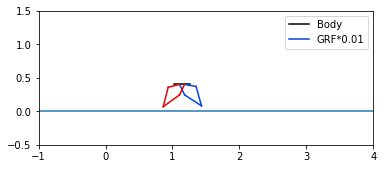

In [23]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_url = {}
    plot_lrl = {}
    plot_ull = {}
    plot_lll = {}
    plot_foot = {}
    abs_angles = {}
    
    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

    for leg in legs:
        if leg == 'A':
            link_colour = ['blue','red']
        else:
            link_colour = ['red','purple']
        
        
        #plot upper right
        abs_angles.update({('RU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_url'+leg].value})
        plot_url.update({('top','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_url.update({('top','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_url.update({('bot','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*cos(abs_angles['RU',leg])})
        plot_url.update({('bot','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*sin(abs_angles['RU',leg])})
        ax.plot([plot_url['top','X',leg],plot_url['bot','X',leg]],[plot_url['top','Y',leg],plot_url['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot lower right
        abs_angles.update({('RL',leg): m.q[i,'theta_lrl'+leg].value - (np.pi-abs_angles['RU',leg])})
        plot_lrl.update({('top','X',leg): plot_url['bot','X',leg]})
        plot_lrl.update({('top','Y',leg): plot_url['bot','Y',leg]})
        plot_lrl.update({('bot','X',leg): plot_url['bot','X',leg] - m.lengths['lrl'+leg]*cos(abs_angles['RL',leg])})
        plot_lrl.update({('bot','Y',leg): plot_url['bot','Y',leg] - m.lengths['lrl'+leg]*sin(abs_angles['RL',leg])})
        ax.plot([plot_lrl['top','X',leg],plot_lrl['bot','X',leg]],[plot_lrl['top','Y',leg],plot_lrl['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot upper left
        abs_angles.update({('LU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_ull'+leg].value})
        plot_ull.update({('top','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_ull.update({('top','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_ull.update({('bot','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*cos(abs_angles['LU',leg])})
        plot_ull.update({('bot','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*sin(abs_angles['LU',leg])})
        ax.plot([plot_ull['top','X',leg],plot_ull['bot','X',leg]],[plot_ull['top','Y',leg],plot_ull['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot lower left
        abs_angles.update({('LL',leg):m.q[i,'theta_lll'+leg].value - (np.pi-abs_angles['LU',leg])})
        plot_lll.update({('top','X',leg): plot_ull['bot','X',leg]})
        plot_lll.update({('top','Y',leg): plot_ull['bot','Y',leg]})
        plot_lll.update({('bot','X',leg): plot_ull['bot','X',leg] - m.lengths['lll'+leg]*cos(abs_angles['LL',leg])})
        plot_lll.update({('bot','Y',leg): plot_ull['bot','Y',leg] - m.lengths['lll'+leg]*sin(abs_angles['LL',leg])})
        ax.plot([plot_lll['top','X',leg],plot_lll['bot','X',leg]],[plot_lll['top','Y',leg],plot_lll['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))     
    
    
    if m.GRF_y[i,'A'].value > 0.0:
        #print('GRF_footR = ',m.GRF_y[i,'footR'].value)
        ax.arrow(plot_lll['bot','X','A'], plot_lll['bot','Y','A'], 0, 0.01*m.GRF_y[i,'A'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
        
    if m.GRF_y[i,'B'].value > 0.0:
        #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
        ax.arrow(plot_lrl['bot','X','B'], plot_lrl['bot','Y','B'], 0, 0.01*m.GRF_y[i,'B'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
    
    ax.legend(["Body","GRF*0.01"], frameon=True)
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


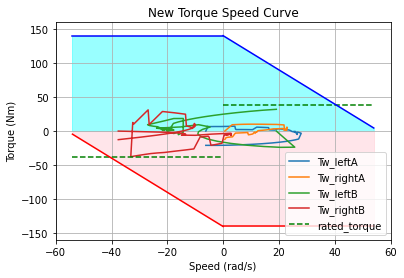

In [24]:
f = r"{0}_biped.mp4".format(test) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo) 
vel = 0.0

nodes = []

xbody = []
ybody = []
thbody = []
thullA = []
thurlA = []
thlllA = []
thlrlA = []
thullB = []
thurlB = []
thlllB = []
thlrlB = []



dxbody = []
dybody = []
dthbody = []
dthullA = []
dthurlA = []
dthlllA = []
dthlrlA = []
dthullB = []
dthurlB = []
dthlllB = []
dthlrlB = []

ddxbody = []
ddybody = []
ddthbody = []
ddthullA = []
ddthurlA = []
ddthlllA = []
ddthlrlA = []
ddthullB = []
ddthurlB = []
ddthlllB = []
ddthlrlB = []

Torque_leftA = []
Torque_rightA = []
Torque_leftB = []
Torque_rightB = []

GRF_y_A = []
GRF_y_B = []

angular_speed_leftA = []
angular_speed_rightA = []
angular_speed_leftB = []
angular_speed_rightB = []



for n in range(1,N+1):
    
    xbody.append(m.q[n,'x_body'].value)
    ybody.append(m.q[n,'y_body'].value)
    thbody.append(m.q[n,'theta_body'].value)
    thullA.append(m.q[n,'theta_ullA'].value) 
    thurlA.append(m.q[n,'theta_urlA'].value) 
    thlllA.append(m.q[n,'theta_lllA'].value) 
    thlrlA.append(m.q[n,'theta_lrlA'].value) 
    thullB.append(m.q[n,'theta_ullB'].value) 
    thurlB.append(m.q[n,'theta_urlB'].value) 
    thlllB.append(m.q[n,'theta_lllB'].value) 
    thlrlB.append(m.q[n,'theta_lrlB'].value) 

    dxbody.append(m.dq[n,'x_body'].value)
    dybody.append(m.dq[n,'y_body'].value)
    dthbody.append(m.dq[n,'theta_body'].value)
    dthullA.append(m.dq[n,'theta_ullA'].value) 
    dthurlA.append(m.dq[n,'theta_urlA'].value) 
    dthlllA.append(m.dq[n,'theta_lllA'].value) 
    dthlrlA.append(m.dq[n,'theta_lrlA'].value) 
    dthullB.append(m.dq[n,'theta_ullB'].value) 
    dthurlB.append(m.dq[n,'theta_urlB'].value) 
    dthlllB.append(m.dq[n,'theta_lllB'].value) 
    dthlrlB.append(m.dq[n,'theta_lrlB'].value) 

    ddxbody.append(m.ddq[n,'x_body'].value)
    ddybody.append(m.ddq[n,'y_body'].value)
    ddthbody.append(m.ddq[n,'theta_body'].value)
    ddthullA.append(m.ddq[n,'theta_ullA'].value) 
    ddthurlA.append(m.ddq[n,'theta_urlA'].value) 
    ddthlllA.append(m.ddq[n,'theta_lllA'].value) 
    ddthlrlA.append(m.ddq[n,'theta_lrlA'].value) 
    ddthullB.append(m.ddq[n,'theta_ullB'].value) 
    ddthurlB.append(m.ddq[n,'theta_urlB'].value) 
    ddthlllB.append(m.ddq[n,'theta_lllB'].value) 
    ddthlrlB.append(m.ddq[n,'theta_lrlB'].value) 

    Torque_leftA.append(m.tau_torque[n,'left','A'].value)
    Torque_rightA.append(m.tau_torque[n,'right','A'].value)
    Torque_leftB.append(m.tau_torque[n,'left','B'].value)
    Torque_rightB.append(m.tau_torque[n,'right','B'].value)

    GRF_y_A.append(m.GRF_y[n,'A'].value)
    GRF_y_B.append(m.GRF_y[n,'B'].value)

    angular_speed_leftA.append(m.tau_velocity[n,'left','A'].value) 
    angular_speed_rightA.append(m.tau_velocity[n,'right','A'].value)
    angular_speed_leftB.append(m.tau_velocity[n,'left','B'].value)
    angular_speed_rightB.append(m.tau_velocity[n,'right','B'].value)
    
    nodes.append(n)
    
    
    #print(m.q[n,'y_body'].value)
    #print(m.q[n,'{r_prismatic}_{footL}'].value)
    #print(m.foot_position[n, 'Y', 'footR'].value)
    #print(m.q[n,'y_body'].value)
    #print(m.dq[n,'x_body'].value)
    #vel = vel + m.dq[n,'x_body'].value
    #print(m.GRF_y[n,'footL'].value)
    #print(m.tau_torque[n,'left'].value)
    pass



''' Store first values in csv file '''
import csv
csv_file_name = str(int(V_avg))+'_u{0}'.format(mu_value)
csv_file_name = "Test_{0}_N_{1}_TT_{2}".format(test,N,str(int(TT)))

heading0 = ['node']
heading1 = ['x_body','y_body','theta_body','theta_ullA','theta_urlA','theta_lllA','theta_lrlA','theta_ullB','theta_urlB','theta_lllB','theta_lrlB']
heading2 = ['dx_body','dy_body','dtheta_body','dtheta_ullA','dtheta_urlA','dtheta_lllA','dtheta_lrlA','dtheta_ullB','dtheta_urlB','dtheta_lllB','dtheta_lrlB']
heading3 = ['ddx_body','ddy_body','ddtheta_body','ddtheta_ullA','ddtheta_urlA','ddtheta_lllA','ddtheta_lrlA','ddtheta_ullB','ddtheta_urlB','ddtheta_lllB','ddtheta_lrlB']
heading4 = ['Tau_leftA','Tau_rightA','Tau_leftB','Tau_rightB', 'GRF_yA','GRF_yB']
heading = heading0 + heading1 + heading2 + heading3 + heading4

with open(csv_file_name+'.csv', 'w') as f:
    writer = csv.writer(f)

    writer.writerow(heading)

    for n in range(N):
        node = [n]
        data1 = [xbody[n],ybody[n],thbody[n],thullA[n],thurlA[n],thlllA[n],thlrlA[n],thullB[n],thurlB[n],thlllB[n],thlrlB[n]]
        data2 = [dxbody[n],dybody[n],dthbody[n],dthullA[n],dthurlA[n],dthlllA[n],dthlrlA[n],dthullB[n],dthurlB[n],dthlllB[n],dthlrlB[n]]
        data3 = [ddxbody[n],ddybody[n],ddthbody[n],ddthullA[n],ddthurlA[n],ddthlllA[n],ddthlrlA[n],ddthullB[n],ddthurlB[n],ddthlllB[n],ddthlrlB[n]]
        data4 = [Torque_leftA[n],Torque_rightA[n],Torque_leftB[n],Torque_rightB[n],GRF_y_A[n],GRF_y_B[n]]
        data = node + data1 + data2 + data3 + data4
        writer.writerow(data)

plt.figure()
plt.plot(angular_speed_leftA,Torque_leftA)
plt.plot(angular_speed_rightA,Torque_rightA)
plt.plot(angular_speed_leftB,Torque_leftB)
plt.plot(angular_speed_rightB,Torque_rightB)

plt.grid()
plt.plot(x_p,rated_torque_p,color = 'green',linestyle = '--')
plt.plot(x_n,rated_torque_n,color = 'green',linestyle = '--')

plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
plt.legend(["Tw_leftA", "Tw_rightA","Tw_leftB", "Tw_rightB","rated_torque"], loc=0, frameon=True)

In [25]:
# try: 
#     # solving
#     opt = SolverFactory('ipopt',executable = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt')
#     opt.options["linear_solver"] = 'ma86'

#     # solver options
#     opt.options["expect_infeasible_problem"] = 'yes'
#     #pt.options["linear_system_scaling"] = 'none'
#     #opt.options["mu_strategy"] = "adaptive"
#     opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
#     opt.options["max_iter"] = 30000*10   # maximum number of iterations
#     opt.options["max_cpu_time"] = 600*10  # maximum cpu time in seconds
#     opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

#     results = opt.solve(m, tee = True)

#     ###########################################################################################################

#     # PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
#     # T = sum(m.h[n] for n in range(1,N+1))
#     pen_sum = 0.0
#     for n in range(1,N+1):
#             for gc in ground_constraints:
#                 for leg in legs:
#                     pen_sum += m.ground_penalty[n,gc,leg].value
#     print(pen_sum)

#     ###########################################################################################################

#     #animate it
#     import matplotlib
#     import matplotlib.pyplot as plt
#     import matplotlib.animation as ani
#     from IPython.display import HTML
#     %matplotlib inline

#     fig1, ax1 = plt.subplots(1,1) #create axes
#     ax1.set_aspect('equal')

#     # arrays to store values
#     N_time = []

#     def plot_robot(i,m,ax): #update function for animation
#         ax.clear()
#         ax.set_xlim([x_low_lim,x_high_lim])
#         ax.set_ylim([y_low_lim,y_high_lim])
#         N_time.append(i)

#         plot_body = {}
#         plot_url = {}
#         plot_lrl = {}
#         plot_ull = {}
#         plot_lll = {}
#         plot_foot = {}
#         abs_angles = {}

#         # plot body
#         plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
#         plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
#         plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
#         plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
#         ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

#         for leg in legs:
#             if leg == 'A':
#                 link_colour = ['blue','red']
#             else:
#                 link_colour = ['red','purple']


#             #plot upper right
#             abs_angles.update({('RU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_url'+leg].value})
#             plot_url.update({('top','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
#             plot_url.update({('top','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
#             plot_url.update({('bot','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*cos(abs_angles['RU',leg])})
#             plot_url.update({('bot','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*sin(abs_angles['RU',leg])})
#             ax.plot([plot_url['top','X',leg],plot_url['bot','X',leg]],[plot_url['top','Y',leg],plot_url['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

#             #plot lower right
#             abs_angles.update({('RL',leg): m.q[i,'theta_lrl'+leg].value - (np.pi-abs_angles['RU',leg])})
#             plot_lrl.update({('top','X',leg): plot_url['bot','X',leg]})
#             plot_lrl.update({('top','Y',leg): plot_url['bot','Y',leg]})
#             plot_lrl.update({('bot','X',leg): plot_url['bot','X',leg] - m.lengths['lrl'+leg]*cos(abs_angles['RL',leg])})
#             plot_lrl.update({('bot','Y',leg): plot_url['bot','Y',leg] - m.lengths['lrl'+leg]*sin(abs_angles['RL',leg])})
#             ax.plot([plot_lrl['top','X',leg],plot_lrl['bot','X',leg]],[plot_lrl['top','Y',leg],plot_lrl['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

#             #plot upper left
#             abs_angles.update({('LU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_ull'+leg].value})
#             plot_ull.update({('top','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
#             plot_ull.update({('top','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
#             plot_ull.update({('bot','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*cos(abs_angles['LU',leg])})
#             plot_ull.update({('bot','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*sin(abs_angles['LU',leg])})
#             ax.plot([plot_ull['top','X',leg],plot_ull['bot','X',leg]],[plot_ull['top','Y',leg],plot_ull['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

#             #plot lower left
#             abs_angles.update({('LL',leg):m.q[i,'theta_lll'+leg].value - (np.pi-abs_angles['LU',leg])})
#             plot_lll.update({('top','X',leg): plot_ull['bot','X',leg]})
#             plot_lll.update({('top','Y',leg): plot_ull['bot','Y',leg]})
#             plot_lll.update({('bot','X',leg): plot_ull['bot','X',leg] - m.lengths['lll'+leg]*cos(abs_angles['LL',leg])})
#             plot_lll.update({('bot','Y',leg): plot_ull['bot','Y',leg] - m.lengths['lll'+leg]*sin(abs_angles['LL',leg])})
#             ax.plot([plot_lll['top','X',leg],plot_lll['bot','X',leg]],[plot_lll['top','Y',leg],plot_lll['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))     


#         if m.GRF_y[i,'A'].value > 0.0:
#             #print('GRF_footR = ',m.GRF_y[i,'footR'].value)
#             ax.arrow(plot_lll['bot','X','A'], plot_lll['bot','Y','A'], 0, 0.01*m.GRF_y[i,'A'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)

#         if m.GRF_y[i,'B'].value > 0.0:
#             #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
#             ax.arrow(plot_lrl['bot','X','B'], plot_lrl['bot','Y','B'], 0, 0.01*m.GRF_y[i,'B'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)

#         ax.legend(["Body","GRF*0.01"], frameon=True)

#         ax.plot([-10,10],[0,0]) # plot the ground


#     update = lambda i: plot_robot(i,m,ax1) # lambdify update function

#     animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

#     HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

#     ###########################################################################################################

#     import os

#     # Directory
#     directory = "Test_{0}_N_{1}_TT_{2}".format(test,N,str(int(TT)))

#     # Parent Directory path
#     parent_dir = "BRAKING_8ms"

#     # Path
#     path = os.path.join(parent_dir, directory) 
#     os.mkdir(path)

#     csv_file_name = directory
#     #with open(os.path.join(parent_dir, directory,directory)+'.csv', 'w') as f:
#     with open("BRAKING_8ms/{0}/Results.csv".format(directory) , 'w') as f:
#         writer = csv.writer(f)
#         writer.writerow(['ground_penalty','status','mu','TT','N','h_lower','h_higher'])
#         writer.writerow([pen_sum,results.solver.termination_condition,mu_value,TT,N,h_lower_bound,h_higher_bound])

#     import csv
#     #csv_file_name = str(int(V_avg))+'.csv'

#     heading0 = ['node']
#     heading1 = ['x_body','y_body','theta_body','theta_ullA','theta_urlA','theta_lllA','theta_lrlA','theta_ullB','theta_urlB','theta_lllB','theta_lrlB']
#     heading2 = ['dx_body','dy_body','dtheta_body','dtheta_ullA','dtheta_urlA','dtheta_lllA','dtheta_lrlA','dtheta_ullB','dtheta_urlB','dtheta_lllB','dtheta_lrlB']
#     heading3 = ['ddx_body','ddy_body','ddtheta_body','ddtheta_ullA','ddtheta_urlA','ddtheta_lllA','ddtheta_lrlA','ddtheta_ullB','ddtheta_urlB','ddtheta_lllB','ddtheta_lrlB']
#     heading4 = ['Tau_leftA','Tau_rightA','Tau_leftB','Tau_rightB']
#     heading = heading0 + heading1 + heading2 + heading3 + heading4

#     with open("BRAKING_8ms/{0}/Data.csv".format(directory), 'w') as f:
#         writer = csv.writer(f)

#         writer.writerow(heading)

#         for n in range(N):
#             node = [n]
#             data1 = [xbody[n],ybody[n],thbody[n],thullA[n],thurlA[n],thlllA[n],thlrlA[n],thullB[n],thurlB[n],thlllB[n],thlrlB[n]]
#             data2 = [dxbody[n],dybody[n],dthbody[n],dthullA[n],dthurlA[n],dthlllA[n],dthlrlA[n],dthullB[n],dthurlB[n],dthlllB[n],dthlrlB[n]]
#             data3 = [ddxbody[n],ddybody[n],ddthbody[n],ddthullA[n],ddthurlA[n],ddthlllA[n],ddthlrlA[n],ddthullB[n],ddthurlB[n],ddthlllB[n],ddthlrlB[n]]
#             data4 = [Torque_leftA[n],Torque_rightA[n],Torque_leftB[n],Torque_rightB[n]]
#             data = node + data1 + data2 + data3 + data4
#             writer.writerow(data)    

#     plt.figure()
#     plt.plot(angular_speed_leftA,Torque_leftA)
#     plt.plot(angular_speed_rightA,Torque_rightA)
#     plt.plot(angular_speed_leftB,Torque_leftB)
#     plt.plot(angular_speed_rightB,Torque_rightB)

#     plt.grid()
#     plt.plot(x_p,rated_torque_p,color = 'green',linestyle = '--')
#     plt.plot(x_n,rated_torque_n,color = 'green',linestyle = '--')

#     plt.plot(x_p, y_p,'b')
#     plt.plot(x_n, stall_torque_p,'b')

#     plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
#     plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

#     plt.plot(x_n, y_n,'r')
#     plt.plot(x_p, stall_torque_n,'r')

#     plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
#     plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

#     plt.axis((-60,60,-160,160))
#     plt.title('New Torque Speed Curve')
#     plt.xlabel('Speed (rad/s)')
#     plt.ylabel('Torque (Nm)')
#     plt.legend(["Tw_leftA", "Tw_rightA","Tw_leftB", "Tw_rightB","rated_torque"], loc=0, frameon=True)
#     plt.savefig("BRAKING_8ms/{0}/Torque_Speed.jpg".format(directory))

#     f = r"BRAKING_8ms/{0}/{1}_biped.mp4".format(directory,test) 
#     writervideo = ani.FFMpegWriter(fps=20) 
#     animate.save(f, writer=writervideo)   
# except:
#     pass

In [26]:
N

100

In [27]:
m.connect_force[50,'Y','B'].value

-39.25025986156241

In [28]:
m.dq[1,'x_body'].value

8.23105175265189

<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#Select_Test'>Link to Test Selection'</a>